### Pre-Evaluation: Testing Statistical distribution with ANOVA and Levene's test
- Checking processed Data to avoid statistical artifacts

Aggregating feature‑level variances …
Collected 57,556 feature variances (2 phases, 8 participants).


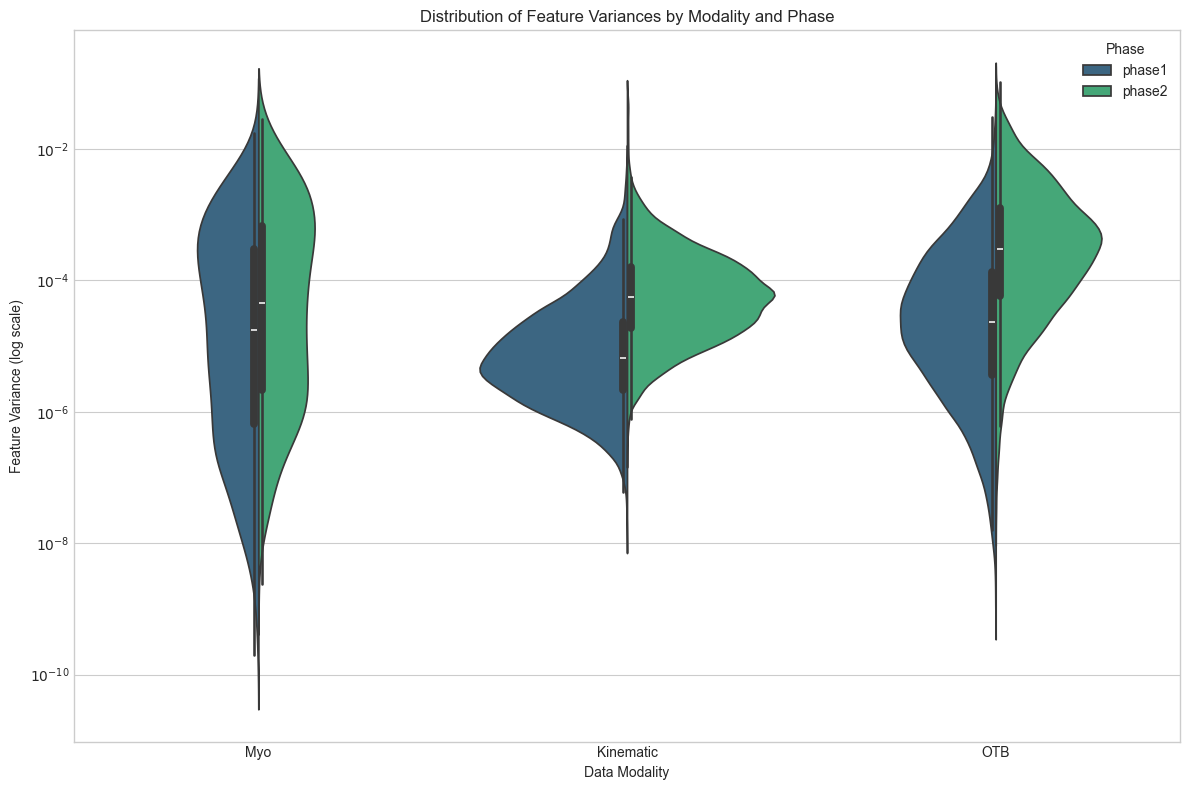


Phase phase1:
  ANOVA  F =   172.82, p = 2.459e-75
  Levene W =   169.83, p = 4.721e-74

Phase phase2:
  ANOVA  F =   457.43, p = 2.720e-196
  Levene W =   429.95, p = 1.020e-184


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import f_oneway, levene

# ------------------------------------------------------------------ #
# 1) CONFIGURATION
# ------------------------------------------------------------------ #
BASE_DIR   = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Data_Variance_Evaluation"

PARTICIPANTS_TO_TEST = list(range(1, 9))
TRIALS_TO_TEST       = range(1, 25)
PHASES_TO_TEST       = ["phase1", "phase2"]

ORIGINAL_SAMPLING_RATE = 2000.0
N_POSE_COLUMNS         = 6

# ------------------------------------------------------------------ #
# 2) LOAD  ►  RETURN PER‑FEATURE VARIANCES ONLY
# ------------------------------------------------------------------ #
def var_per_feature(participant_dir, trial, phase):
    """
    Returns a DataFrame with one row per feature (<=180) containing:
        participant, trial, phase, feature_index, modality, variance
    If any file missing / too short ➜ returns None.
    """
    sdir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    kin_f = os.path.join(sdir, f"match_{trial:02d}_{phase}_kin_norm.npy")
    myo_f = os.path.join(sdir, f"match_{trial:02d}_{phase}_myo.npy")
    otb_f = os.path.join(sdir, f"match_{trial:02d}_{phase}_otb.npy")
    if not all(os.path.exists(f) for f in (kin_f, myo_f, otb_f)):
        return None

    kin, myo, otb = map(np.load, (kin_f, myo_f, otb_f))

    # crop rules identical to original
    if phase == "phase1":
        n = int(0.5 * ORIGINAL_SAMPLING_RATE)
        kin, myo, otb = kin[-n:], myo[-n:], otb[-n:]
    else:
        n = int(1.0 * ORIGINAL_SAMPLING_RATE)
        kin, myo, otb = kin[:n], myo[:n], otb[:n]

    T = min(len(kin), len(myo), len(otb))
    if T < 5 or kin.shape[1] <= N_POSE_COLUMNS:
        return None

    kin_h = kin[:T, : kin.shape[1] - N_POSE_COLUMNS]
    myo   = myo[:T]
    otb   = otb[:T]
    X     = np.hstack([otb, myo, kin_h])

    # per‑feature variance (ddof=1 keeps unbiased estimator)
    var_vec = np.var(X, axis=0, ddof=1)

    labels = (["OTB"] * otb.shape[1] +
              ["Myo"] * myo.shape[1] +
              ["Kinematic"] * kin_h.shape[1])

    df = pd.DataFrame({
        "participant"   : participant_dir[-2:-1] if participant_dir.endswith(")") else participant_dir,
        "trial"         : trial,
        "phase"         : phase,
        "feature_index" : np.arange(X.shape[1]),
        "modality"      : labels,
        "variance"      : var_vec
    })
    return df

# ------------------------------------------------------------------ #
# 3) ANALYSIS
# ------------------------------------------------------------------ #
def run_modality_variance_analysis():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    rows = []

    print("Aggregating feature‑level variances …")
    for pid in PARTICIPANTS_TO_TEST:
        p_dir = os.path.join(BASE_DIR, f"P({pid})")
        for trial in TRIALS_TO_TEST:
            for phase in PHASES_TO_TEST:
                df = var_per_feature(p_dir, trial, phase)
                if df is not None:
                    df["participant"] = pid   # overwrite safe value
                    rows.append(df)

    if not rows:
        print("No data found.")
        return

    var_df = pd.concat(rows, ignore_index=True)
    var_df = var_df[var_df["variance"].gt(0)].dropna()
    var_df["log10_variance"] = np.log10(var_df["variance"])

    print(f"Collected {len(var_df):,} feature variances "
          f"({var_df['phase'].nunique()} phases, {var_df['participant'].nunique()} participants).")

    # ------------------  PLOT  ------------------
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.violinplot(x="modality", y="log10_variance",
                   hue="phase", data=var_df,
                   order=["Myo","Kinematic","OTB"],
                   palette="viridis", inner="box",
                   split=True, ax=ax)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y,_: f"$10^{{{int(y)}}}$"))
    ax.set(title="Distribution of Feature Variances by Modality and Phase",
           xlabel="Data Modality", ylabel="Feature Variance (log scale)")
    ax.legend(title="Phase")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "Variances_by_Modality_and_Phase.png"), dpi=150)
    plt.show()

    # ----------------  STATS PER PHASE  ----------------
    for phase in PHASES_TO_TEST:
        sub = var_df.query("phase == @phase")
        myo = sub.loc[sub.modality=="Myo","variance"]
        kin = sub.loc[sub.modality=="Kinematic","variance"]
        otb = sub.loc[sub.modality=="OTB","variance"]

        a_F, a_p = f_oneway(myo, kin, otb)
        l_W, l_p = levene(myo, kin, otb)

        print(f"\nPhase {phase}:")
        print(f"  ANOVA  F = {a_F:8.2f}, p = {a_p:.3e}")
        print(f"  Levene W = {l_W:8.2f}, p = {l_p:.3e}")

# ------------------------------------------------------------------ #
# 4) EXECUTION
# ------------------------------------------------------------------ #
if __name__ == "__main__":
    run_modality_variance_analysis()


### Testing Statistical Distribution of Processed Data Matrizes
- Verifying Standardization

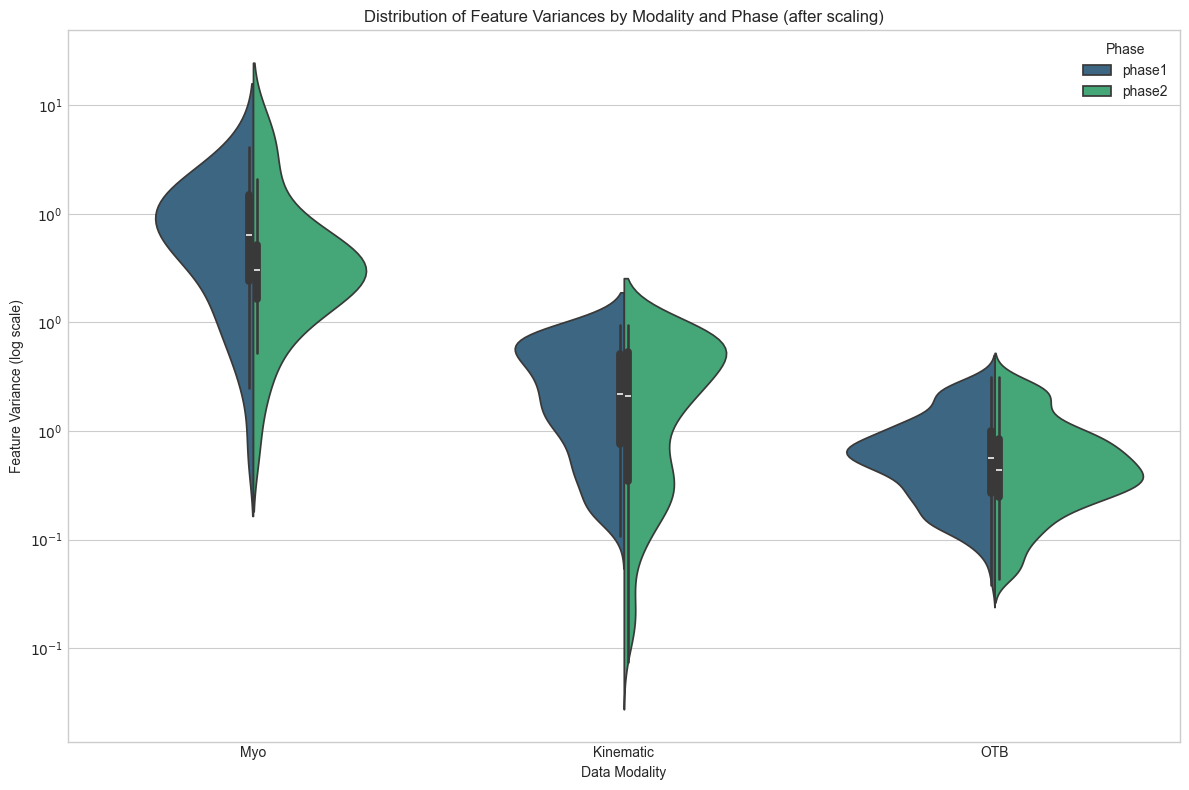


Phase phase1:
  ANOVA  F =  1213.65, p = 0.000e+00
  Levene W =   724.88, p = 1.248e-213

Phase phase2:
  ANOVA  F =   610.40, p = 0.000e+00
  Levene W =   266.96, p = 3.367e-98


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import f_oneway, levene
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------------------ #
# 1) CONFIGURATION
# ------------------------------------------------------------------ #
BASE_DIR   = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Standardized_Data_Variance_Evaluation"

PARTICIPANTS = list(range(1, 9))
PHASES       = ["phase1", "phase2"]

# ------------------------------------------------------------------ #
# 2) VARIANCE CALCULATION (per participant *and* phase)
# ------------------------------------------------------------------ #
def variances_for_participant_phase(p_dir, pid, phase):
    """
    Returns a tiny DataFrame (≤180 rows) with per-feature variance for one
    participant & one phase. If files are missing, returns None.
    """
    pre_dir = os.path.join(p_dir, "Preprocessed_Data_Matrix")
    mat_path = os.path.join(pre_dir, f"P{pid}_combined_matrix_{phase}.npy")
    idx_path = os.path.join(pre_dir, f"P{pid}_feature_indices.joblib")
    if not os.path.exists(mat_path) or not os.path.exists(idx_path):
        return None

    X = np.load(mat_path)              # (samples × 180)
    var_vec = np.var(X, axis=0, ddof=1)
    idx = joblib.load(idx_path)

    labels = [""] * X.shape[1]
    for key, tag in zip(
            ("otb_indices","myo_indices","kin_hand_indices"),
            ("OTB","Myo","Kinematic")):
        s, e = idx.get(key, (0,0))
        labels[s:e] = [tag]*(e-s)

    return pd.DataFrame({
        "participant"   : pid,
        "phase"         : phase,
        "feature_index" : np.arange(X.shape[1]),
        "modality"      : labels,
        "variance"      : var_vec
    })

# ------------------------------------------------------------------ #
# 3) ANALYSIS
# ------------------------------------------------------------------ #
def run_analysis():
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    frames = []

    print("Collecting per‑feature variances …")
    for pid in PARTICIPANTS:
        p_dir = os.path.join(BASE_DIR, f"P({pid})")
        for phase in PHASES:
            df = variances_for_participant_phase(p_dir, pid, phase)
            if df is not None:
                frames.append(df)

    if not frames:
        print("No data found.")
        return

    df_all = pd.concat(frames, ignore_index=True)
    df_all = df_all.query("variance > 1e-12").copy()
    df_all["log10_variance"] = np.log10(df_all["variance"])

    # ----------------  PLOT  ----------------
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.violinplot(
        x="modality", y="log10_variance",
        hue="phase", data=df_all,
        order=["Myo","Kinematic","OTB"],
        palette="viridis", inner="box", split=True, ax=ax)

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y,_: f"$10^{{{int(y)}}}$"))
    ax.set(title="Distribution of Feature Variances by Modality and Phase (after scaling)",
           xlabel="Data Modality", ylabel="Feature Variance (log scale)")
    ax.legend(title="Phase")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "Distribution_of_Feature_Variances.png"), dpi=150)
    plt.show()

    # ----------------  STATS PER PHASE  ----------------
    for phase in PHASES:
        sub = df_all.query("phase == @phase")
        myo = sub.loc[sub.modality=="Myo","variance"]
        kin = sub.loc[sub.modality=="Kinematic","variance"]
        otb = sub.loc[sub.modality=="OTB","variance"]

        a_F, a_p = f_oneway(myo, kin, otb)
        l_W, l_p = levene(myo, kin, otb)

        print(f"\nPhase {phase}:")
        print(f"  ANOVA  F = {a_F:8.2f}, p = {a_p:.3e}")
        print(f"  Levene W = {l_W:8.2f}, p = {l_p:.3e}")

# ------------------------------------------------------------------ #
# 4) RUN
# ------------------------------------------------------------------ #
if __name__ == "__main__":
    run_analysis()


### Question 1a: Dimensionality Analysis via R² and VAF comparisson

Comments Addressed:
 - **Testing with R² and VAF Metric**  
 - **Plot for R² and VAF Curve** 

In [4]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import r2_score

# ==========================================================================================
# 1) GLOBAL CONFIGURATION
# ==========================================================================================

# --- Directories ---
BASE_DATA_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1a_Dimensionality_Analysis"
SYNERGY_PARENT_DIR_NAME = "Synergies Publication 5X" # Corrected from "Synergies Publication"
PREPROCESSED_DATA_DIR_NAME = "Preprocessed_Data_Matrix"

# --- Analysis Configuration (MODIFIED) ---
# The analysis types now map to the synergy levels that were actually extracted.
# The names "Lift-Onset" and "Full-Phase" must match the directory names created by Script 1.
ANALYSIS_CONFIG = {
    "Lift-Onset": [1, 2, 3],
    "Full-Phase": [1, 2, 3, 4, 5]
}

# --- Participants & Trials ---
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
P7_SKIPPED_TRIALS = [20, 22]

# --- Data Parameters ---
SAMPLING_RATE = 2000.0
PRE_LIFT_CLIP_SECONDS = 1.0
POST_LIFT_CLIP_SECONDS = 1.5
PRE_LIFT_SAMPLES = int(PRE_LIFT_CLIP_SECONDS * SAMPLING_RATE)
POST_LIFT_SAMPLES = int(POST_LIFT_CLIP_SECONDS * SAMPLING_RATE)

# ==========================================================================================
# 2) HELPER FUNCTIONS
# ==========================================================================================

def load_synergy_wc_matrix(participant_dir, trial_idx, phase_name, num_synergies, analysis_type):
    """Loads W and C matrices for a specific trial, phase, and synergy condition."""
    synergy_dir = os.path.join(
        participant_dir, SYNERGY_PARENT_DIR_NAME, analysis_type, phase_name,
        f"{num_synergies}_Syn", f"Trial_{trial_idx:02d}"
    )
    if not os.path.isdir(synergy_dir):
        return None, None
    w_file, c_file = os.path.join(synergy_dir, "W_synergies.npy"), os.path.join(synergy_dir, "C_activations.npy")
    if os.path.exists(w_file) and os.path.exists(c_file):
        try:
            return np.load(w_file), np.load(c_file)
        except Exception as e:
            print(f"  [ERROR] Could not load W/C for T({trial_idx}) Syn({num_synergies}): {e}")
    return None, None

def calculate_centered_r2(X_original, X_reconstructed):
    """Calculates the global centered R-squared score."""
    if X_original is None or X_reconstructed is None or np.isnan(X_original).any() or np.isnan(X_reconstructed).any():
        return np.nan
    if X_original.shape != X_reconstructed.shape:
        print(f"  [WARN] Shape mismatch for R2 calc: Original {X_original.shape}, Reconstructed {X_reconstructed.shape}")
        return np.nan
    return r2_score(X_original.flatten(), X_reconstructed.flatten())

def calculate_vaf(X_original, X_reconstructed):
    """Calculates the global Variance Accounted For (VAF)."""
    if X_original is None or X_reconstructed is None or np.isnan(X_original).any() or np.isnan(X_reconstructed).any():
        return np.nan
    if X_original.shape != X_reconstructed.shape:
        return np.nan
    
    sse = np.sum((X_original - X_reconstructed) ** 2)
    ss_total = np.sum(X_original ** 2)
    
    if ss_total == 0:
        return 1.0 if sse == 0 else 0.0
        
    return 1 - (sse / ss_total)

# ==========================================================================================
# 3) MAIN ANALYSIS SCRIPT [MODIFIED]
# ==========================================================================================

def run_reconstruction_analysis():
    """Main function to run the R-squared and VAF progression analysis."""
    print("Starting R-squared and VAF Progression Analysis...\n")
    all_results = []
    
    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DATA_DIR, participant_str)
        preprocessed_dir = os.path.join(participant_dir, PREPROCESSED_DATA_DIR_NAME)
        
        matrix_p1_path = os.path.join(preprocessed_dir, f"P{pid}_combined_matrix_phase1.npy")
        matrix_p2_path = os.path.join(preprocessed_dir, f"P{pid}_combined_matrix_phase2.npy")
        indices_path = os.path.join(preprocessed_dir, f"P{pid}_feature_indices.joblib")
        
        if not all(os.path.exists(p) for p in [matrix_p1_path, matrix_p2_path, indices_path]):
            print(f"Warning: Missing one or more data files for {participant_str}. Skipping.")
            continue
            
        p1_full_matrix = np.load(matrix_p1_path)
        p2_full_matrix = np.load(matrix_p2_path)
        indices_data = joblib.load(indices_path)
        print(f"Processing Participant {pid}...")

        p1_trial_lengths = indices_data.get('phase1_trial_lengths', [])
        p1_end_indices = np.cumsum(p1_trial_lengths)
        p1_start_indices = p1_end_indices - p1_trial_lengths
        
        p2_trial_lengths = indices_data.get('phase2_trial_lengths', [])
        p2_end_indices = np.cumsum(p2_trial_lengths)
        p2_start_indices = p2_end_indices - p2_trial_lengths
        
        valid_trials = [t for t in range(1, 25) if not (pid == 7 and t in P7_SKIPPED_TRIALS)]
        trial_id_to_idx = {trial_id: i for i, trial_id in enumerate(valid_trials)}

        # MODIFIED: Loop through the config dictionary
        for analysis_type, synergy_levels_to_check in ANALYSIS_CONFIG.items():
            print(f"  Calculating for: '{analysis_type}'")
            # MODIFIED: Loop through the correct synergy levels for the current analysis type
            for num_synergies in synergy_levels_to_check:
                for phase_name, full_matrix, starts, ends in [
                    ("Phase 1", p1_full_matrix, p1_start_indices, p1_end_indices),
                    ("Phase 2", p2_full_matrix, p2_start_indices, p2_end_indices)
                ]:
                    for trial_id in valid_trials:
                        trial_idx_in_list = trial_id_to_idx.get(trial_id)
                        if trial_idx_in_list is None or trial_idx_in_list >= len(starts):
                            continue

                        data_slice = slice(starts[trial_idx_in_list], ends[trial_idx_in_list])
                        full_trial_data = full_matrix[data_slice]
                        
                        if analysis_type == "Lift-Onset":
                            X_orig_rows = full_trial_data[-PRE_LIFT_SAMPLES:] if phase_name == "Phase 1" else full_trial_data[:POST_LIFT_SAMPLES]
                        else: # "Full-Phase"
                            X_orig_rows = full_trial_data
                        
                        if X_orig_rows.shape[0] == 0: continue

                        X_orig = X_orig_rows.T
                        W, C = load_synergy_wc_matrix(participant_dir, trial_id, phase_name, num_synergies, analysis_type)
                        
                        if W is None or C is None: continue
                        
                        X_hat = W @ C
                        
                        # Calculate both metrics
                        r2 = calculate_centered_r2(X_orig, X_hat)
                        vaf = calculate_vaf(X_orig, X_hat)

                        if not np.isnan(r2) and not np.isnan(vaf):
                            all_results.append({
                                'participant': pid, 'trial': trial_id, 'phase': phase_name,
                                'num_synergies': num_synergies, 'r2': r2, 'vaf': vaf,
                                'analysis_type': analysis_type
                            })

    if not all_results:
        print("CRITICAL ERROR: No data could be calculated.")
        return

    # --- AGGREGATION AND SAVING ---
    results_df = pd.DataFrame(all_results)
    agg_df = results_df.groupby(['participant', 'num_synergies', 'analysis_type', 'phase'])[['r2', 'vaf']].mean().reset_index()

    print("\n--- Aggregated R-squared and VAF Data ---\n" + agg_df.to_string())
    print("---------------------------------")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    results_df.to_csv(os.path.join(OUTPUT_DIR, "raw_r2_vaf_results.csv"), index=False)
    agg_df.to_csv(os.path.join(OUTPUT_DIR, "aggregated_r2_vaf_results.csv"), index=False)
    
    print(f"\nSuccess! Raw and aggregated data (R² and VAF) saved to:\n{OUTPUT_DIR}")
    print("\nCalculation complete.")

# ==========================================================================================
# 4) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_reconstruction_analysis()

Starting R-squared and VAF Progression Analysis...

Processing Participant 1...
  Calculating for: 'Lift-Onset'
  Calculating for: 'Full-Phase'
Processing Participant 2...
  Calculating for: 'Lift-Onset'
  Calculating for: 'Full-Phase'
Processing Participant 3...
  Calculating for: 'Lift-Onset'
  Calculating for: 'Full-Phase'
Processing Participant 4...
  Calculating for: 'Lift-Onset'
  Calculating for: 'Full-Phase'
Processing Participant 5...
  Calculating for: 'Lift-Onset'
  Calculating for: 'Full-Phase'
Processing Participant 6...
  Calculating for: 'Lift-Onset'
  Calculating for: 'Full-Phase'
Processing Participant 7...
  Calculating for: 'Lift-Onset'
  Calculating for: 'Full-Phase'
Processing Participant 8...
  Calculating for: 'Lift-Onset'
  Calculating for: 'Full-Phase'

--- Aggregated R-squared and VAF Data ---
     participant  num_synergies analysis_type    phase        r2       vaf
0              1              1    Full-Phase  Phase 1  0.916326  0.931260
1              1   

### Plotting R² and VAF scores for Full Phases, Lift-Onset Phases, Grasping Phase and Lift& Hold Phase

--- Loaded Participant-Aggregated Data for Plotting ---

Success! R-squared subplot figure saved to:
C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1a_Dimensionality_Analysis\Rsquared_Progression_Subplots_Grey.png


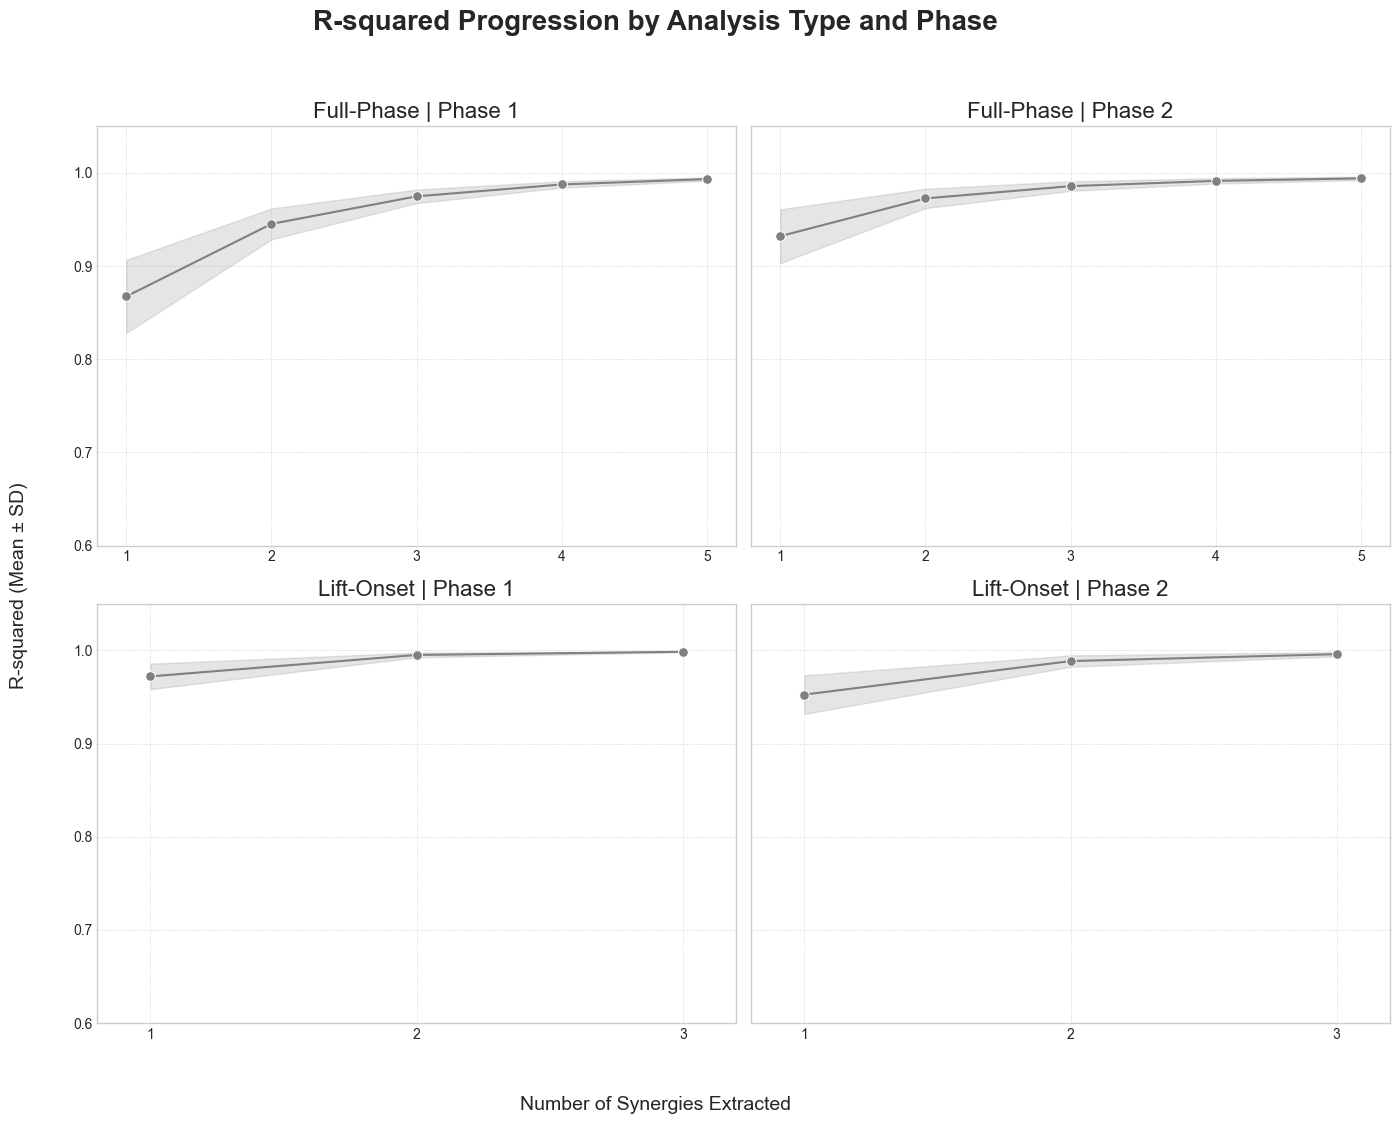


Success! VAF subplot figure saved to:
C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1a_Dimensionality_Analysis\VAF_Progression_Subplots_Grey.png


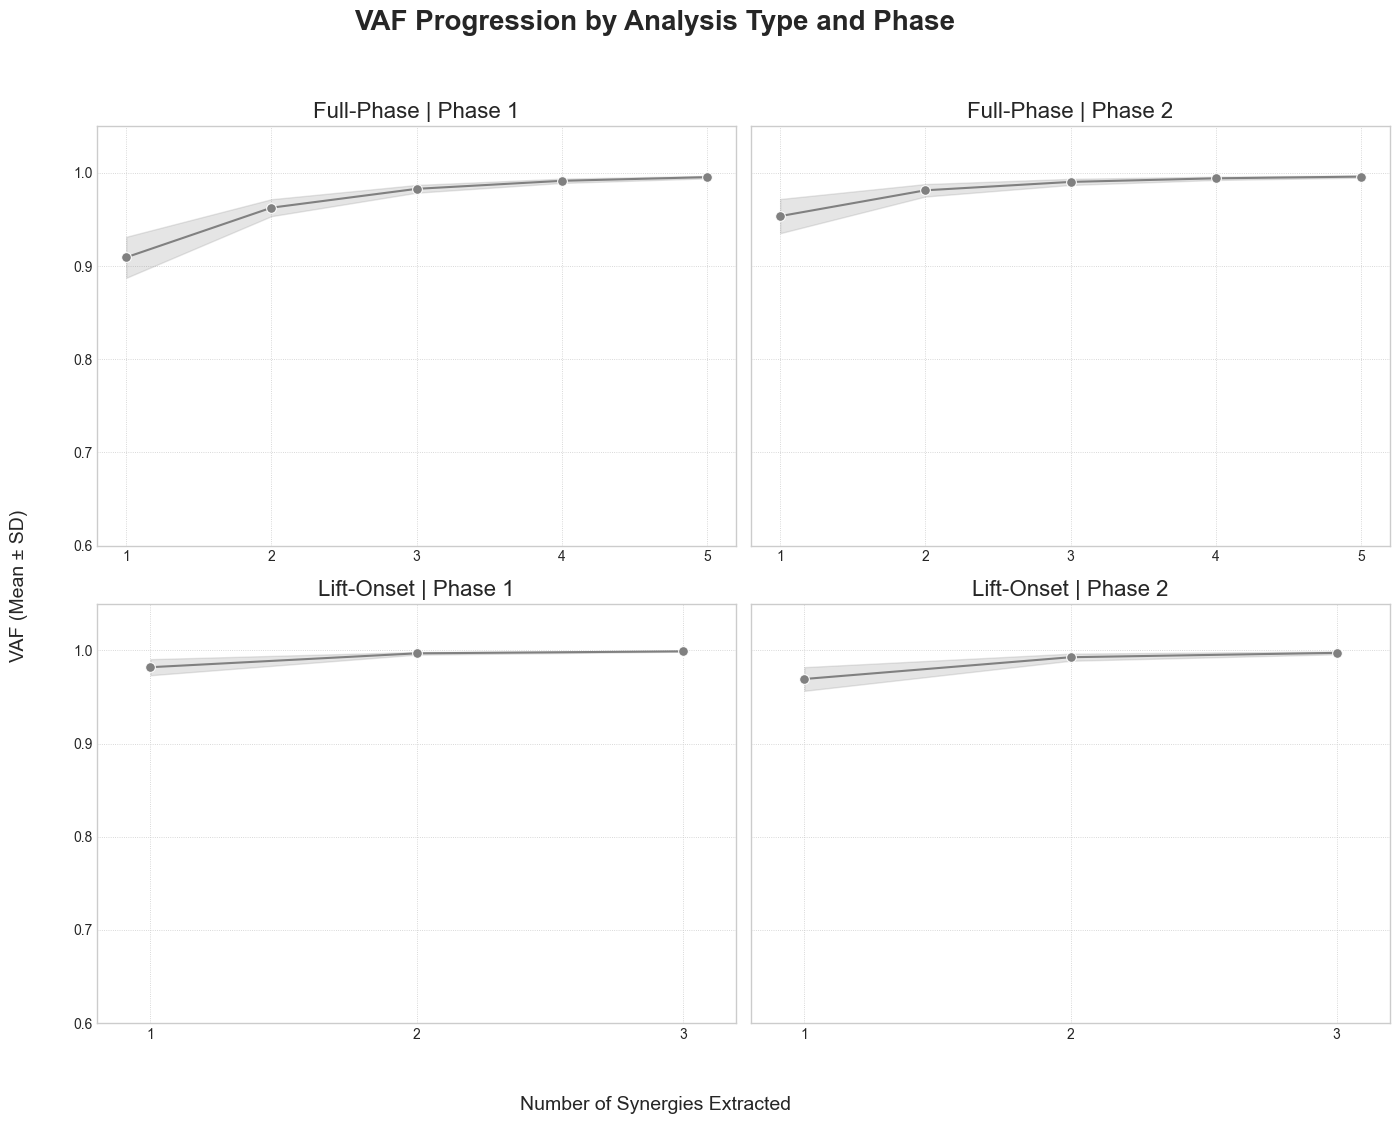

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================================================================
# 1) CONFIGURATION
# ==========================================================================================

# --- File Path ---
# This should be the directory where your 'aggregated_r2_vaf_results.csv' is located.
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1a_Dimensionality_Analysis"
DATA_FILENAME = "aggregated_r2_vaf_results.csv" 

# --- Plotting Parameters ---
# This is no longer used for setting x-axis ticks on all plots, but can be kept for reference.
SYNERGY_LEVELS = [1, 2, 3, 4, 5] 
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 14
TICK_LABEL_FONTSIZE = 12
SUPTITLE_FONTSIZE = 20

# ==========================================================================================
# 2) PLOTTING SCRIPT [MODIFIED]
# ==========================================================================================

def create_reconstruction_plot(metric_to_plot, participant_means_df):
    """
    Generic function to create a 2x2 subplot figure for a given metric ('r2' or 'vaf').
    
    MODIFIED:
    - Corrected 'Full Phases' to 'Full-Phase' to match the data.
    - Removed shared x-axis to allow each subplot to have its own appropriate ticks and limits.
    - X-axis ticks and limits are now set dynamically for each subplot based on the available data.
    """
    if metric_to_plot not in participant_means_df.columns:
        print(f"Error: Metric '{metric_to_plot}' not found in the DataFrame.")
        return

    metric_name = "R-squared" if metric_to_plot == 'r2' else "VAF"
    
    # --- PLOTTING ---
    plt.style.use('seaborn-v0_8-whitegrid')
    # MODIFIED: sharex=False allows each subplot to have an independent x-axis.
    fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=True)
    
    # MODIFIED: Changed 'Full Phases' to 'Full-Phase' to match the analysis_type in the CSV.
    conditions = [
        ('Full-Phase', 'Phase 1'),
        ('Full-Phase', 'Phase 2'),
        ('Lift-Onset', 'Phase 1'),
        ('Lift-Onset', 'Phase 2')
    ]
    
    for ax, (analysis_type, phase) in zip(axes.flatten(), conditions):
        df_subset = participant_means_df[
            (participant_means_df['analysis_type'] == analysis_type) & 
            (participant_means_df['phase'] == phase)
        ]
        
        if df_subset.empty:
            ax.text(0.5, 0.5, 'No data found for this condition', ha='center', va='center')
            ax.set_title(f"{analysis_type} | {phase}", fontsize=TITLE_FONTSIZE)
            continue

        plot_color = 'grey'
        
        # Plot the main line plot using the specified metric
        sns.lineplot(
            data=df_subset, x='num_synergies', y=metric_to_plot, 
            marker='o', markersize=7, ax=ax, errorbar='sd', 
            color=plot_color, err_kws={'alpha': 0.2}
        )
        
        ax.set_title(f"{analysis_type} | {phase}", fontsize=TITLE_FONTSIZE)
        ax.grid(True, which='both', linestyle=':', linewidth=0.6)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # MODIFIED: Set x-ticks and limits dynamically for each subplot
        synergy_ticks = sorted(df_subset['num_synergies'].unique())
        ax.set_xticks(synergy_ticks)
        if synergy_ticks:
            ax.set_xlim(min(synergy_ticks) - 0.2, max(synergy_ticks) + 0.2)

    # --- Set common labels and overall title ---
    fig.supxlabel('Number of Synergies Extracted', fontsize=AXIS_LABEL_FONTSIZE, y=0.06)
    fig.supylabel(f'{metric_name} (Mean ± SD)', fontsize=AXIS_LABEL_FONTSIZE, x=0.07)
    fig.suptitle(f'{metric_name} Progression by Analysis Type and Phase', fontsize=SUPTITLE_FONTSIZE, fontweight='bold')
    
    # Set y-axis properties for all shared-y plots
    plt.yticks(np.arange(0.6, 1.1, 0.1))
    plt.ylim(0.6, 1.05)
    
    plt.tight_layout(rect=[0.08, 0.08, 1, 0.95])

    # --- Save the plot ---
    # Using replace('-', '') to create a valid filename from the metric name
    output_plot_filename = f"{metric_name.replace('-', '')}_Progression_Subplots_Grey.png"
    output_plot_path = os.path.join(OUTPUT_DIR, output_plot_filename)
    plt.savefig(output_plot_path, dpi=300)
    
    print(f"\nSuccess! {metric_name} subplot figure saved to:\n{output_plot_path}")
    plt.show()
    plt.close(fig)

# ==========================================================================================
# 3) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    data_path = os.path.join(OUTPUT_DIR, DATA_FILENAME)
    if not os.path.exists(data_path):
        print(f"Error: Data file not found at '{data_path}'")
        print("Please run the calculation script first.")
    else:
        # Load the data once
        participant_means_df = pd.read_csv(data_path)
        print("--- Loaded Participant-Aggregated Data for Plotting ---")
        
        # Create a plot for R-squared
        create_reconstruction_plot('r2', participant_means_df)
        
        # Create a plot for VAF
        create_reconstruction_plot('vaf', participant_means_df)


### Question 1b: Synergy Similarity between Phases

Comments Addressed:
 - **Testing W (Synergy Vectors):** The original script already loads and compares `_W.npy` files (synergy vectors), which aligns with the preference for testing W over H.
 - **Boxplots for Similarity:** Changed the main plot from bar plots of mean/std to boxplots to show the distribution of Pearson and Cosine similarities for each matched synergy pair.
 - **Grey Colors:** Plots use a greyscale palette.
 - **Similarity Threshold:** The one-sample t-test now tests against a threshold of 0.8 (instead of 0.7) for Cosine similarity, as suggested might be more appropriate (d'Avella, Johanna).

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_1samp
import seaborn as sns

# ==========================================================================================
# 0) Configuration
# ==========================================================================================

# --- Directories ---
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_PARENT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
OUTPUT_DIR_Q1 = os.path.join(OUTPUT_PARENT_DIR, "Q1_Synergy_Analysis\Q1b_Phase_Similarity")
SYNERGY_PARENT_DIR_NAME = "Synergies Publication 5X"
os.makedirs(OUTPUT_DIR_Q1, exist_ok=True)

# <<< MODIFIED: Configuration variables are now lists.
# The script will iterate through these lists to run all specified analyses.
# Ensure the lists have the same length and corresponding order.
ANALYSIS_TYPES_TO_RUN = ["Full-Phase", "Lift-Onset"]
SYNERGY_LEVELS_TO_COMPARE = [4, 2]

# --- Participants & Trials ---
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
P7_SKIPPED_TRIALS = [20, 22]

# --- Statistical Thresholds ---
PEARSON_THRESHOLD = 0.7
COSINE_THRESHOLD = 0.8

# --- Plotting Style ---
TITLE_FONTSIZE = 20
AXIS_LABEL_FONTSIZE = 18
TICK_LABEL_FONTSIZE = 16
STAR_FONTSIZE = 24

# ==========================================================================================
# 1) Helper Functions (No changes needed here)
# ==========================================================================================

def cosine_similarity(vec_a, vec_b):
    """Calculates the cosine similarity between two vectors."""
    denom = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if denom < 1e-12: return np.nan
    sim = np.dot(vec_a, vec_b) / denom
    return np.clip(sim, -1.0, 1.0)

def load_synergy_w_matrix(participant_dir, trial_idx, phase_name, num_synergies, analysis_type):
    """
    Loads a W matrix from the structured output directory.
    """
    synergy_dir = os.path.join(
        participant_dir, SYNERGY_PARENT_DIR_NAME, analysis_type,
        phase_name, f"{num_synergies}_Syn", f"Trial_{trial_idx:02d}"
    )
    if not os.path.isdir(synergy_dir): return None

    w_file = os.path.join(synergy_dir, "W_synergies.npy")
    if not os.path.exists(w_file): return None
    try:
        W = np.load(w_file)
        return W if W.size > 0 else None
    except Exception as e:
        print(f"[ERROR] Loading W from {w_file}: {e}")
        return None

def match_synergies_greedy(W1, W2):
    """Matches synergies between two W matrices using a greedy approach."""
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    
    similarity_matrix = np.array([[cosine_similarity(W1[:, i], W2[:, j]) for j in range(W2.shape[1])] for i in range(W1.shape[1])])
    
    matched_pairs = []
    num_pairs_to_find = min(W1.shape[1], W2.shape[1])
    
    for _ in range(num_pairs_to_find):
        if np.all(np.isnan(similarity_matrix)): break
        
        idx1, idx2 = np.unravel_index(np.nanargmax(similarity_matrix), similarity_matrix.shape)
        
        matched_pairs.append((idx1, idx2))
        
        similarity_matrix[idx1, :] = -np.inf
        similarity_matrix[:, idx2] = -np.inf
        
    return matched_pairs

def get_significance_stars(p_value_one_sided):
    """Returns significance stars based on a one-sided p-value."""
    if p_value_one_sided < 0.001: return '***'
    if p_value_one_sided < 0.01: return '**'
    if p_value_one_sided < 0.05: return '*'
    return 'ns'

# ==========================================================================================
# 2) Main Analysis and Plotting
# ==========================================================================================
def analyze_synergy_similarity_q1():
    """
    Analyzes the similarity of W vectors between Phase 1 and Phase 2.
    <<< MODIFIED: This function now loops through the global configuration lists.
    """
    # Loop through each analysis defined in the global configuration
    for i, analysis_type in enumerate(ANALYSIS_TYPES_TO_RUN):
        synergy_level = SYNERGY_LEVELS_TO_COMPARE[i]
        
        print(f"\n{'='*80}\nStarting Synergy Similarity Analysis: {synergy_level} synergies, '{analysis_type}' data...\n{'='*80}")
        all_similarity_scores = []
        
        for pid in PARTICIPANTS:
            participant_str = f"P({pid})"
            participant_dir = os.path.join(BASE_DIR, participant_str)
            if not os.path.isdir(participant_dir): continue

            valid_trials = [t for t in range(1, 25) if not (pid == 7 and t in P7_SKIPPED_TRIALS)]
            
            print(f"Processing {participant_str} ({len(valid_trials)} trials)...")
            for trial_idx in valid_trials:
                # Load W matrices for both phases
                W_phase1 = load_synergy_w_matrix(participant_dir, trial_idx, "Phase 1", synergy_level, analysis_type)
                W_phase2 = load_synergy_w_matrix(participant_dir, trial_idx, "Phase 2", synergy_level, analysis_type)
                
                if W_phase1 is None or W_phase2 is None: continue

                # Match synergies and calculate similarity scores
                matched_indices = match_synergies_greedy(W_phase1, W_phase2)
                if not matched_indices: continue

                for pair_order, (idx1, idx2) in enumerate(matched_indices):
                    vec1, vec2 = W_phase1[:, idx1], W_phase2[:, idx2]
                    
                    pearson_corr = pearsonr(vec1, vec2)[0] if np.std(vec1) > 1e-9 and np.std(vec2) > 1e-9 else np.nan
                    
                    all_similarity_scores.append({
                        'participant': pid,
                        'synergy_pair_order': pair_order + 1,
                        'pearson_correlation': pearson_corr,
                        'cosine_similarity': cosine_similarity(vec1, vec2)
                    })

        if not all_similarity_scores:
            print(f"\n ⚠️ ERROR: No similarity scores were calculated for {analysis_type} with {synergy_level} synergies.")
            continue
            
        similarity_df = pd.DataFrame(all_similarity_scores)
        
        # --- Create a tidy DataFrame for plotting ---
        plot_df = pd.melt(similarity_df, id_vars=['participant', 'synergy_pair_order'], 
                          value_vars=['pearson_correlation', 'cosine_similarity'],
                          var_name='Metric', value_name='Similarity')
        plot_df['Metric'] = plot_df['Metric'].str.replace('_', ' ').str.title()
        plot_df['Synergy Pair'] = "Pair " + plot_df['synergy_pair_order'].astype(str)

        # --- Plotting ---
        # Pass current analysis type and synergy level to the plotting function
        create_similarity_plot(plot_df, 'Pearson Correlation', PEARSON_THRESHOLD, analysis_type, synergy_level)
        create_similarity_plot(plot_df, 'Cosine Similarity', COSINE_THRESHOLD, analysis_type, synergy_level)

# <<< MODIFIED: Function signature is changed to accept analysis context for accurate labeling.
def create_similarity_plot(plot_df, metric_name, threshold, analysis_type, synergy_level):
    """Generic function to create and save a similarity boxplot."""
    metric_df = plot_df[plot_df['Metric'] == metric_name].dropna(subset=['Similarity'])
    if metric_df.empty:
        print(f"⚠️ Warning: No data available for plotting {metric_name}.")
        return

    order = sorted(metric_df['Synergy Pair'].unique(), key=lambda x: int(x.split(' ')[1]))

    plt.figure(figsize=(12, 7))
    sns.set_style("whitegrid")
    ax = sns.boxplot(x='Synergy Pair', y='Similarity', data=metric_df, color="lightgrey", order=order, showfliers=True, width=0.6)
    
    # Use passed parameters for a dynamic title
    plt.title(f'{metric_name} between Phases ({synergy_level} Synergies, {analysis_type})', fontsize=TITLE_FONTSIZE, pad=15)
    plt.xlabel('Matched Synergy Pair', fontsize=AXIS_LABEL_FONTSIZE)
    plt.ylabel(metric_name, fontsize=AXIS_LABEL_FONTSIZE)
    plt.xticks(fontsize=TICK_LABEL_FONTSIZE)
    plt.yticks(fontsize=TICK_LABEL_FONTSIZE)
    plt.axhline(threshold, color='red', linestyle='--', linewidth=1.5, label=f'Threshold = {threshold}')
    
    for i, pair_label in enumerate(order):
        pair_vals = metric_df[metric_df['Synergy Pair'] == pair_label]['Similarity']
        if len(pair_vals) >= 2:
            t_stat, p_val_2_sided = ttest_1samp(pair_vals, popmean=threshold, nan_policy='omit')
            p_val_1_sided = p_val_2_sided / 2 if t_stat > 0 else 1 - (p_val_2_sided / 2)
            stars = get_significance_stars(p_val_1_sided)
            y_pos = metric_df['Similarity'].max() + 0.05
            plt.text(i, y_pos, stars, ha='center', va='bottom', fontsize=STAR_FONTSIZE, color='black')

    plt.ylim(top=plt.gca().get_ylim()[1] + 0.1) 
    plt.legend()
    plt.tight_layout()
    
    # Use passed parameters for a dynamic filename to avoid overwriting plots
    plot_filename = f"{analysis_type.replace(' ', '')}_{synergy_level}Syn_{metric_name.replace(' ', '_')}_boxplot.png"
    plt.savefig(os.path.join(OUTPUT_DIR_Q1, plot_filename), dpi=300)
    plt.close()
    print(f"✅ Plot saved: {plot_filename}")

# ==========================================================================================
# 3) Execute Analysis
# ==========================================================================================
if __name__ == "__main__":
    # Call the main function, which will now handle all analyses internally.
    analyze_synergy_similarity_q1()
    print("\nAll analyses completed.")


Starting Synergy Similarity Analysis: 4 synergies, 'Full-Phase' data...
Processing P(1) (24 trials)...
Processing P(2) (24 trials)...
Processing P(3) (24 trials)...
Processing P(4) (24 trials)...
Processing P(5) (24 trials)...
Processing P(6) (24 trials)...
Processing P(7) (22 trials)...
Processing P(8) (24 trials)...
✅ Plot saved: Full-Phase_4Syn_Pearson_Correlation_boxplot.png
✅ Plot saved: Full-Phase_4Syn_Cosine_Similarity_boxplot.png

Starting Synergy Similarity Analysis: 2 synergies, 'Lift-Onset' data...
Processing P(1) (24 trials)...
Processing P(2) (24 trials)...
Processing P(3) (24 trials)...
Processing P(4) (24 trials)...
Processing P(5) (24 trials)...
Processing P(6) (24 trials)...
Processing P(7) (22 trials)...
Processing P(8) (24 trials)...
✅ Plot saved: Lift-Onset_2Syn_Pearson_Correlation_boxplot.png
✅ Plot saved: Lift-Onset_2Syn_Cosine_Similarity_boxplot.png

All analyses completed.


### Question 1c: Additional Analysis - Reconstruction of Phase 2 (X2) using Phase 1 Synergies (W1)

Comments Addressed:
 - **New Analysis:** "How specific is the information on the first phase to be able to reconstruct data from the second phase? Use W synergies from the first phase to calculate synergies in second phase and compute R2."
 - **Method:**
     1. Load synergy vectors `W1` from Phase 1 (`Extracted Synergies` folder).
     2. Load the full combined data matrix `X2` (OTB + Myo + Hand Kinematics) for Phase 2 (`Synchronized Data split in Phases` folder).
     3. Reconstruct Phase 2 data using `W1` and LSQ:
       - Calculate activation coefficients for Phase 2 by projecting `X2` onto `W1` using least squares: `C2_reconstructed = lstsq(W1, X2)`.
       - Reconstruct Phase 2 data: `X2_hat = W1 @ C2_reconstructed`.
     4. Reconstruct Phase 2 data with a greedy Matched `W1`and `H2`: 
       - Using Phase 1 synergies (W1) that are greedily matched to Phase 2 synergies (W2), and then driving these matched W1 components with the original Phase 2 activation coefficients (H2) corresponding to the matched W2.
 - **Output Folder:** `C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Similarity_Phases\Phase_Reconstruction`.


In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

# ------------------------------------------------------------------------------------------
# 0) Global Configuration
# ------------------------------------------------------------------------------------------
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
OUTPUT_PARENT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
OUTPUT_DIR_Q1_RECON_COMPARISON = os.path.join(OUTPUT_PARENT_DIR, "Q1_Synergy_Analysis", "Q1c_CrossPhase_Reconstruction")
os.makedirs(OUTPUT_DIR_Q1_RECON_COMPARISON, exist_ok=True)

N_SYNERGIES_TO_PROCESS = 5
ORIGINAL_SAMPLING_RATE = 2000.0
LIFTONSET_PHASE1_DURATION_S = 0.5
LIFTONSET_PHASE2_DURATION_S = 1.0

TITLE_FONTSIZE = 14
AXIS_LABEL_FONTSIZE = 12
TICK_LABEL_FONTSIZE = 10
LEGEND_FONTSIZE = 8
SUPTITLE_FONTSIZE = 16
FEATURE_STDEV_THRESHOLD = 1e-5 # Threshold to consider a feature "non-zero"

_PREPROC_CACHE = {}         # pid -> (p1_row_map, p2_row_map, index_dict)
_PRE_LIFT_SAMPLES  = int(LIFTONSET_PHASE1_DURATION_S * ORIGINAL_SAMPLING_RATE)
_POST_LIFT_SAMPLES = int(LIFTONSET_PHASE2_DURATION_S * ORIGINAL_SAMPLING_RATE)


# ------------------------------------------------------------------------------------------
# 1) Helper Functions
# ------------------------------------------------------------------------------------------
def load_synergy_wh_matrix(participant_dir, trial_idx, phase_name_of_WH, analysis_type, n_synergies):
    """
    MODIFIED: Generalized function to load W and H matrices for a given analysis type.
    """
    phase_num = 1 if phase_name_of_WH.lower() == "phase1" else 2
    # Path is now built dynamically based on analysis_type and n_synergies
    syn_folder = os.path.join(
        participant_dir,
        "Synergies Publication 5X",
        analysis_type,
        f"Phase {phase_num}",
        f"{n_synergies}_Syn",
        f"Trial_{trial_idx:02d}",
    )
    w_file = os.path.join(syn_folder, "W_synergies.npy")
    h_file = os.path.join(syn_folder, "C_activations.npy")

    W = np.load(w_file).astype(np.float32) if os.path.exists(w_file) else None
    H = np.load(h_file).astype(np.float32) if os.path.exists(h_file) else None
    return W, H

def load_data_for_recon(participant_dir, trial_idx, phase_name_for_X_data, analysis_type):
    """
    MODIFIED: Loads data for reconstruction.
    - If analysis_type is 'Lift-Onset', it crops the data.
    - If analysis_type is 'Full-Phase', it returns the full trial data.
    """
    basename = os.path.basename(participant_dir).strip()
    pid = int(basename.lstrip("P(").rstrip(")"))

    pre_dir = os.path.join(participant_dir, "Preprocessed_Data_Matrix")
    phase_file = os.path.join(pre_dir, f"P{pid}_combined_matrix_{phase_name_for_X_data}.npy")
    if not os.path.exists(phase_file):
        return None, {}

    if pid not in _PREPROC_CACHE:
        _PREPROC_CACHE[pid] = _build_row_maps(pid, pre_dir)
    p1_map, p2_map, idx_data = _PREPROC_CACHE[pid]

    phase_mat = np.load(phase_file, mmap_mode="r").astype(np.float32)

    row_map = p1_map if phase_name_for_X_data == "phase1" else p2_map
    row_slice = row_map.get(trial_idx)
    if row_slice is None:
        return None, {}
    
    trial_rows = phase_mat[row_slice]
    
    # --- DYNAMIC CROPPING LOGIC ---
    if analysis_type == "Lift-Onset":
        if phase_name_for_X_data == "phase1":
            if trial_rows.shape[0] < _PRE_LIFT_SAMPLES: return None, {}
            segment = trial_rows[-_PRE_LIFT_SAMPLES:]
        else: # phase2
            if trial_rows.shape[0] < _POST_LIFT_SAMPLES: return None, {}
            segment = trial_rows[:_POST_LIFT_SAMPLES]
    elif analysis_type == "Full-Phase":
        # For full phase, use the entire data segment without cropping
        segment = trial_rows
    else:
        raise ValueError(f"Unknown analysis_type: {analysis_type}")

    X_out = segment.T
    
    otb_start, otb_end = idx_data["otb_indices"]
    myo_start, myo_end = idx_data["myo_indices"]
    kin_start, kin_end = idx_data["kin_hand_indices"]

    feature_counts = {
        "n_otb": otb_end - otb_start, "n_myo": myo_end - myo_start, "n_kin": kin_end - kin_start,
        "otb_slice": slice(otb_start, otb_end), "myo_slice": slice(myo_start, myo_end), "kin_slice": slice(kin_start, kin_end),
    }

    return X_out, feature_counts

def _build_row_maps(pid, pre_dir):
    """Create trial→row-slice maps using the length arrays in the joblib file."""
    idx_path = os.path.join(pre_dir, f"P{pid}_feature_indices.joblib")
    idx_data = joblib.load(idx_path)

    p1_lengths = idx_data["phase1_trial_lengths"]
    p2_lengths = idx_data["phase2_trial_lengths"]

    # Trials are 1-indexed. The number of trials is the length of the list.
    trials = list(range(1, len(p1_lengths) + 1))
    
    p1_map, p2_map = {}, {}
    r1 = r2 = 0
    
    # Create slices for phase 1
    for t, l1 in zip(trials, p1_lengths):
        p1_map[t] = slice(r1, r1 + l1)
        r1 += l1

    # Create slices for phase 2
    for t, l2 in zip(trials, p2_lengths):
        p2_map[t] = slice(r2, r2 + l2)
        r2 += l2
        
    # Corrected: Return the loaded metadata dictionary itself, not the built-in id function.
    return p1_map, p2_map, idx_data

def load_and_crop_data_consistent_with_mmf_liftonset(
    participant_dir,
    trial_idx,
    phase_name_for_X_data,
    phase1_duration_s=LIFTONSET_PHASE1_DURATION_S,
    phase2_duration_s=LIFTONSET_PHASE2_DURATION_S,
    original_sampling_rate=ORIGINAL_SAMPLING_RATE
):
    """
    Returns (X, feature_counts) where X is the **standardised**
    lift-onset segment that the MMF pipeline used.

    feature_counts contains n_otb / n_myo / n_kin and their slices, taken
    from the indices saved by the pre-processing script.
    """
    # --- figure out participant ID -------------------------------------------------
    basename = os.path.basename(participant_dir).strip()
    pid = int(basename.lstrip("P(").rstrip(")"))

    pre_dir = os.path.join(participant_dir, "Preprocessed_Data_Matrix")
    phase_file = os.path.join(pre_dir, f"P{pid}_combined_matrix_{phase_name_for_X_data}.npy")
    if not os.path.exists(phase_file):
        return None, {}

    # build row-maps once per participant & cache them
    if pid not in _PREPROC_CACHE:
        _PREPROC_CACHE[pid] = _build_row_maps(pid, pre_dir)
    p1_map, p2_map, idx_data = _PREPROC_CACHE[pid]

    # memory-map the huge phase matrix
    phase_mat = np.load(phase_file, mmap_mode="r").astype(np.float32)

    if phase_name_for_X_data == "phase1":
        row_slice = p1_map.get(trial_idx)
        if row_slice is None:
            return None, {}
        trial_rows = phase_mat[row_slice]
        if trial_rows.shape[0] < _PRE_LIFT_SAMPLES:
            return None, {}
        segment = trial_rows[-_PRE_LIFT_SAMPLES:]      # last 0.5 s
    else:  # phase2
        row_slice = p2_map.get(trial_idx)
        if row_slice is None:
            return None, {}
        trial_rows = phase_mat[row_slice]
        if trial_rows.shape[0] < _POST_LIFT_SAMPLES:
            return None, {}
        segment = trial_rows[:_POST_LIFT_SAMPLES]      # first 1.0 s

    X_out = segment.T  # features × samples (already float32 & scaled)

    # feature slices come from the index dict saved during pre-processing
    otb_start, otb_end = idx_data["otb_indices"]
    myo_start, myo_end = idx_data["myo_indices"]
    kin_start, kin_end = idx_data["kin_hand_indices"]

    feature_counts = {
        "n_otb":   otb_end - otb_start,
        "n_myo":   myo_end - myo_start,
        "n_kin":   kin_end - kin_start,
        "otb_slice": slice(otb_start, otb_end),
        "myo_slice": slice(myo_start, myo_end),
        "kin_slice": slice(kin_start, kin_end),
    }

    return X_out, feature_counts

def find_specific_feature_indices(X_data, feature_counts, threshold=FEATURE_STDEV_THRESHOLD):
    selected_indices = {'otb': None, 'myo': None, 'kin': None}
    
    if X_data is None:
        return selected_indices

    # OTB
    if feature_counts['n_otb'] > 0:
        otb_data = X_data[feature_counts['otb_slice'], :]
        for i in range(otb_data.shape[0]):
            if np.std(otb_data[i, :]) > threshold:
                selected_indices['otb'] = feature_counts['otb_slice'].start + i
                break
        if selected_indices['otb'] is None: # Fallback: pick the first one if all are ~zero
            selected_indices['otb'] = feature_counts['otb_slice'].start

    # Myo (HD EMG)
    if feature_counts['n_myo'] > 0:
        myo_data = X_data[feature_counts['myo_slice'], :]
        for i in range(myo_data.shape[0]):
            if np.std(myo_data[i, :]) > threshold:
                selected_indices['myo'] = feature_counts['myo_slice'].start + i
                break
        if selected_indices['myo'] is None:
            selected_indices['myo'] = feature_counts['myo_slice'].start
            
    # Kinematic
    if feature_counts['n_kin'] > 0:
        kin_data = X_data[feature_counts['kin_slice'], :]
        for i in range(kin_data.shape[0]):
            if np.std(kin_data[i, :]) > threshold:
                selected_indices['kin'] = feature_counts['kin_slice'].start + i
                break
        if selected_indices['kin'] is None:
            selected_indices['kin'] = feature_counts['kin_slice'].start
            
    return selected_indices

def vector_cosine_similarity(vec_a, vec_b):
    denom = np.linalg.norm(vec_a) * np.linalg.norm(vec_b)
    if denom < 1e-12: return np.nan
    sim = np.dot(vec_a, vec_b) / denom
    return np.clip(sim, -1.0, 1.0)

def match_synergies_greedy(W1, W2):
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    n_s1, n_s2 = W1.shape[1], W2.shape[1]
    if n_s1 == 0 or n_s2 == 0: return []
    unmatched1_indices, unmatched2_indices = list(range(n_s1)), list(range(n_s2))
    matched_pairs_indices = []
    num_potential_matches = min(n_s1, n_s2)
    for _ in range(num_potential_matches):
        best_sim_for_iteration, current_best_pair = -np.inf, (None, None)
        if not unmatched1_indices or not unmatched2_indices: break
        for i1 in unmatched1_indices:
            for i2 in unmatched2_indices:
                sim = vector_cosine_similarity(W1[:, i1], W2[:, i2])
                if not np.isnan(sim) and sim > best_sim_for_iteration:
                    best_sim_for_iteration, current_best_pair = sim, (i1, i2)
        if current_best_pair == (None, None) or best_sim_for_iteration == -np.inf: break
        matched_pairs_indices.append((current_best_pair[0], current_best_pair[1], best_sim_for_iteration))
        unmatched1_indices.remove(current_best_pair[0])
        unmatched2_indices.remove(current_best_pair[1])
    matched_pairs_indices.sort(key=lambda x: x[2], reverse=True)
    return matched_pairs_indices

def calculate_vaf(y_true, y_pred, trial_info=""):
    """
    Calculates the uncentered VAF.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    sse = np.sum((y_true - y_pred) ** 2)
    sst = np.sum(y_true ** 2)
    if sst < 1e-12:
        return 1.0 if sse < 1e-12 else np.nan
    vaf = 1.0 - (sse / sst)
    if np.isnan(vaf):
        print(f"[DEBUG] VAF_CALC {trial_info}: Final VAF is NaN. SSE={sse}, SST={sst}")
    return vaf

def calculate_r2_score_mean_per_feature(original_X, reconstructed_X):
    if original_X is None or reconstructed_X is None : return np.nan
    if original_X.shape != reconstructed_X.shape or original_X.shape[0] == 0: return np.nan
    r2_scores_per_feature = []
    for i in range(original_X.shape[0]): 
        y_true, y_pred = original_X[i, :], reconstructed_X[i, :]
        if np.std(y_true) < 1e-9:
            continue
        if np.isnan(y_true).any() or np.isinf(y_true).any() or np.isnan(y_pred).any() or np.isinf(y_pred).any():
            r2_scores_per_feature.append(np.nan); continue
        try: r2_scores_per_feature.append(r2_score(y_true, y_pred))
        except ValueError: r2_scores_per_feature.append(np.nan)
    if not r2_scores_per_feature: return np.nan
    return np.nanmean(r2_scores_per_feature)

def calculate_vaf_mean_per_feature(original_X, reconstructed_X, trial_info=""):
    if original_X is None or reconstructed_X is None: return np.nan
    if original_X.shape != reconstructed_X.shape or original_X.shape[0] == 0: return np.nan
    vaf_scores_per_feature = []
    for i in range(original_X.shape[0]):
        y_true, y_pred = original_X[i, :], reconstructed_X[i, :]
        if np.std(y_true) < 1e-9:
            continue
        if np.isnan(y_true).any() or np.isinf(y_true).any() or \
           np.isnan(y_pred).any() or np.isinf(y_pred).any():
            vaf_scores_per_feature.append(np.nan)
            continue
        vaf_scores_per_feature.append(calculate_vaf(y_true, y_pred))
    if not vaf_scores_per_feature: return np.nan
    return np.nanmean(vaf_scores_per_feature)

def calculate_mean_pearson_r_per_feature(original_X, reconstructed_X):
    if original_X is None or reconstructed_X is None: return np.nan
    if original_X.shape != reconstructed_X.shape or original_X.shape[0] == 0: return np.nan
    pearson_r_scores = []
    for i in range(original_X.shape[0]):
        y_true, y_pred = original_X[i, :], reconstructed_X[i, :]
        if np.std(y_true) < 1e-9:
            continue
        if np.isnan(y_true).any() or np.isinf(y_true).any() or np.isnan(y_pred).any() or np.isinf(y_pred).any():
            pearson_r_scores.append(np.nan); continue
        if np.std(y_true) < 1e-9 or np.std(y_pred) < 1e-9:
            pearson_r_scores.append(1.0 if np.allclose(y_true, y_pred) else 0.0)
            continue
        try: r, _ = pearsonr(y_true, y_pred); pearson_r_scores.append(r)
        except ValueError: pearson_r_scores.append(np.nan)
    if not pearson_r_scores: return np.nan
    return np.nanmean(pearson_r_scores)

def calculate_mean_cosine_similarity_recon_quality(original_X, reconstructed_X):
    if original_X is None or reconstructed_X is None: return np.nan
    if original_X.shape != reconstructed_X.shape or original_X.shape[0] == 0: return np.nan
    cosine_sim_scores = []
    for i in range(original_X.shape[0]):
        y_true_vec, y_pred_vec = original_X[i, :], reconstructed_X[i, :]
        if np.std(y_true_vec) < 1e-9:
             continue
        y_true, y_pred = y_true_vec.reshape(1, -1), y_pred_vec.reshape(1, -1)
        if np.isnan(y_true).any() or np.isinf(y_true).any() or np.isnan(y_pred).any() or np.isinf(y_pred).any():
            cosine_sim_scores.append(np.nan); continue
        norm_true, norm_pred = np.linalg.norm(y_true), np.linalg.norm(y_pred)
        if norm_true < 1e-9 and norm_pred < 1e-9: cosine_sim_scores.append(1.0) 
        elif norm_true < 1e-9 or norm_pred < 1e-9: cosine_sim_scores.append(0.0)
        else:
            try: sim = sklearn_cosine_similarity(y_true, y_pred)[0, 0]; cosine_sim_scores.append(sim)
            except Exception: cosine_sim_scores.append(np.nan)
    if not cosine_sim_scores: return np.nan
    return np.nanmean(cosine_sim_scores)

# ------------------------------------------------------------------------------------------
# 2) Main Reconstruction Analysis
# ------------------------------------------------------------------------------------------

    """
    Calculates all reconstruction metrics for all participants and trials
    and saves the aggregated results to the specified CSV file path.
    """
    all_reconstruction_results = []
    print("--- Starting Full Calculation Step ---")

    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir):
            print(f"  [WARN] Participant directory not found: {participant_dir}. Skipping P({pid}).")
            continue

        print(f"\nProcessing {participant_str}...")
        
        # Determine number of trials from a loaded file for the participant
        try:
            idx_path = os.path.join(participant_dir, "Preprocessed_Data_Matrix", f"P{pid}_feature_indices.joblib")
            num_trials = len(joblib.load(idx_path)['phase1_trial_lengths'])
        except FileNotFoundError:
            print(f"  [WARN] Feature indices file not found for P({pid}). Skipping.")
            continue

        for trial_idx in range(1, num_trials + 1):
            # --- Load Phase 1 components ---
            W1_orig, H1_orig = load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, "phase1")
            X1_orig, _ = load_and_crop_data_consistent_with_mmf_liftonset(participant_dir, trial_idx, "phase1")

            # --- Self-Reconstruction (Phase 1) ---
            if W1_orig is not None and H1_orig is not None and X1_orig is not None:
                current_n_p1 = min(W1_orig.shape[1], H1_orig.shape[0], N_SYNERGIES_TO_PROCESS)
                if current_n_p1 > 0 and W1_orig.shape[0] == X1_orig.shape[0]:
                    W1_adj = W1_orig[:, :current_n_p1]
                    if H1_orig.shape[1] >= X1_orig.shape[1]:
                        H1_adj = H1_orig[:current_n_p1, :X1_orig.shape[1]]
                        if H1_adj.shape[0] == W1_adj.shape[1] and H1_adj.shape[1] == X1_orig.shape[1]:
                            X1_hat = W1_adj @ H1_adj
                            if not np.any(np.isnan(X1_hat)):
                                all_reconstruction_results.append({
                                    'Reconstruction Type': 'Self (P1 W, P1 H on P1 X)', 'participant': pid, 'trial': trial_idx,
                                    'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X1_orig, X1_hat),
                                    'VAF Mean per Feature': calculate_vaf_mean_per_feature(X1_orig, X1_hat),
                                    'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X1_orig, X1_hat),
                                    'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X1_orig, X1_hat)
                                })

            # --- Cross-Phase Reconstructions (Phase 2) ---
            W2_orig, H2_orig = load_synergy_wh_matrix_liftonset(participant_dir, trial_idx, "phase2")
            X2_orig, _ = load_and_crop_data_consistent_with_mmf_liftonset(participant_dir, trial_idx, "phase2")
            if W1_orig is None or X2_orig is None or W1_orig.shape[0] != X2_orig.shape[0]:
                continue

            # Method 1: LSQ
            try:
                W1_for_lsq = W1_orig[:, :min(W1_orig.shape[1], N_SYNERGIES_TO_PROCESS)]
                if W1_for_lsq.shape[1] > 0:
                    C2_lsq = np.linalg.lstsq(W1_for_lsq, X2_orig, rcond=None)[0]
                    X2_hat_lsq = W1_for_lsq @ C2_lsq
                    if not np.any(np.isnan(X2_hat_lsq)):
                        all_reconstruction_results.append({
                           'Reconstruction Type': 'Cross (P1 W, LSQ H on P2 X)', 'participant': pid, 'trial': trial_idx,
                           'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X2_orig, X2_hat_lsq),
                           'VAF Mean per Feature': calculate_vaf_mean_per_feature(X2_orig, X2_hat_lsq),
                           'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X2_orig, X2_hat_lsq),
                           'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X2_orig, X2_hat_lsq)
                        })
            except np.linalg.LinAlgError:
                pass

            # Method 2: Matched H2
            if W2_orig is not None and H2_orig is not None:
                W1_for_match = W1_orig[:, :min(W1_orig.shape[1], N_SYNERGIES_TO_PROCESS)]
                W2_for_match = W2_orig[:, :min(W2_orig.shape[1], N_SYNERGIES_TO_PROCESS)]
                if W1_for_match.shape[1] > 0 and W2_for_match.shape[1] > 0:
                    matched_pairs = match_synergies_greedy(W1_for_match, W2_for_match)
                    if matched_pairs and H2_orig.shape[1] >= X2_orig.shape[1]:
                        H2_orig_cropped = H2_orig[:, :X2_orig.shape[1]]
                        W1_m_list, H2_m_list = [], []
                        for idx_w1, idx_w2, _ in matched_pairs:
                            if idx_w1 < W1_for_match.shape[1] and idx_w2 < W2_for_match.shape[1] and idx_w2 < H2_orig_cropped.shape[0]:
                                W1_m_list.append(W1_for_match[:, idx_w1])
                                H2_m_list.append(H2_orig_cropped[idx_w2, :])
                        if W1_m_list:
                            W1_m = np.array(W1_m_list).T
                            H2_m = np.array(H2_m_list)
                            if W1_m.ndim == 2 and H2_m.ndim == 2 and W1_m.shape[1] == H2_m.shape[0]:
                                X2_hat_matched_h = W1_m @ H2_m
                                if not np.any(np.isnan(X2_hat_matched_h)):
                                    all_reconstruction_results.append({
                                        'Reconstruction Type': 'Cross (P1 W Matched, P2 H on P2 X)', 'participant': pid, 'trial': trial_idx,
                                        'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X2_orig, X2_hat_matched_h),
                                        'VAF Mean per Feature': calculate_vaf_mean_per_feature(X2_orig, X2_hat_matched_h),
                                        'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X2_orig, X2_hat_matched_h),
                                        'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X2_orig, X2_hat_matched_h)
                                    })

    if not all_reconstruction_results:
        print("\n[ERROR] No reconstruction results were generated.")
        return
        
    results_df = pd.DataFrame(all_reconstruction_results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"\n[INFO] All metrics calculated and saved to: {output_csv_path}")

# ------------------------------------------------------------------------------------------
# 2) Calculate the metrics according to phases 
# ------------------------------------------------------------------------------------------

def calculate_and_save_metrics(output_csv_path, analysis_type, n_synergies):
    """
    MODIFIED: Calculates metrics for a specific analysis type and synergy level.
    This version includes a fix to ensure the 'Matched H' reconstruction is
    calculated even if sample counts of X and H differ slightly.
    """
    all_reconstruction_results = []
    print(f"--- Starting Calculation for: {analysis_type} with {n_synergies} Synergies ---")

    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir): continue

        print(f"\nProcessing {participant_str}...")
        
        # Determine valid trials for this participant
        if pid == 7:
            valid_trials = [t for t in range(1, 25) if t not in [20, 22]]
        else:
            try:
                idx_path = os.path.join(participant_dir, "Preprocessed_Data_Matrix", f"P{pid}_feature_indices.joblib")
                num_trials = len(joblib.load(idx_path)['phase1_trial_lengths'])
                valid_trials = range(1, num_trials + 1)
            except (FileNotFoundError, KeyError):
                print(f"   [WARN] Data issue for P({pid}). Skipping.")
                continue

        for trial_idx in valid_trials:
            # --- Load Phase 1 components ---
            W1_orig, H1_orig = load_synergy_wh_matrix(participant_dir, trial_idx, "phase1", analysis_type, n_synergies)
            X1_orig, _ = load_data_for_recon(participant_dir, trial_idx, "phase1", analysis_type)
            
            # --- Self-Reconstruction (Phase 1) ---
            if W1_orig is not None and H1_orig is not None and X1_orig is not None:
                if W1_orig.shape[0] == X1_orig.shape[0] and H1_orig.shape[1] == X1_orig.shape[1]:
                    X1_hat = W1_orig @ H1_orig
                    all_reconstruction_results.append({
                        'Reconstruction Type': 'Self (P1 W, P1 H on P1 X)', 'participant': pid, 'trial': trial_idx,
                        'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X1_orig, X1_hat),
                        'VAF Mean per Feature': calculate_vaf_mean_per_feature(X1_orig, X1_hat),
                        'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X1_orig, X1_hat),
                        'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X1_orig, X1_hat)
                    })
            
            # --- Cross-Phase Reconstructions (Phase 2) ---
            W2_orig, H2_orig = load_synergy_wh_matrix(participant_dir, trial_idx, "phase2", analysis_type, n_synergies)
            X2_orig, _ = load_data_for_recon(participant_dir, trial_idx, "phase2", analysis_type)
            if W1_orig is None or X2_orig is None or W1_orig.shape[0] != X2_orig.shape[0]:
                continue

            # Method 1: LSQ
            try:
                C2_lsq = np.linalg.lstsq(W1_orig, X2_orig, rcond=None)[0]
                X2_hat_lsq = W1_orig @ C2_lsq
                all_reconstruction_results.append({
                    'Reconstruction Type': 'Cross (P1 W, LSQ H on P2 X)', 'participant': pid, 'trial': trial_idx,
                    'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X2_orig, X2_hat_lsq),
                    'VAF Mean per Feature': calculate_vaf_mean_per_feature(X2_orig, X2_hat_lsq),
                    'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X2_orig, X2_hat_lsq),
                    'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X2_orig, X2_hat_lsq)
                })
            except np.linalg.LinAlgError: pass

            # Method 2: Matched H2 (CORRECTED LOGIC)
            if W2_orig is not None and H2_orig is not None:
                # FIX: Check if H has enough samples, then crop it to match X.
                if H2_orig.shape[1] >= X2_orig.shape[1]:
                    H2_matched = H2_orig[:, :X2_orig.shape[1]]
                    
                    matched_pairs = match_synergies_greedy(W1_orig, W2_orig)
                    if matched_pairs:
                        W1_m_list, H2_m_list = [], []
                        for idx_w1, idx_w2, _ in matched_pairs:
                            W1_m_list.append(W1_orig[:, idx_w1])
                            H2_m_list.append(H2_matched[idx_w2, :])
                        
                        W1_m = np.array(W1_m_list).T
                        H2_m = np.array(H2_m_list)
                        
                        if W1_m.ndim == 2 and H2_m.ndim == 2 and W1_m.shape[1] == H2_m.shape[0]:
                            X2_hat_matched_h = W1_m @ H2_m
                            all_reconstruction_results.append({
                                'Reconstruction Type': 'Cross (P1 W Matched, P2 H on P2 X)', 'participant': pid, 'trial': trial_idx,
                                'R2 Mean per Feature': calculate_r2_score_mean_per_feature(X2_orig, X2_hat_matched_h),
                                'VAF Mean per Feature': calculate_vaf_mean_per_feature(X2_orig, X2_hat_matched_h),
                                'Pearson r Mean per Feature': calculate_mean_pearson_r_per_feature(X2_orig, X2_hat_matched_h),
                                'Cosine Sim Recon Quality': calculate_mean_cosine_similarity_recon_quality(X2_orig, X2_hat_matched_h)
                            })

    if not all_reconstruction_results:
        print("\n[ERROR] No results generated.")
        return
    
    results_df = pd.DataFrame(all_reconstruction_results)
    results_df.to_csv(output_csv_path, index=False)
    print(f"\n[INFO] All metrics saved to: {output_csv_path}")

# ------------------------------------------------------------------------------------------
# 3) Functions to Plot Comparisson Metrics Boxplot and Example Reconstructions (Specific Features)
# ------------------------------------------------------------------------------------------
def create_plots_from_csv(csv_path, analysis_type, n_synergies):
    """
    MODIFIED: Loads metrics and generates a 2x2 boxplot for a specific analysis.
    """
    if not os.path.exists(csv_path):
        print(f"[ERROR] CSV file not found: {csv_path}")
        return

    print(f"\n--- Plotting from {os.path.basename(csv_path)} ---")
    results_df = pd.read_csv(csv_path)

    metrics_to_plot = ['R2 Mean per Feature', 'VAF Mean per Feature', 'Pearson r Mean per Feature', 'Cosine Sim Recon Quality']
    metric_display_names = {
        'R2 Mean per Feature': '$R^2$ (Mean per Feature)', 'VAF Mean per Feature': 'VAF (Mean per Feature)',
        'Pearson r Mean per Feature': 'Pearson Correlation (Mean)', 'Cosine Sim Recon Quality': 'Cosine Similarity (Mean)'
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), squeeze=False)

    recon_type_order = ['Self (P1 W, P1 H on P1 X)', 'Cross (P1 W, LSQ H on P2 X)', 'Cross (P1 W Matched, P2 H on P2 X)']
    xtick_labels_descriptive = ['Self-Recon', 'Cross-Recon\n(LSQ)', 'Cross-Recon\n(Matched H)']
    
    for i, ax in enumerate(axes.flat):
        if i >= len(metrics_to_plot):
            ax.axis('off'); continue
        metric_name = metrics_to_plot[i]
        display_name = metric_display_names.get(metric_name, metric_name)

        sns.boxplot(ax=ax, x='Reconstruction Type', y=metric_name, data=results_df, order=recon_type_order, color="lightgrey", width=0.7, showfliers=True, flierprops=dict(marker='o', markerfacecolor='grey', markersize=4, linestyle='none', markeredgecolor='black', alpha=0.6))
        
        ax.set_title(display_name, fontsize=TITLE_FONTSIZE, pad=15)
        ax.set_ylabel(display_name.split('(')[0].strip(), fontsize=AXIS_LABEL_FONTSIZE)
        ax.set_xlabel('')
        ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
        ax.tick_params(axis='y', labelsize=TICK_LABEL_FONTSIZE)
        ax.grid(axis='y', linestyle=':', alpha=0.6)
        
        # Dynamic y-axis limits
        all_vals = results_df[metric_name].dropna().replace([np.inf, -np.inf], np.nan).dropna()
        if not all_vals.empty:
            min_val, max_val = all_vals.min(), all_vals.max()
            padding = (max_val - min_val) * 0.1 if (max_val - min_val) > 1e-6 else 0.1
            current_ymin, current_ymax = min_val - padding, max_val + padding
            if r"$R^2$" in display_name or "VAF" in display_name:
                ax.axhline(0, color='black', linestyle='--', linewidth=0.9, alpha=0.7)
                current_ymin = min(current_ymin, -0.2)
            if "Pearson" in display_name or "Cosine" in display_name:
                current_ymin = max(current_ymin, -1.05)
                current_ymax = min(current_ymax, 1.05)
            ax.set_ylim(current_ymin, current_ymax)

    fig.suptitle(f'Data Reconstruction Quality ({analysis_type}, {n_synergies} Synergies)', fontsize=SUPTITLE_FONTSIZE, y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    img_path = os.path.join(OUTPUT_DIR_Q1_RECON_COMPARISON, f"q1_recon_metrics_{analysis_type.replace('-', '')}_{n_synergies}syn_boxplot.png")
    plt.savefig(img_path, dpi=300)
    plt.close(fig)
    print(f"\n[INFO] Boxplot saved: {img_path}")

def plot_example_reconstruction_specific_features(
    base_dir_participants, output_dir_plots, participant_id, trial_idx,
    analysis_type, n_synergies_for_recon, sampling_rate
):
    """
    MODIFIED: This function is now fully parameterized to plot examples for any analysis type.
    """
    print(f"\n--- Plotting Specific Feature Example for P{participant_id}, T{trial_idx} ({analysis_type}) ---")
    participant_dir = os.path.join(base_dir_participants, f"P({participant_id})")
    os.makedirs(output_dir_plots, exist_ok=True)

    # --- Load Data (Phase 1) ---
    W1_orig_ex, H1_orig_ex = load_synergy_wh_matrix(participant_dir, trial_idx, "phase1", analysis_type, n_synergies_for_recon)
    X1_orig_ex, feat_counts_p1 = load_data_for_recon(participant_dir, trial_idx, "phase1", analysis_type)
    
    selected_indices_p1 = find_specific_feature_indices(X1_orig_ex, feat_counts_p1)
    
    X1_hat_ex = None
    if W1_orig_ex is not None and H1_orig_ex is not None and X1_orig_ex is not None:
        if W1_orig_ex.shape[0] == X1_orig_ex.shape[0] and H1_orig_ex.shape[1] == X1_orig_ex.shape[1]:
            X1_hat_ex = W1_orig_ex @ H1_orig_ex

    # --- Load Data (Phase 2) ---
    W2_orig_ex, H2_orig_ex = load_synergy_wh_matrix(participant_dir, trial_idx, "phase2", analysis_type, n_synergies_for_recon)
    X2_orig_ex, feat_counts_p2 = load_data_for_recon(participant_dir, trial_idx, "phase2", analysis_type)

    selected_indices_p2 = find_specific_feature_indices(X2_orig_ex, feat_counts_p2)

    X2_hat_lsq_ex, X2_hat_matched_ex = None, None
    if W1_orig_ex is not None and X2_orig_ex is not None and W1_orig_ex.shape[0] == X2_orig_ex.shape[0]:
        try:
            C2_lsq_ex_calc = np.linalg.lstsq(W1_orig_ex, X2_orig_ex, rcond=None)[0]
            X2_hat_lsq_ex = W1_orig_ex @ C2_lsq_ex_calc
        except np.linalg.LinAlgError: pass

        if W2_orig_ex is not None and H2_orig_ex is not None and H2_orig_ex.shape[1] == X2_orig_ex.shape[1]:
            matched_pairs_ex = match_synergies_greedy(W1_orig_ex, W2_orig_ex)
            if matched_pairs_ex:
                W1_m_list_ex, H2_m_list_ex = [], []
                for idx_w1, idx_w2, _score in matched_pairs_ex:
                    W1_m_list_ex.append(W1_orig_ex[:, idx_w1])
                    H2_m_list_ex.append(H2_orig_ex[idx_w2, :])
                
                W1_plot_matched_ex = np.array(W1_m_list_ex).T
                H2_plot_matched_ex_calc = np.array(H2_m_list_ex)
                if W1_plot_matched_ex.ndim == 2 and H2_plot_matched_ex_calc.ndim == 2 and W1_plot_matched_ex.shape[1] == H2_plot_matched_ex_calc.shape[0]:
                    X2_hat_matched_ex = W1_plot_matched_ex @ H2_plot_matched_ex_calc
    
    # --- Plotting ---
    grey_shades = sns.color_palette("Greys_d", 5) 
    original_color, self_recon_color = grey_shades[0], grey_shades[1]
    lsq_recon_color, matched_h2_recon_color = grey_shades[2], grey_shades[3]
    
    feature_display_names = {'otb': 'OTB Feature', 'myo': 'Myography Feature', 'kin': 'Kinematic Feature'}

    # Plot Phase 1
    if X1_orig_ex is not None and X1_hat_ex is not None:
        time_axis_p1 = np.arange(X1_orig_ex.shape[1]) / sampling_rate
        fig_p1, axes_p1 = plt.subplots(3, 1, figsize=(10, 7), sharex=True, squeeze=False)
        fig_p1.suptitle(f'P{participant_id} T{trial_idx} - Phase 1 Self-Recon ({analysis_type}, {n_synergies_for_recon} Syn)', fontsize=SUPTITLE_FONTSIZE)
        
        for i, f_type in enumerate(['otb', 'myo', 'kin']):
            ax = axes_p1[i, 0]
            idx = selected_indices_p1[f_type]
            if idx is not None and idx < X1_orig_ex.shape[0]:
                ax.plot(time_axis_p1, X1_orig_ex[idx, :], label=f'Original {feature_display_names[f_type]}', color=original_color, linewidth=2)
                ax.plot(time_axis_p1, X1_hat_ex[idx, :], label='Self-Reconstructed', color=self_recon_color, linestyle='--', linewidth=1.5)
                ax.set_ylabel('Amplitude', fontsize=AXIS_LABEL_FONTSIZE-2)
            else:
                ax.text(0.5, 0.5, f'No suitable {feature_display_names[f_type]} found.', ha='center', va='center', transform=ax.transAxes)
            ax.legend(fontsize=LEGEND_FONTSIZE); ax.tick_params(labelsize=TICK_LABEL_FONTSIZE-2)
        
        axes_p1[-1, 0].set_xlabel('Time (s)', fontsize=AXIS_LABEL_FONTSIZE-2)
        plt.tight_layout(rect=[0, 0, 1, 0.94]); 
        plt.savefig(os.path.join(output_dir_plots, f"P{participant_id}_T{trial_idx}_{analysis_type}_phase1_features.png"), dpi=300); 
        plt.close(fig_p1)

    # Plot Phase 2
    if X2_orig_ex is not None:
        time_axis_p2 = np.arange(X2_orig_ex.shape[1]) / sampling_rate
        fig_p2, axes_p2 = plt.subplots(3, 1, figsize=(12, 7), sharex=True, squeeze=False)
        fig_p2.suptitle(f'P{participant_id} T{trial_idx} - Phase 2 Cross-Recon ({analysis_type}, {n_synergies_for_recon} Syn)', fontsize=SUPTITLE_FONTSIZE)

        for i, f_type in enumerate(['otb', 'myo', 'kin']):
            ax = axes_p2[i, 0]
            idx = selected_indices_p2[f_type]
            if idx is not None and idx < X2_orig_ex.shape[0]:
                ax.plot(time_axis_p2, X2_orig_ex[idx, :], label=f'Original {feature_display_names[f_type]}', color=original_color, linewidth=2)
                if X2_hat_lsq_ex is not None and idx < X2_hat_lsq_ex.shape[0]:
                    ax.plot(time_axis_p2, X2_hat_lsq_ex[idx, :], label='LSQ Recon', color=lsq_recon_color, linestyle='--', linewidth=1.5)
                if X2_hat_matched_ex is not None and idx < X2_hat_matched_ex.shape[0]:
                    ax.plot(time_axis_p2, X2_hat_matched_ex[idx, :], label='Matched H Recon', color=matched_h2_recon_color, linestyle=':', linewidth=1.5)
                ax.set_ylabel('Amplitude', fontsize=AXIS_LABEL_FONTSIZE-2)
            else:
                ax.text(0.5, 0.5, f'No suitable {feature_display_names[f_type]} found.', ha='center', va='center', transform=ax.transAxes)
            ax.legend(fontsize=LEGEND_FONTSIZE); ax.tick_params(labelsize=TICK_LABEL_FONTSIZE-2)

        axes_p2[-1, 0].set_xlabel('Time (s)', fontsize=AXIS_LABEL_FONTSIZE-2)
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.savefig(os.path.join(output_dir_plots, f"P{participant_id}_T{trial_idx}_{analysis_type}_phase2_features.png"), dpi=300)
        plt.close(fig_p2)
# ------------------------------------------------------------------------------------------
# 4) Execute Analysis
# ------------------------------------------------------------------------------------------
if __name__ == "__main__":
    
    # --- CONFIGURATION ---
    RUN_CALCULATIONS = True
    
    # MODIFIED: Define the list of analyses to run
    analyses_to_run = [
        ("Full-Phase", 4),
        ("Lift-Onset", 2)
    ]
    
    # MODIFIED: Loop through each defined analysis
    for analysis_type, n_synergies in analyses_to_run:
        
        print(f"\n{'='*80}\nExecuting Analysis for: {analysis_type.upper()} with {n_synergies} Synergies\n{'='*80}")
        
        # --- Step 1: Run Analysis ---
        # Define a unique path for the results file of the current analysis
        output_csv_path = os.path.join(OUTPUT_DIR_Q1_RECON_COMPARISON, f"q1_recon_metrics_{analysis_type.replace('-', '')}_{n_synergies}syn.csv")

        if RUN_CALCULATIONS:
            calculate_and_save_metrics(output_csv_path, analysis_type, n_synergies)
        else:
            print(f"--- Skipping calculation step for {analysis_type}. Plotting from existing file. ---")

        # --- Step 2: Create Aggregate Boxplots from Saved File ---
        create_plots_from_csv(csv_path=output_csv_path, analysis_type=analysis_type, n_synergies=n_synergies)
        
        # --- Step 3: Generate Specific Example Time-Series Plots ---
        print(f"\n--- Generating example plots for {analysis_type} ---")
        output_dir_example_plots = os.path.join(OUTPUT_DIR_Q1_RECON_COMPARISON, f"examples_{analysis_type.replace('-', '')}_{n_synergies}syn")
        os.makedirs(output_dir_example_plots, exist_ok=True)

        potential_example_cases = [
            (1, 5), (1, 10), (2, 3), (2, 12), (3, 7),
            (4, 2), (5, 9), (6, 1), (7, 6), (8, 4)
        ]
        
        example_cases_to_plot = []
        available_participants_set = set(PARTICIPANTS)
        for p_id, t_id in potential_example_cases:
            if p_id in available_participants_set:
                example_cases_to_plot.append((p_id, t_id))

        print(f"\n[INFO] Will attempt to plot {len(example_cases_to_plot)} specific feature example cases for {analysis_type}:")

        for pid_ex, trial_idx_ex in example_cases_to_plot:
            # Call the newly adapted plotting function with the correct parameters
            plot_example_reconstruction_specific_features(
                BASE_DIR, 
                output_dir_example_plots, 
                pid_ex, 
                trial_idx_ex,
                analysis_type, # Pass the current analysis type
                n_synergies,   # Pass the current number of synergies
                ORIGINAL_SAMPLING_RATE
            )
            
    print("\n--- All Analyses Finished ---")


Executing Analysis for: FULL-PHASE with 4 Synergies
--- Starting Calculation for: Full-Phase with 4 Synergies ---

Processing P(1)...

Processing P(2)...

Processing P(3)...

Processing P(4)...

Processing P(5)...

Processing P(6)...

Processing P(7)...

Processing P(8)...

[INFO] All metrics saved to: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1c_CrossPhase_Reconstruction\q1_recon_metrics_FullPhase_4syn.csv

--- Plotting from q1_recon_metrics_FullPhase_4syn.csv ---


C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\3578926953.py:606: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\3578926953.py:606: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\3578926953.py:606: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\3578926953.py:606: UserWarning: set_ticklabels() shou


[INFO] Boxplot saved: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1c_CrossPhase_Reconstruction\q1_recon_metrics_FullPhase_4syn_boxplot.png

--- Generating example plots for Full-Phase ---

[INFO] Will attempt to plot 10 specific feature example cases for Full-Phase:

--- Plotting Specific Feature Example for P1, T5 (Full-Phase) ---

--- Plotting Specific Feature Example for P1, T10 (Full-Phase) ---

--- Plotting Specific Feature Example for P2, T3 (Full-Phase) ---

--- Plotting Specific Feature Example for P2, T12 (Full-Phase) ---

--- Plotting Specific Feature Example for P3, T7 (Full-Phase) ---

--- Plotting Specific Feature Example for P4, T2 (Full-Phase) ---

--- Plotting Specific Feature Example for P5, T9 (Full-Phase) ---

--- Plotting Specific Feature Example for P6, T1 (Full-Phase) ---

--- Plotting Specific Feature Example for P7, T6 (Full-Phase) ---

--- Plotting Specific Feature Example for P8, T4 (Full-Phase) ---

Execut

C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\3578926953.py:606: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\3578926953.py:606: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\3578926953.py:606: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels_descriptive, rotation=0, ha='center', fontsize=TICK_LABEL_FONTSIZE)
C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\3578926953.py:606: UserWarning: set_ticklabels() shou


[INFO] Boxplot saved: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1c_CrossPhase_Reconstruction\q1_recon_metrics_LiftOnset_2syn_boxplot.png

--- Generating example plots for Lift-Onset ---

[INFO] Will attempt to plot 10 specific feature example cases for Lift-Onset:

--- Plotting Specific Feature Example for P1, T5 (Lift-Onset) ---

--- Plotting Specific Feature Example for P1, T10 (Lift-Onset) ---

--- Plotting Specific Feature Example for P2, T3 (Lift-Onset) ---

--- Plotting Specific Feature Example for P2, T12 (Lift-Onset) ---

--- Plotting Specific Feature Example for P3, T7 (Lift-Onset) ---

--- Plotting Specific Feature Example for P4, T2 (Lift-Onset) ---

--- Plotting Specific Feature Example for P5, T9 (Lift-Onset) ---

--- Plotting Specific Feature Example for P6, T1 (Lift-Onset) ---

--- Plotting Specific Feature Example for P7, T6 (Lift-Onset) ---

--- Plotting Specific Feature Example for P8, T4 (Lift-Onset) ---

--- Al

### Question 1d: Reconstruction of known Trials Data (X) using Synergies (W) from unknown trials.

- The script tests how well motor synergies generalize between different task conditions. Specifically, it checks if the neuromuscular control strategy (the synergies) learned in a trial where the object's weight distribution is unknown can effectively describe the muscle and movement patterns recorded in a subsequent trial where the weight is known.

- Reconstruct via Least Squares (LSQ): The script does not use the original activation coefficients. Instead, it calculates a new set of activation coefficients (H_cross) by finding the best possible fit of the "Unknown" synergies (W) to the "Known" data (X)

Starting Specific Synergy Generalization Analysis...
Processing Participant 1...
Processing Participant 2...
Processing Participant 3...
Processing Participant 4...
Processing Participant 5...
Processing Participant 6...
Processing Participant 7...
Processing Participant 8...


C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\2074748715.py:210: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_r2, x='analysis_type', y='value', order=plot_order, palette=palette,
C:\Users\schmi\AppData\Local\Temp\ipykernel_21456\2074748715.py:218: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_vaf, x='analysis_type', y='value', order=plot_order, palette=palette,



Success! Plot saved to:
C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1d_CrossTrial_Reconstruction\Q1d_R2_VAF_CrossReconstruction_Specific_Outliers.png


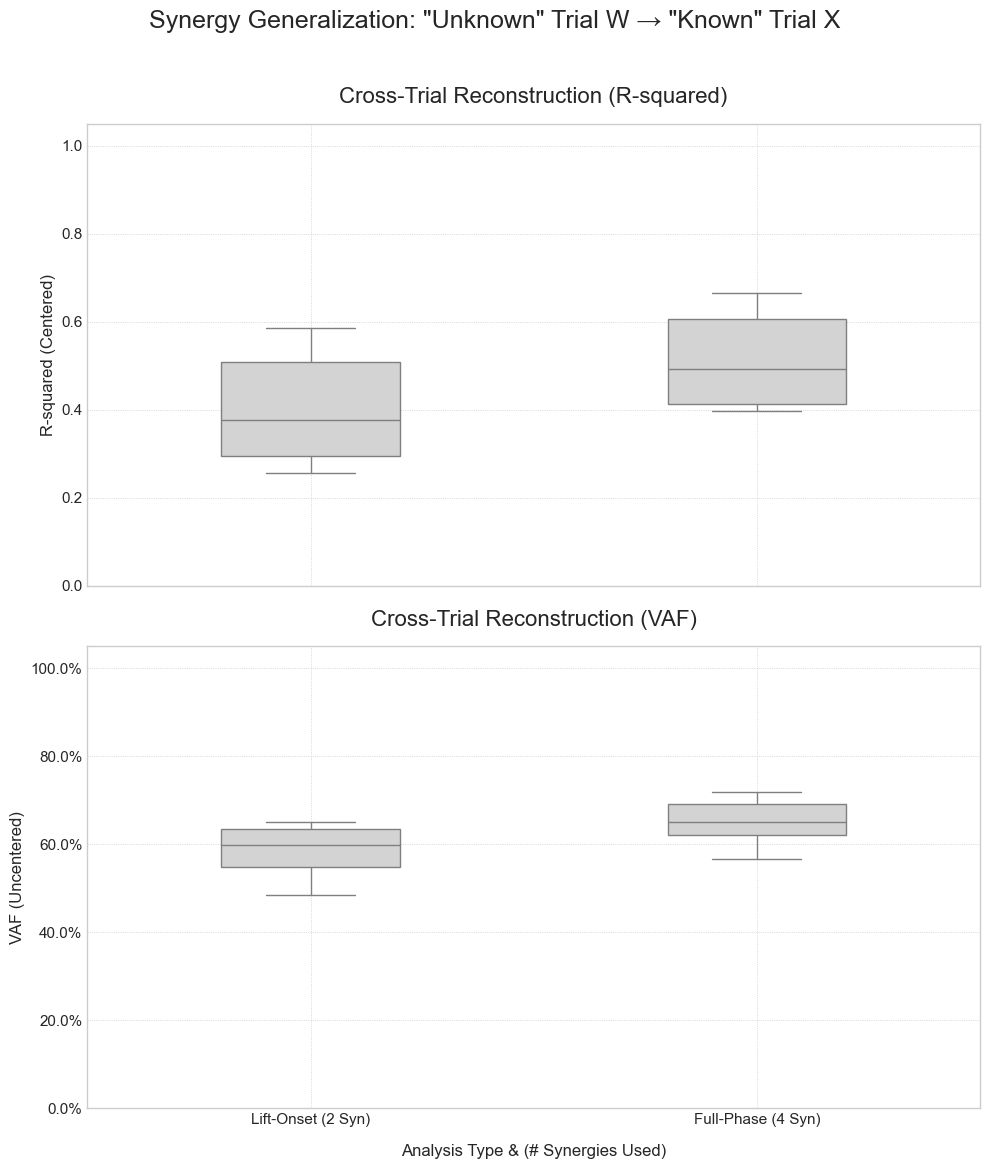

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# ==========================================================================================
# 1) GLOBAL CONFIGURATION
# ==========================================================================================

# --- Directories ---
BASE_DATA_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q1_Synergy_Analysis\Q1d_CrossTrial_Reconstruction"

# --- Participants & Synergies ---
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
N_SYNERGIES_LIFTONSET = 2
N_SYNERGIES_FULLPHASE = 4

# --- Data Loading Parameters ---
LIFTONSET_PHASE1_DURATION_S = 0.5
LIFTONSET_PHASE2_DURATION_S = 1.0
ORIGINAL_SAMPLING_RATE = 2000.0
N_POSE_COLUMNS_TO_REMOVE = 6

# --- Plotting Style ---
TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 12
TICK_LABEL_FONTSIZE = 11
SUPTITLE_FONTSIZE = 18

# ==========================================================================================
# 2) HELPER FUNCTIONS
# ==========================================================================================

def trial_info(trial_number):
    """Returns metadata about each trial."""
    protocol = {
        1:  ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Left Lever",  "No"),
        2:  ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Left Lever",  "Yes"),
        3:  ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Right Lever", "No"),
        4:  ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Right Lever", "Yes"),
        5:  ("Ball Grasp", "Ball Handle", 0.50, "Left Lever", "No"),
        6:  ("Ball Grasp", "Ball Handle", 0.50, "Left Lever", "Yes"),
        7:  ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Front Lever", "No"),
        8:  ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Front Lever", "Yes"),
        9:  ("Disc Grip", "Disc Handle", 0.50, "Back Lever", "No"),
        10: ("Disc Grip", "Disc Handle", 0.50, "Back Lever", "Yes"),
        11: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Front Lever", "No"),
        12: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Front Lever", "Yes"),
        13: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Front Lever", "No"),
        14: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Front Lever", "Yes"),
        15: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Back Lever", "No"),
        16: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Back Lever", "Yes"),
        17: ("Ball Grasp", "Ball Handle", 0.50, "Front Lever", "No"),
        18: ("Ball Grasp", "Ball Handle", 0.50, "Front Lever", "Yes"),
        19: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Back Lever", "No"),
        20: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Back Lever", "Yes"),
        21: ("Disc Grip", "Disc Handle", 0.50, "Left Lever", "No"),
        22: ("Disc Grip", "Disc Handle", 0.50, "Left Lever", "Yes"),
        23: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Right Lever", "No"),
        24: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Right Lever", "Yes"),
    }
    if trial_number not in protocol: return None
    tup = protocol[trial_number]
    return {'grasp_type': tup[0], 'handle_type': tup[1], 'weight_kg': tup[2], 'lever_side': tup[3], 'knowledge': tup[4]}

def load_synergy_w_matrix(participant_dir, trial_idx, phase_name, n_syn, analysis_type):
    """Loads the W matrix from the 'Synergies Publication 5X' directory."""
    phase_num = 1 if phase_name == "phase1" else 2
    analysis_folder = "Lift-Onset" if analysis_type == "Lift-Onset" else "Full-Phase"
    
    w_path = os.path.join(
        participant_dir, "Synergies Publication 5X", analysis_folder,
        f"Phase {phase_num}", f"{n_syn}_Syn", f"Trial_{trial_idx:02d}", "W_synergies.npy"
    )
    if os.path.exists(w_path):
        try:
            return np.load(w_path)
        except Exception as e:
            print(f"  [ERROR] Failed loading W for T{trial_idx}, {analysis_type}: {e}")
    return None

def load_original_data(participant_dir, trial_idx, phase_name, analysis_type):
    """Loads and combines OTB, Myo, and Kinematic data. Crops for Lift-Onset."""
    sync_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    kin_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_kin_norm.npy")
    myo_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_myo.npy")
    otb_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_{phase_name}_otb.npy")

    if not all(os.path.exists(f) for f in [kin_file, myo_file, otb_file]):
        return None

    try:
        kin_full, myo_full, otb_full = np.load(kin_file), np.load(myo_file), np.load(otb_file)
        
        if analysis_type == "Lift-Onset":
            crop_seconds = LIFTONSET_PHASE1_DURATION_S if phase_name == "phase1" else LIFTONSET_PHASE2_DURATION_S
            crop_samples = int(crop_seconds * ORIGINAL_SAMPLING_RATE)
            kin_data = kin_full[-crop_samples:] if phase_name == "phase1" else kin_full[:crop_samples]
            myo_data = myo_full[-crop_samples:] if phase_name == "phase1" else myo_full[:crop_samples]
            otb_data = otb_full[-crop_samples:] if phase_name == "phase1" else otb_full[:crop_samples]
        else: # Full-Phase
            kin_data, myo_data, otb_data = kin_full, myo_full, otb_full

        min_len = min(k.shape[0] for k in [kin_data, myo_data, otb_data])
        if min_len < 5: return None

        combined = np.hstack([
            otb_data[:min_len],
            myo_data[:min_len],
            kin_data[:min_len, :-N_POSE_COLUMNS_TO_REMOVE]
        ])
        return combined.T 

    except Exception as e:
        print(f"  [ERROR] Could not process original data for T({trial_idx}): {e}")
        return None

def calculate_centered_r2(X_original, X_reconstructed):
    """Calculates the global centered R-squared score."""
    if X_original is None or X_reconstructed is None or np.isnan(X_original).any() or np.isnan(X_reconstructed).any(): return np.nan
    y_true_flat, y_pred_flat = X_original.flatten(), X_reconstructed.flatten()
    if np.var(y_true_flat) < 1e-12: return 1.0 if np.allclose(y_true_flat, y_pred_flat) else 0.0
    return r2_score(y_true_flat, y_pred_flat)

def calculate_global_vaf(X_original, X_reconstructed):
    """Calculates the global uncentered Variance Accounted For (VAF)."""
    if X_original is None or X_reconstructed is None or np.isnan(X_original).any() or np.isnan(X_reconstructed).any(): return np.nan
    sse = np.sum((X_original.flatten() - X_reconstructed.flatten()) ** 2)
    sst = np.sum(X_original.flatten() ** 2)
    if sst < 1e-12: return 1.0 if sse < 1e-12 else np.nan
    return 1.0 - (sse / sst)

# ==========================================================================================
# 3) MAIN ANALYSIS SCRIPT
# ==========================================================================================

def run_reconstruction_analysis():
    """Calculates cross-trial R-squared and VAF for specific synergy levels."""
    print("Starting Specific Synergy Generalization Analysis...")
    all_results = []

    for pid in PARTICIPANTS:
        participant_dir = os.path.join(BASE_DATA_DIR, f"P({pid})")
        if not os.path.isdir(participant_dir): continue
        print(f"Processing Participant {pid}...")
        
        for unknown_trial_idx in range(1, 25, 2):
            known_trial_idx = unknown_trial_idx + 1
            info_u = trial_info(unknown_trial_idx)
            info_k = trial_info(known_trial_idx)
            if not (info_u and info_k and info_u['grasp_type'] == info_k['grasp_type']):
                continue

            for phase in ["phase1", "phase2"]:
                # --- Analysis 1: Lift-Onset (2 Synergies) ---
                W_lo = load_synergy_w_matrix(participant_dir, unknown_trial_idx, phase, N_SYNERGIES_LIFTONSET, "Lift-Onset")
                X_lo = load_original_data(participant_dir, known_trial_idx, phase, "Lift-Onset")
                
                if W_lo is not None and X_lo is not None:
                    try:
                        H_cross = np.linalg.lstsq(W_lo, X_lo, rcond=None)[0]
                        X_hat = W_lo @ H_cross
                        all_results.append({'participant': pid, 'phase': phase, 'value': calculate_centered_r2(X_lo, X_hat), 'metric': 'R-squared', 'analysis_type': 'Lift-Onset (2 Syn)'})
                        all_results.append({'participant': pid, 'phase': phase, 'value': calculate_global_vaf(X_lo, X_hat), 'metric': 'VAF', 'analysis_type': 'Lift-Onset (2 Syn)'})
                    except np.linalg.LinAlgError: pass

                # --- Analysis 2: Full-Phase (4 Synergies) ---
                W_fp = load_synergy_w_matrix(participant_dir, unknown_trial_idx, phase, N_SYNERGIES_FULLPHASE, "Full-Phase")
                X_fp = load_original_data(participant_dir, known_trial_idx, phase, "Full-Phase")
                
                if W_fp is not None and X_fp is not None:
                    try:
                        H_cross = np.linalg.lstsq(W_fp, X_fp, rcond=None)[0]
                        X_hat = W_fp @ H_cross
                        all_results.append({'participant': pid, 'phase': phase, 'value': calculate_centered_r2(X_fp, X_hat), 'metric': 'R-squared', 'analysis_type': 'Full-Phase (4 Syn)'})
                        all_results.append({'participant': pid, 'phase': phase, 'value': calculate_global_vaf(X_fp, X_hat), 'metric': 'VAF', 'analysis_type': 'Full-Phase (4 Syn)'})
                    except np.linalg.LinAlgError: pass

    if not all_results:
        print("\nCRITICAL ERROR: No data processed. Check paths and file availability.")
        return

    results_df = pd.DataFrame(all_results).dropna()
    agg_df = results_df.groupby(['participant', 'analysis_type', 'metric'])['value'].mean().reset_index()

    plot_reconstruction_comparison(agg_df)

# ==========================================================================================
# 4) PLOTTING (MODIFIED)
# ==========================================================================================

def plot_reconstruction_comparison(agg_df):
    """Plots a comparison of R-squared and VAF for the two analysis types."""
    df_r2 = agg_df[agg_df['metric'] == 'R-squared']
    df_vaf = agg_df[agg_df['metric'] == 'VAF']

    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Synergy Generalization: "Unknown" Trial W → "Known" Trial X', fontsize=SUPTITLE_FONTSIZE, y=0.97)

    plot_order = ['Lift-Onset (2 Syn)', 'Full-Phase (4 Syn)']
    palette = {"Lift-Onset (2 Syn)": "lightgrey", "Full-Phase (4 Syn)": "lightgrey"}
    flier_props = dict(marker='o', markersize=4, markerfacecolor='grey', markeredgecolor='none')
    
    # --- Plot 1: R-squared Comparison ---
    sns.boxplot(data=df_r2, x='analysis_type', y='value', order=plot_order, palette=palette, 
                ax=axes[0], width=0.4, showfliers=True, flierprops=flier_props)
    axes[0].set_title('Cross-Trial Reconstruction (R-squared)', fontsize=TITLE_FONTSIZE, pad=15)
    axes[0].set_ylabel('R-squared (Centered)', fontsize=AXIS_LABEL_FONTSIZE)
    axes[0].set_ylim(bottom=min(0, df_r2['value'].min() - 0.1) if not df_r2.empty else 0, top=1.05)
    axes[0].axhline(0, color='black', linestyle='--', linewidth=0.7, alpha=0.5)

    # --- Plot 2: VAF Comparison ---
    sns.boxplot(data=df_vaf, x='analysis_type', y='value', order=plot_order, palette=palette, 
                ax=axes[1], width=0.4, showfliers=True, flierprops=flier_props)
    axes[1].set_title('Cross-Trial Reconstruction (VAF)', fontsize=TITLE_FONTSIZE, pad=15)
    axes[1].set_ylabel('VAF (Uncentered)', fontsize=AXIS_LABEL_FONTSIZE)
    axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
    axes[1].set_ylim(bottom=min(0, df_vaf['value'].min() - 0.1) if not df_vaf.empty else 0, top=1.05)

    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONTSIZE)
        ax.grid(True, which='both', linestyle=':', linewidth=0.6)
        ax.set_xlabel('')

    axes[1].set_xlabel('Analysis Type & (# Synergies Used)', fontsize=AXIS_LABEL_FONTSIZE, labelpad=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    output_path = os.path.join(OUTPUT_DIR, "Q1d_R2_VAF_CrossReconstruction_Specific_Outliers.png")
    plt.savefig(output_path, dpi=300)
    print(f"\nSuccess! Plot saved to:\n{output_path}")
    plt.show()

# ==========================================================================================
# 5) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_reconstruction_analysis()

### Question 1e: Cross Participant Reconstruction of Task specific Synergies

This script tests how well the motor patterns (synergies) from one person can describe the movements of another person. It does this by systematically using each participant as a "source" of synergies to reconstruct the data of every other "target" participant.

Here is the step-by-step process for a single trial:

**Select a "Target" and "Source":**
The code picks one participant to be the Target (e.g., P(2)).It then picks a different participant to be the Source (e.g., P(1)).

**Load Data:**
It loads the synergy vectors (W matrix) from the Source participant (P(1)). These represent P(1)'s fundamental motor patterns.
It loads the original trial data (X matrix) from the Target participant (P(2)).

**Find New Activation Coefficients:**
The reconstruction is finding a new set of activation coefficients (H_new).
The script uses a linear least-squares method (np.linalg.lstsq) to solve the equation: W_source @ H_new ≈ X_target.
This finds the best possible H_new that explains the Target's data using the Source's building blocks.

**Reconstruct and Evaluate:**
It calculates the reconstructed data: X_reconstructed = W_source @ H_new.
It then computes the VAF between the Target's original data (X_target) and the X_reconstructed. This single VAF score measures how well P(1)'s synergies could explain P(2)'s movements for that specific trial.

**Aggregate and Average:**
This process is repeated for all possible Source -> Target pairs, trials, and phases.
The final value plotted for each target participant is the average VAF they achieved from all other source participants, providing a robust measure of inter-subject generalization.

In [10]:
import os
import gc
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================================================================
# 1) GLOBAL CONFIGURATION
# ==========================================================================================
BASE_DATA_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_DIR = os.path.join(
    r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper",
    r"Q1_Synergy_Analysis\Q1e_CrossParticipant_Reconstruction"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
# MODIFIED: Define specific synergy levels for each analysis type
N_SYNERGIES_LIFTONSET = 2
N_SYNERGIES_FULLPHASE = 4

SAMPLING_RATE = 2000.0
PRE_LIFT_SAMPLES = int(0.5 * SAMPLING_RATE)
POST_LIFT_SAMPLES = int(1.0 * SAMPLING_RATE)
DTYPE = np.float32

TITLE_FONTSIZE = 16
AXIS_LABEL_FONTSIZE = 12
TICK_LABEL_FONTSIZE = 11
SUPTITLE_FONTSIZE = 18

# ==========================================================================================
# 2) HELPERS
# ==========================================================================================

# --- Functions for LIFT-ONSET analysis ---
def load_liftonset_w_matrix(participant_dir: str, trial_idx: int, phase: str):
    """Load W for Lift-Onset from the 'Synergies Publication 5X' folder."""
    phase_num = 1 if phase == "phase1" else 2
    folder = os.path.join(
        participant_dir, "Synergies Publication 5X", "Lift-Onset",
        f"Phase {phase_num}", f"{N_SYNERGIES_LIFTONSET}_Syn", f"Trial_{trial_idx:02d}",
    )
    w_path = os.path.join(folder, "W_synergies.npy")
    return np.load(w_path).astype(DTYPE) if os.path.exists(w_path) else None

def load_liftonset_segment(participant_dir: str, trial_idx: int, phase: str, p_maps):
    """Loads and crops the specified lift-onset data segment for a trial."""
    pid = int(os.path.basename(participant_dir).lstrip("P(").rstrip(")"))
    pre_dir = os.path.join(participant_dir, "Preprocessed_Data_Matrix")
    p1_map, p2_map = p_maps
    
    mat_path = os.path.join(pre_dir, f"P{pid}_combined_matrix_{phase}.npy")
    if not os.path.exists(mat_path): return None
        
    phase_mat = np.load(mat_path, mmap_mode="r").astype(DTYPE)
    
    if phase == "phase1":
        row_slice = p1_map.get(trial_idx)
        if not row_slice or phase_mat[row_slice].shape[0] < PRE_LIFT_SAMPLES: return None
        segment = phase_mat[row_slice][-PRE_LIFT_SAMPLES:]
    else: # phase2
        row_slice = p2_map.get(trial_idx)
        if not row_slice or phase_mat[row_slice].shape[0] < POST_LIFT_SAMPLES: return None
        segment = phase_mat[row_slice][:POST_LIFT_SAMPLES]
        
    return segment.T  # features × samples

# --- ADDED: Functions for FULL-PHASE analysis ---
def load_fullphase_w_matrix(participant_dir: str, trial_idx: int, phase: str):
    """Load W for Full-Phase from the 'Synergies Publication 5X' folder."""
    phase_num = 1 if phase == "phase1" else 2
    folder = os.path.join(
        participant_dir, "Synergies Publication 5X", "Full-Phase",
        f"Phase {phase_num}", f"{N_SYNERGIES_FULLPHASE}_Syn", f"Trial_{trial_idx:02d}",
    )
    w_path = os.path.join(folder, "W_synergies.npy")
    return np.load(w_path).astype(DTYPE) if os.path.exists(w_path) else None

def load_fullphase_segment(participant_dir: str, trial_idx: int, phase: str, p_maps):
    """Loads the full, un-clipped data segment for a trial."""
    pid = int(os.path.basename(participant_dir).lstrip("P(").rstrip(")"))
    pre_dir = os.path.join(participant_dir, "Preprocessed_Data_Matrix")
    p1_map, p2_map = p_maps

    mat_path = os.path.join(pre_dir, f"P{pid}_combined_matrix_{phase}.npy")
    if not os.path.exists(mat_path): return None
        
    phase_mat = np.load(mat_path, mmap_mode="r").astype(DTYPE)
    
    row_slice = p1_map.get(trial_idx) if phase == "phase1" else p2_map.get(trial_idx)
    if row_slice is None: return None
        
    return phase_mat[row_slice].T # features × samples

# --- Common helper functions ---
_row_cache = {}
def _get_maps(pid: int, pre_dir: str):
    """Builds and caches trial-to-row-slice maps from metadata."""
    if pid in _row_cache: return _row_cache[pid]

    idx_path = os.path.join(pre_dir, f"P{pid}_feature_indices.joblib")
    if not os.path.exists(idx_path):
        _row_cache[pid] = (None, None, 0)
        return None, None, 0
    
    idx_data = joblib.load(idx_path)
    p1_lengths = idx_data.get("phase1_trial_lengths", [])
    p2_lengths = idx_data.get("phase2_trial_lengths", [])
    
    skip_list = [20, 22] if pid == 7 else []
    valid_trials = [t for t in range(1, 25) if t not in skip_list]

    if len(p1_lengths) != len(valid_trials) or len(p2_lengths) != len(valid_trials):
         _row_cache[pid] = (None, None, 0)
         return None, None, 0
    
    p1_map, p2_map = {}, {}
    r1 = r2 = 0
    for t, l1, l2 in zip(valid_trials, p1_lengths, p2_lengths):
        p1_map[t] = slice(r1, r1 + l1)
        p2_map[t] = slice(r2, r2 + l2)
        r1 += l1
        r2 += l2
    
    _row_cache[pid] = ((p1_map, p2_map), len(valid_trials))
    return (p1_map, p2_map), len(valid_trials)

def calculate_global_vaf(orig: np.ndarray, recon: np.ndarray):
    """Calculates global Variance Accounted For (VAF)."""
    if orig is None or recon is None: return np.nan
    sse = np.sum((orig - recon) ** 2)
    sst = np.sum(orig ** 2)
    return np.nan if sst < 1e-12 else 1.0 - sse / sst

# ==========================================================================================
# 3) MAIN ANALYSIS (MODIFIED)
# ==========================================================================================

def run_cross_participant_analysis():
    """Main function for cross-participant reconstruction analysis."""
    rows = []

    for pid_tgt in PARTICIPANTS:
        tgt_dir = os.path.join(BASE_DATA_DIR, f"P({pid_tgt})")
        if not os.path.isdir(tgt_dir): continue
        print(f"Target: P({pid_tgt})")
        
        tgt_maps, num_trials_tgt = _get_maps(pid_tgt, os.path.join(tgt_dir, "Preprocessed_Data_Matrix"))
        if num_trials_tgt == 0: continue

        for pid_src in PARTICIPANTS:
            if pid_src == pid_tgt: continue
            src_dir = os.path.join(BASE_DATA_DIR, f"P({pid_src})")
            if not os.path.isdir(src_dir): continue

            src_maps, num_trials_src = _get_maps(pid_src, os.path.join(src_dir, "Preprocessed_Data_Matrix"))
            if num_trials_src == 0: continue
            
            # Use all available trials for each participant
            for trial in range(1, 25):
                for phase in ("phase1", "phase2"):
                    
                    # --- Analysis 1: Lift-Onset (2 Synergies) ---
                    W_lo = load_liftonset_w_matrix(src_dir, trial, phase)
                    X_lo = load_liftonset_segment(tgt_dir, trial, phase, tgt_maps)
                    
                    if W_lo is not None and X_lo is not None and W_lo.shape[0] == X_lo.shape[0]:
                        try:
                            H = np.linalg.lstsq(W_lo, X_lo, rcond=None)[0]
                            vaf = calculate_global_vaf(X_lo, W_lo @ H)
                            if not np.isnan(vaf):
                                rows.append({
                                    "target": pid_tgt, "source": pid_src, "trial": trial,
                                    "phase": phase, "vaf": vaf, 
                                    "analysis_type": "Lift-Onset (2 Syn)"
                                })
                        except np.linalg.LinAlgError: pass

                    # --- Analysis 2: Full-Phase (4 Synergies) ---
                    W_fp = load_fullphase_w_matrix(src_dir, trial, phase)
                    X_fp = load_fullphase_segment(tgt_dir, trial, phase, tgt_maps)

                    if W_fp is not None and X_fp is not None and W_fp.shape[0] == X_fp.shape[0]:
                        try:
                            H = np.linalg.lstsq(W_fp, X_fp, rcond=None)[0]
                            vaf = calculate_global_vaf(X_fp, W_fp @ H)
                            if not np.isnan(vaf):
                                rows.append({
                                    "target": pid_tgt, "source": pid_src, "trial": trial,
                                    "phase": phase, "vaf": vaf,
                                    "analysis_type": "Full-Phase (4 Syn)"
                                })
                        except np.linalg.LinAlgError: pass
            gc.collect()

    if not rows:
        print("No data was processed. Exiting.")
        return

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(OUTPUT_DIR, "cross_participant_vaf_specific_raw.csv"), index=False)

    # Aggregate: mean VAF per target participant & analysis type
    df_mean = df.groupby(["target", "analysis_type"])["vaf"].mean().reset_index()
    plot_comparison(df_mean)


# ======================================================================================
# 4) PLOT (MODIFIED)
# ======================================================================================
def plot_comparison(df_mean: pd.DataFrame):
    """Plots the VAF comparison between Lift-Onset and Full-Phase analyses."""
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(10, 7))
    
    sns.boxplot(
        data=df_mean, x="analysis_type", y="vaf", ax=ax,
        palette=["#4F81BD", "#C0504D"],
        order=["Lift-Onset (2 Syn)", "Full-Phase (4 Syn)"],
        medianprops={"color": "black", "linewidth": 1.5},
        showfliers=True, width=0.5
    )
    
    ax.set_title("Cross-Participant Synergy Generalization (VAF)", fontsize=SUPTITLE_FONTSIZE, weight='bold')
    ax.set_xlabel("Analysis Type (# Synergies)", fontsize=AXIS_LABEL_FONTSIZE, labelpad=10)
    ax.set_ylabel("Mean VAF (across all source participants)", fontsize=AXIS_LABEL_FONTSIZE)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))
    ax.tick_params(axis="both", labelsize=TICK_LABEL_FONTSIZE)
    ax.grid(True, which='both', linestyle=":", linewidth=0.7)
    plt.tight_layout()

    out_img = os.path.join(OUTPUT_DIR, "Q1e_VAF_Cross_Participant_Comparison.png")
    plt.savefig(out_img, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to {out_img}")
    plt.show()

# ==========================================================================================
# 5) EXECUTION
# ==========================================================================================
if __name__ == "__main__":
    run_cross_participant_analysis()
    print("\n--- Script finished ---")

Target: P(1)
Target: P(2)


KeyboardInterrupt: 

### Question 2: Task Knowledge Boxplots merged in one Plot for all Pairs and Pair 4 & 5

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_rel
import seaborn as sns

# ----------------------------------------------------------------------
# 1) Configuration
# ----------------------------------------------------------------------
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_ROOT = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
# Specific output directory for this analysis
OUTPUT_DIR = os.path.join(OUTPUT_ROOT, "Q2_Task_Knowledge")
os.makedirs(OUTPUT_DIR, exist_ok=True)

PARTICIPANTS      = [1, 2, 3, 4, 5, 6, 7, 8]
PHASES            = ["phase1", "phase2"]
EXCLUDED_TRIALS   = {7: [20, 22]}  # Asynchronous recordings for P7

# --- Set the required number of synergies for each window ---
FULLPHASE_SYNS    = 4  # Enforce 4 synergies for Full Phase
LIFTONSET_SYNS    = 2  # Enforce 2 synergies for Lift-Onset

# -- Figure aesthetics for publication quality --------------------------
TITLE_FS   = 20
AXIS_FS    = 18
TICK_FS    = 16
LEGEND_FS  = 14
LEGEND_TFS = 15
BRACKET_FS = 18

# ----------------------------------------------------------------------
# 2) Helper: Trial metadata and significance stars
# ----------------------------------------------------------------------
def trial_info(trial):
    """Returns a dictionary with trial metadata based on trial number."""
    tbl = {
        1: ("Pinch","H1",0.25,"L","No"),      2: ("Pinch","H1",0.25,"L","Yes"),
        3: ("Lateral","H2",0.25,"R","No"),    4: ("Lateral","H2",0.25,"R","Yes"),
        5: ("Ball","H3",0.50,"L","No"),       6: ("Ball","H3",0.50,"L","Yes"),
        7: ("ThumbIdx","H1",0.25,"F","No"),   8: ("ThumbIdx","H1",0.25,"F","Yes"),
        9: ("Disc","H4",0.50,"B","No"),      10: ("Disc","H4",0.50,"B","Yes"),
        11:("Power","H5",0.50,"F","No"),     12:("Power","H5",0.50,"F","Yes"),
        13:("Pinch4F","H1",0.25,"F","No"),   14:("Pinch4F","H1",0.25,"F","Yes"),
        15:("Lateral","H2",0.25,"B","No"),   16:("Lateral","H2",0.25,"B","Yes"),
        17:("Ball","H3",0.50,"F","No"),      18:("Ball","H3",0.50,"F","Yes"),
        19:("ThumbIdx","H1",0.25,"B","No"),  20:("ThumbIdx","H1",0.25,"B","Yes"),
        21:("Disc","H4",0.50,"L","No"),      22:("Disc","H4",0.50,"L","Yes"),
        23:("Power","H5",0.50,"R","No"),     24:("Power","H5",0.50,"R","Yes"),
    }
    if trial not in tbl: return None
    g,h,w,l,k = tbl[trial]
    return {'grasp_type': g, 'handle_type': h, 'weight_kg': w,
            'lever_side': l, 'condition': "Known" if k=="Yes" else "Unknown"}

def stars(p):
    """Converts a p-value to significance stars."""
    if   p < 0.001: return '***'
    elif p < 0.01 : return '**'
    elif p < 0.05 : return '*'
    return 'ns'

# ----------------------------------------------------------------------
# 3) Synergy Loaders (Corrected for Final File Structure)
# ----------------------------------------------------------------------
DTYPE = np.float32

def _trim_cols(W, n_required):
    """Helper to return first n_required columns; None if insufficient."""
    if W is None or W.shape[1] < n_required:
        return None
    return W[:, :n_required].astype(DTYPE)

def load_W_fullphase(p_dir, trial, phase):
    """
    Loads W matrix from the 'Full-Phase' synergy directory.
    CORRECTED to use 'Synergies Publication 5X' and 'Full-Phase'.
    """
    try:
        phase_folder = f"Phase {phase[-1]}"
        syn_folder = f"{FULLPHASE_SYNS}_Syn"
        trial_folder = f"Trial_{trial:02d}"
        path = os.path.join(p_dir, "Synergies Publication 5X", "Full-Phase",
                            phase_folder, syn_folder, trial_folder, "W_synergies.npy")
        if not os.path.exists(path): return None
        return _trim_cols(np.load(path), FULLPHASE_SYNS)
    except Exception:
        return None

def load_W_liftonset(p_dir, trial, phase):
    """
    Loads W matrix from the 'Lift-Onset' directory.
    CORRECTED to use 'Synergies Publication 5X' and 'Lift-Onset'.
    """
    try:
        phase_folder = f"Phase {phase[-1]}"
        syn_folder = f"{LIFTONSET_SYNS}_Syn"
        trial_folder = f"Trial_{trial:02d}"
        path = os.path.join(p_dir, "Synergies Publication 5X", "Lift-Onset",
                            phase_folder, syn_folder, trial_folder, "W_synergies.npy")
        if not os.path.exists(path): return None
        return _trim_cols(np.load(path), LIFTONSET_SYNS)
    except Exception:
        return None

# ----------------------------------------------------------------------
# 4) Core Utilities for Synergy Matching
# ----------------------------------------------------------------------
def cosine_sim(a,b):
    """Calculates cosine similarity between two vectors."""
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    if denom < 1e-12: return np.nan
    return np.clip(np.dot(a, b) / denom, -1.0, 1.0)

def match_synergies_greedy(W1, W2):
    """Matches synergies between W1 and W2 using a greedy algorithm, ordered best to worst."""
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    n1, n2 = W1.shape[1], W2.shape[1]
    unmatched1, unmatched2 = list(range(n1)), list(range(n2))
    pairs = []
    for _ in range(min(n1, n2)):
        best_sim, best_pair = -np.inf, None
        for i in unmatched1:
            for j in unmatched2:
                s = cosine_sim(W1[:, i], W2[:, j])
                if not np.isnan(s) and s > best_sim:
                    best_sim, best_pair = s, (i, j)
        if best_pair is None: break
        pairs.append(best_pair)
        unmatched1.remove(best_pair[0])
        unmatched2.remove(best_pair[1])
    return pairs  # Pairs are ordered from most similar to least similar

# ----------------------------------------------------------------------
# 5) Analysis and Plotting
# ----------------------------------------------------------------------
def add_bracket(ax, x1, x2, y, h, label):
    """Adds a significance bracket to a plot."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)/2, y+h+0.01, label, ha='center', va='bottom',
            fontsize=BRACKET_FS, color='black')

def analyze_and_plot():
    """
    Calculates and plots synergy correlations for 'All Pairs' vs. the single 'Weakest Pair'.
    """
    rows = []
    print("📈 [INFO] Computing correlations for all trials...")
    for pid in PARTICIPANTS:
        p_dir = os.path.join(BASE_DIR, f"P({pid})")
        if not os.path.isdir(p_dir):
            print(f"⚠️ Warning: Participant directory not found: {p_dir}")
            continue

        skip = EXCLUDED_TRIALS.get(pid, [])
        for trial in range(1, 25):
            if trial in skip: continue
            meta = trial_info(trial)
            if meta is None: continue
            cond = meta['condition']

            for window, loader in [('Full Phase', load_W_fullphase),
                                   ('Lift-Onset', load_W_liftonset)]:
                W1 = loader(p_dir, trial, "phase1")
                W2 = loader(p_dir, trial, "phase2")
                if W1 is None or W2 is None: continue

                pairs = match_synergies_greedy(W1, W2)
                if not pairs: continue

                # --- Subset 1: All matched pairs ---
                corrs_all = [pearsonr(W1[:,i], W2[:,j])[0] for i,j in pairs if np.std(W1[:,i]) > 1e-9 and np.std(W2[:,j]) > 1e-9]
                if corrs_all:
                    rows.append({'participant': pid, 'condition': cond, 'window': window,
                                 'subset': 'All Pairs', 'corr': np.nanmean(corrs_all)})

                # --- Subset 2: The single weakest matched pair ---
                weakest_pair = [pairs[-1]] # The greedy algorithm puts the worst match last
                corrs_weak = [pearsonr(W1[:,i], W2[:,j])[0] for i,j in weakest_pair if np.std(W1[:,i]) > 1e-9 and np.std(W2[:,j]) > 1e-9]
                if corrs_weak:
                    rows.append({'participant': pid, 'condition': cond, 'window': window,
                                 'subset': 'Weakest Pair', 'corr': np.nanmean(corrs_weak)})

    if not rows:
        print("❌ [ERROR] No valid data found. Check synergy file paths and contents.")
        return

    df = pd.DataFrame(rows)
    agg = df.groupby(['participant', 'window', 'condition', 'subset'])['corr'].mean().reset_index()

    # --------------- Plotting ----------------------------------------
    print("🎨 [INFO] Generating the final plot...")
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
    palette = {"Unknown": "lightgrey", "Known": "#A9A9A9"}

    # Define the two panels for the plot
    panels = [('All Pairs', 'All Matched Synergy Pairs'),
              ('Weakest Pair', 'Weakest Matched Synergy Pair')]

    for ax, (subset, title) in zip(axes, panels):
        sub_df = agg[agg['subset'] == subset]
        sns.boxplot(ax=ax, x='window', y='corr', hue='condition', data=sub_df,
                    palette=palette, showfliers=True, width=0.6,
                    order=['Full Phase', 'Lift-Onset'], hue_order=['Unknown', 'Known'],
                    medianprops={'linewidth': 1.5, 'color': 'black', 'alpha': 0.8})

        ax.set_title(title, fontsize=TITLE_FS, pad=15)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis='x', labelsize=TICK_FS)
        ax.tick_params(axis='y', labelsize=TICK_FS)
        if ax.get_legend(): ax.get_legend().remove()

        # --- Significance brackets ---
        ymax_plot = sub_df['corr'].dropna().max()
        h = 0.02
        y1 = ymax_plot + 0.05
        y2 = y1 + h + 0.08

        # Within-window comparison (Known vs Unknown)
        for xpos, window_name in zip([-0.15, 0.85], ['Full Phase', 'Lift-Onset']):
            data_window = sub_df[sub_df['window'] == window_name]
            pivoted = data_window.pivot(index='participant', columns='condition', values='corr').dropna()
            if len(pivoted) >= 2:
                _, p = ttest_rel(pivoted['Known'], pivoted['Unknown'], nan_policy='omit')
                add_bracket(ax, xpos, xpos + 0.3, y1, h, stars(p))

        # Overall window comparison (Full Phase vs Lift-Onset)
        fp = sub_df[sub_df['window'] == 'Full Phase'].groupby('participant')['corr'].mean()
        lo = sub_df[sub_df['window'] == 'Lift-Onset'].groupby('participant')['corr'].mean()
        combined = pd.merge(fp.rename('FP'), lo.rename('LO'), left_index=True, right_index=True)
        if len(combined) >= 2:
            _, p = ttest_rel(combined['FP'], combined['LO'], nan_policy='omit')
            add_bracket(ax, 0, 1, y2, h, stars(p))

    # --- Final Figure Aesthetics ---
    fig.supylabel("Mean Pearson Correlation", fontsize=AXIS_FS, x=0.015)
    fig.supxlabel("Synergy Extraction Window", fontsize=AXIS_FS)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Condition",
               fontsize=LEGEND_FS, title_fontsize=LEGEND_TFS,
               loc='lower right', bbox_to_anchor=(0.98, 0.18),
               frameon=True, edgecolor='gray')

    fig.suptitle("Impact of Task Knowledge on Inter-Phase Synergy Correlation",
                 fontsize=TITLE_FS + 2, y=0.98)

    # MODIFIED: Set y-axis limit to 1.2 for more space
    plt.ylim(0.0, 1.2)
    # Set explicit y-ticks to hide labels above 1.0
    axes[0].set_yticks(np.arange(0.0, 1.1, 0.2))

    plt.tight_layout(rect=[0.04, 0.05, 1, 0.95])

    out_png = "q2_Inter-Phase_Synergy_Correlation_weakest_Pair.png"
    save_path = os.path.join(OUTPUT_DIR, out_png)
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"✅ [INFO] Plot saved successfully with final layout!\nPath: {save_path}")

# ---------------------------------------------------------------------
# 6) Run the Analysis
# ---------------------------------------------------------------------
if __name__ == "__main__":
    analyze_and_plot()

📈 [INFO] Computing correlations for all trials...
🎨 [INFO] Generating the final plot...
✅ [INFO] Plot saved successfully with final layout!
Path: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q2_Task_Knowledge\q2_Inter-Phase_Synergy_Correlation_Final_Layout_V2.png


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_rel
import seaborn as sns

# ----------------------------------------------------------------------
# 1) Configuration
# ----------------------------------------------------------------------
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
OUTPUT_ROOT = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
# Specific output directory for this analysis
OUTPUT_DIR = os.path.join(OUTPUT_ROOT, "Q2_Task_Knowledge")
os.makedirs(OUTPUT_DIR, exist_ok=True)

PARTICIPANTS      = [1, 2, 3, 4, 5, 6, 7, 8]
PHASES            = ["phase1", "phase2"]
EXCLUDED_TRIALS   = {7: [20, 22]}  # Asynchronous recordings for P7

# --- Set the required number of synergies for each window ---
FULLPHASE_SYNS    = 4  # Enforce 4 synergies for Full Phase
LIFTONSET_SYNS    = 2  # Enforce 2 synergies for Lift-Onset

# -- Figure aesthetics for publication quality --------------------------
TITLE_FS   = 20
AXIS_FS    = 18
TICK_FS    = 16
LEGEND_FS  = 14
LEGEND_TFS = 15
BRACKET_FS = 18

# ----------------------------------------------------------------------
# 2) Helper: Trial metadata and significance stars
# ----------------------------------------------------------------------
def trial_info(trial):
    """Returns a dictionary with trial metadata based on trial number."""
    tbl = {
        1: ("Pinch","H1",0.25,"L","No"),      2: ("Pinch","H1",0.25,"L","Yes"),
        3: ("Lateral","H2",0.25,"R","No"),    4: ("Lateral","H2",0.25,"R","Yes"),
        5: ("Ball","H3",0.50,"L","No"),       6: ("Ball","H3",0.50,"L","Yes"),
        7: ("ThumbIdx","H1",0.25,"F","No"),   8: ("ThumbIdx","H1",0.25,"F","Yes"),
        9: ("Disc","H4",0.50,"B","No"),      10: ("Disc","H4",0.50,"B","Yes"),
        11:("Power","H5",0.50,"F","No"),     12:("Power","H5",0.50,"F","Yes"),
        13:("Pinch4F","H1",0.25,"F","No"),   14:("Pinch4F","H1",0.25,"F","Yes"),
        15:("Lateral","H2",0.25,"B","No"),   16:("Lateral","H2",0.25,"B","Yes"),
        17:("Ball","H3",0.50,"F","No"),      18:("Ball","H3",0.50,"F","Yes"),
        19:("ThumbIdx","H1",0.25,"B","No"),  20:("ThumbIdx","H1",0.25,"B","Yes"),
        21:("Disc","H4",0.50,"L","No"),      22:("Disc","H4",0.50,"L","Yes"),
        23:("Power","H5",0.50,"R","No"),     24:("Power","H5",0.50,"R","Yes"),
    }
    if trial not in tbl: return None
    g,h,w,l,k = tbl[trial]
    return {'grasp_type': g, 'handle_type': h, 'weight_kg': w,
            'lever_side': l, 'condition': "Known" if k=="Yes" else "Unknown"}

def stars(p):
    """Converts a p-value to significance stars."""
    if   p < 0.001: return '***'
    elif p < 0.01 : return '**'
    elif p < 0.05 : return '*'
    return 'ns'

# ----------------------------------------------------------------------
# 3) Synergy Loaders (Corrected for Final File Structure)
# ----------------------------------------------------------------------
DTYPE = np.float32

def _trim_cols(W, n_required):
    """Helper to return first n_required columns; None if insufficient."""
    if W is None or W.shape[1] < n_required:
        return None
    return W[:, :n_required].astype(DTYPE)

def load_W_fullphase(p_dir, trial, phase):
    """
    Loads W matrix from the 'Full-Phase' synergy directory.
    """
    try:
        phase_folder = f"Phase {phase[-1]}"
        syn_folder = f"{FULLPHASE_SYNS}_Syn"
        trial_folder = f"Trial_{trial:02d}"
        path = os.path.join(p_dir, "Synergies Publication 5X", "Full-Phase",
                            phase_folder, syn_folder, trial_folder, "W_synergies.npy")
        if not os.path.exists(path): return None
        return _trim_cols(np.load(path), FULLPHASE_SYNS)
    except Exception:
        return None

def load_W_liftonset(p_dir, trial, phase):
    """
    Loads W matrix from the 'Lift-Onset' directory.
    """
    try:
        phase_folder = f"Phase {phase[-1]}"
        syn_folder = f"{LIFTONSET_SYNS}_Syn"
        trial_folder = f"Trial_{trial:02d}"
        path = os.path.join(p_dir, "Synergies Publication 5X", "Lift-Onset",
                            phase_folder, syn_folder, trial_folder, "W_synergies.npy")
        if not os.path.exists(path): return None
        return _trim_cols(np.load(path), LIFTONSET_SYNS)
    except Exception:
        return None

# ----------------------------------------------------------------------
# 4) Core Utilities for Synergy Matching
# ----------------------------------------------------------------------
def cosine_sim(a,b):
    """Calculates cosine similarity between two vectors."""
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    if denom < 1e-12: return np.nan
    return np.clip(np.dot(a, b) / denom, -1.0, 1.0)

def match_synergies_greedy(W1, W2):
    """Matches synergies between W1 and W2 using a greedy algorithm, ordered best to worst."""
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]: return []
    n1, n2 = W1.shape[1], W2.shape[1]
    unmatched1, unmatched2 = list(range(n1)), list(range(n2))
    pairs = []
    for _ in range(min(n1, n2)):
        best_sim, best_pair = -np.inf, None
        for i in unmatched1:
            for j in unmatched2:
                s = cosine_sim(W1[:, i], W2[:, j])
                if not np.isnan(s) and s > best_sim:
                    best_sim, best_pair = s, (i, j)
        if best_pair is None: break
        pairs.append(best_pair)
        unmatched1.remove(best_pair[0])
        unmatched2.remove(best_pair[1])
    return pairs

# ----------------------------------------------------------------------
# 5) Analysis and Plotting
# ----------------------------------------------------------------------
def add_bracket(ax, x1, x2, y, h, label):
    """Adds a significance bracket to a plot."""
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)/2, y+h+0.01, label, ha='center', va='bottom',
            fontsize=BRACKET_FS, color='black')

def analyze_and_plot():
    """
    Calculates and plots synergy correlations for 'All Pairs' vs. the single 'Strongest Pair'.
    """
    rows = []
    print("📈 [INFO] Computing correlations for all trials...")
    for pid in PARTICIPANTS:
        p_dir = os.path.join(BASE_DIR, f"P({pid})")
        if not os.path.isdir(p_dir):
            print(f"⚠️ Warning: Participant directory not found: {p_dir}")
            continue

        skip = EXCLUDED_TRIALS.get(pid, [])
        for trial in range(1, 25):
            if trial in skip: continue
            meta = trial_info(trial)
            if meta is None: continue
            cond = meta['condition']

            for window, loader in [('Full Phase', load_W_fullphase),
                                   ('Lift-Onset', load_W_liftonset)]:
                W1 = loader(p_dir, trial, "phase1")
                W2 = loader(p_dir, trial, "phase2")
                if W1 is None or W2 is None: continue

                pairs = match_synergies_greedy(W1, W2)
                if not pairs: continue

                # --- Subset 1: All matched pairs ---
                corrs_all = [pearsonr(W1[:,i], W2[:,j])[0] for i,j in pairs if np.std(W1[:,i]) > 1e-9 and np.std(W2[:,j]) > 1e-9]
                if corrs_all:
                    rows.append({'participant': pid, 'condition': cond, 'window': window,
                                 'subset': 'All Pairs', 'corr': np.nanmean(corrs_all)})

                # --- MODIFIED: Subset 2 is now the single strongest matched pair ---
                strongest_pair = [pairs[0]] # The greedy algorithm puts the best match first
                corrs_strong = [pearsonr(W1[:,i], W2[:,j])[0] for i,j in strongest_pair if np.std(W1[:,i]) > 1e-9 and np.std(W2[:,j]) > 1e-9]
                if corrs_strong:
                    rows.append({'participant': pid, 'condition': cond, 'window': window,
                                 'subset': 'Strongest Pair', 'corr': np.nanmean(corrs_strong)})

    if not rows:
        print("❌ [ERROR] No valid data found. Check synergy file paths and contents.")
        return

    df = pd.DataFrame(rows)
    agg = df.groupby(['participant', 'window', 'condition', 'subset'])['corr'].mean().reset_index()

    # --------------- Plotting ----------------------------------------
    print("🎨 [INFO] Generating the final plot...")
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 9), sharey=True)
    palette = {"Unknown": "lightgrey", "Known": "#A9A9A9"}

    # MODIFIED: Define the two panels for the new plot
    panels = [('All Pairs', 'All Matched Synergy Pairs'),
              ('Strongest Pair', 'Strongest Matched Synergy Pair')]

    for ax, (subset, title) in zip(axes, panels):
        sub_df = agg[agg['subset'] == subset]
        sns.boxplot(ax=ax, x='window', y='corr', hue='condition', data=sub_df,
                    palette=palette, showfliers=True, width=0.6,
                    order=['Full Phase', 'Lift-Onset'], hue_order=['Unknown', 'Known'],
                    medianprops={'linewidth': 1.5, 'color': 'black', 'alpha': 0.8})

        ax.set_title(title, fontsize=TITLE_FS, pad=15)
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.tick_params(axis='x', labelsize=TICK_FS)
        ax.tick_params(axis='y', labelsize=TICK_FS)
        if ax.get_legend(): ax.get_legend().remove()

        # --- Significance brackets ---
        ymax_plot = sub_df['corr'].dropna().max()
        h = 0.02
        y1 = ymax_plot + 0.05
        y2 = y1 + h + 0.08

        # Within-window comparison (Known vs Unknown)
        for xpos, window_name in zip([-0.15, 0.85], ['Full Phase', 'Lift-Onset']):
            data_window = sub_df[sub_df['window'] == window_name]
            pivoted = data_window.pivot(index='participant', columns='condition', values='corr').dropna()
            if len(pivoted) >= 2:
                _, p = ttest_rel(pivoted['Known'], pivoted['Unknown'], nan_policy='omit')
                add_bracket(ax, xpos, xpos + 0.3, y1, h, stars(p))

        # Overall window comparison (Full Phase vs Lift-Onset)
        fp = sub_df[sub_df['window'] == 'Full Phase'].groupby('participant')['corr'].mean()
        lo = sub_df[sub_df['window'] == 'Lift-Onset'].groupby('participant')['corr'].mean()
        combined = pd.merge(fp.rename('FP'), lo.rename('LO'), left_index=True, right_index=True)
        if len(combined) >= 2:
            _, p = ttest_rel(combined['FP'], combined['LO'], nan_policy='omit')
            add_bracket(ax, 0, 1, y2, h, stars(p))

    # --- Final Figure Aesthetics ---
    fig.supylabel("Mean Pearson Correlation", fontsize=AXIS_FS, x=0.015)
    fig.supxlabel("Synergy Extraction Window", fontsize=AXIS_FS)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title="Condition",
               fontsize=LEGEND_FS, title_fontsize=LEGEND_TFS,
               loc='lower right', bbox_to_anchor=(0.98, 0.18),
               frameon=True, edgecolor='gray')

    fig.suptitle("Impact of Task Knowledge on Inter-Phase Synergy Correlation",
                 fontsize=TITLE_FS + 2, y=0.98)

    plt.ylim(0.0, 1.2)
    axes[0].set_yticks(np.arange(0.0, 1.1, 0.2))

    plt.tight_layout(rect=[0.04, 0.05, 1, 0.95])

    # MODIFIED: New output filename
    out_png = "q2_Inter-Phase_Synergy_Correlation_StrongestPair.png"
    save_path = os.path.join(OUTPUT_DIR, out_png)
    plt.savefig(save_path, dpi=300)
    plt.close()
    print(f"✅ [INFO] Plot saved successfully with 'Strongest Pair' analysis!\nPath: {save_path}")

# ---------------------------------------------------------------------
# 6) Run the Analysis
# ---------------------------------------------------------------------
if __name__ == "__main__":
    analyze_and_plot()

📈 [INFO] Computing correlations for all trials...
🎨 [INFO] Generating the final plot...
✅ [INFO] Plot saved successfully with 'Strongest Pair' analysis!
Path: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q2_Task_Knowledge\q2_Inter-Phase_Synergy_Correlation_StrongestPair_Final.png


### Question 3: Anticipatory Information during Lift Onset

Similarity Across Synergies computed around the lift onset

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel

# ---------------------------------------------------------------------
# 0) Imports & config
# ---------------------------------------------------------------------
BASE_DIR        = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS    = [1, 2, 3, 4, 5, 6, 7, 8]
PHASES          = ["phase1", "phase2"]          # reaching / pre-lift vs lifting
SYNS_FULL       = 4                             
SYNS_ONSET      = 2                             

OUT_PARENT      = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper"
OUT_DIR         = os.path.join(OUT_PARENT, "Q3_Anticipation_LiftOnset")
os.makedirs(OUT_DIR, exist_ok=True)

EXCLUDED_TRIALS = {7: [20, 22]}   # bad recordings – adjust as needed
DTYPE           = np.float32

# ——— Figure style ————————————————————————————————
TITLE_FONTSIZE   = 20
AXIS_LABEL_FS    = 18
TICK_LABEL_FS    = 16
BRACKET_TEXT_FS  = 18


# ---------------------------------------------------------------------
# 1) Helpers – paths, loaders, metrics
# ---------------------------------------------------------------------
def _folder_fullphase(p_dir: str, trial: int, phase: str) -> str:
    """.../Synergies Publication/Full Phases/Phase {1|2}/5_Syn/Trial_xx/"""
    phase_idx = 1 if phase.lower() == "phase1" else 2
    return os.path.join(
        p_dir, "Synergies Publication", "Full Phases",
        f"Phase {phase_idx}", f"{SYNS_FULL}_Syn", f"Trial_{trial:02d}"
    )

def _folder_liftonset(p_dir: str, trial: int, phase: str) -> str:
    """.../Synergies Publication/Lift-Onset/Phase {1|2}/3_Syn/Trial_xx/"""
    phase_idx = 1 if phase.lower() == "phase1" else 2
    # ADAPTED: Corrected folder name from "Synergies at Lift-Onset" to "Lift-Onset"
    return os.path.join(
        p_dir, "Synergies Publication", "Lift-Onset",
        f"Phase {phase_idx}", f"{SYNS_ONSET}_Syn", f"Trial_{trial:02d}"
    )

def _load_W(path_folder: str):
    w_path = os.path.join(path_folder, "W_synergies.npy")
    if not os.path.exists(w_path):
        return None
    try:
        W = np.load(w_path).astype(DTYPE)
        return W if W.size and W.shape[1] > 0 else None
    except Exception:
        return None

def load_W_fullphase_q3(p_dir: str, trial: int, phase: str):
    return _load_W(_folder_fullphase(p_dir, trial, phase))

def load_W_liftonset_q3(p_dir: str, trial: int, phase: str):
    return _load_W(_folder_liftonset(p_dir, trial, phase))

# ---------- similarity helpers ---------------------------------------
def _skip_var(x):  # fast variance check
    return np.std(x) < 1e-9

def match_synergies_greedy_q3(W1, W2):
    """Greedy cosine-similarity pairing (best→worst)."""
    if W1 is None or W2 is None or W1.shape[0] != W2.shape[0]:
        return []
    n1, n2 = W1.shape[1], W2.shape[1]
    unmatched1, unmatched2 = list(range(n1)), list(range(n2))
    pairs = []
    for _ in range(min(n1, n2)):
        best, pair = -np.inf, (None, None)
        for i in unmatched1:
            for j in unmatched2:
                a, b = W1[:, i], W2[:, j]
                denom = np.linalg.norm(a) * np.linalg.norm(b)
                if denom < 1e-12: continue
                sim = float(np.dot(a, b) / denom)
                if sim > best:
                    best, pair = sim, (i, j)
        if pair == (None, None): break
        pairs.append(pair)
        unmatched1.remove(pair[0])
        unmatched2.remove(pair[1])
    return pairs

def _calculate_mean_correlation(W1, W2) -> float:
    """REFACTORED: Helper to compute mean Pearson r across matched synergies."""
    if W1 is None or W2 is None:
        return np.nan
    
    pairs = match_synergies_greedy_q3(W1, W2)
    correlations = []
    for i, j in pairs:
        v1, v2 = W1[:, i], W2[:, j]
        if _skip_var(v1) or _skip_var(v2): continue
        try:
            r, _ = pearsonr(v1, v2)
            correlations.append(r)
        except ValueError:
            pass # Skip if correlation can't be computed
            
    return float(np.mean(correlations)) if correlations else np.nan

def significance_stars(p):
    if np.isnan(p):   return 'ns' # Changed to 'ns' for cleaner plotting if p is nan
    if p < 0.001:     return '***'
    if p < 0.01:      return '**'
    if p < 0.05:      return '*'
    return 'ns'

def add_bracket(ax, x1, x2, y, h, txt):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='black')
    ax.text((x1+x2)*0.5, y+h+0.01, txt, ha='center', va='bottom',
            fontsize=BRACKET_TEXT_FS)


# ---------------------------------------------------------------------
# 2) Main analysis
# ---------------------------------------------------------------------
def compare_phase_correlation_windows():
    rows = []
    print("Starting analysis...")
    for pid in PARTICIPANTS:
        p_dir = os.path.join(BASE_DIR, f"P({pid})")
        if not os.path.isdir(p_dir):
            print(f"[WARN] missing P{pid}")
            continue
        skip_trials = EXCLUDED_TRIALS.get(pid, [])
        print(f"Participant {pid}…")
        for trial in range(1, 25):
            if trial in skip_trials:
                continue

            W1_f = load_W_fullphase_q3(p_dir, trial, "phase1")
            W2_f = load_W_fullphase_q3(p_dir, trial, "phase2")
            mean_corr_full = _calculate_mean_correlation(W1_f, W2_f)

            W1_o = load_W_liftonset_q3(p_dir, trial, "phase1")
            W2_o = load_W_liftonset_q3(p_dir, trial, "phase2")
            mean_corr_onset = _calculate_mean_correlation(W1_o, W2_o)
            
            if not (np.isnan(mean_corr_full) and np.isnan(mean_corr_onset)):
                rows.append({
                    "participant": pid,
                    "trial": trial,
                    "Mean Full-Phase": mean_corr_full,
                    "Mean Lift-Onset": mean_corr_onset,
                })

    if not rows:
        print("[ERROR] No data was processed. Check file paths and contents.")
        return

    df = pd.DataFrame(rows)
    csv_out = os.path.join(OUT_DIR, "q3_full_vs_liftonset_correlations_pubstyle.csv")
    df.to_csv(csv_out, index=False, float_format="%.4f")
    print(f"\nAnalysis complete. CSV saved → {csv_out}")

    # -----------------------------------------------------------------
    # 3) Paired statistics + figure
    # -----------------------------------------------------------------
    df_clean = df.dropna()
    if len(df_clean) >= 2:
        # Perform paired t-test on trials where both values are present
        t_stat, p_val = ttest_rel(df_clean["Mean Full-Phase"],
                                  df_clean["Mean Lift-Onset"])
    else:
        t_stat, p_val = np.nan, np.nan
    stars = significance_stars(p_val)
    print(f"Paired t-test on {len(df_clean)} valid pairs: t={t_stat:.3f}, p={p_val:.4f}  ({stars})")

    # --- boxplot ------------------------------------------------------
    sns.set_style("whitegrid")
    # Melt the original dataframe to include NaNs for fair representation of counts
    melt = df.melt(id_vars=['participant', 'trial'],
                   value_vars=['Mean Full-Phase', 'Mean Lift-Onset'],
                   var_name='Window', value_name='Correlation')
    melt['Window'] = melt['Window'].map({
        'Mean Full-Phase': 'Full-Phase (5 syn)',
        'Mean Lift-Onset': 'Lift-Onset (3 syn)'
    })

    plt.figure(figsize=(8, 7))
    ax = sns.boxplot(x='Window', y='Correlation', data=melt,
                     palette=['#CCCCCC', '#999999'],
                     showfliers=True, width=0.5)
    ax.set_title("Inter-Phase Synergy Similarity", fontsize=TITLE_FONTSIZE, pad=20)
    ax.set_ylabel("Mean Pearson Correlation", fontsize=AXIS_LABEL_FS)
    ax.set_xlabel("")
    ax.tick_params(labelsize=TICK_LABEL_FS)

    # Add significance bracket only if test was successful
    if not np.isnan(p_val) and not df_clean.empty:
        y_max = df_clean.melt(value_vars=['Mean Full-Phase', 'Mean Lift-Onset'])['value'].max()
        y_min = df_clean.melt(value_vars=['Mean Full-Phase', 'Mean Lift-Onset'])['value'].min()
        rng   = y_max - y_min if y_max > y_min else 0.1
        y_br  = y_max + rng*0.05
        add_bracket(ax, 0, 1, y_br, rng*0.05, stars)
        ax.set_ylim(bottom=0, top=1.2)

    plt.tight_layout()
    fig_path = os.path.join(OUT_DIR, "q3_correlation_full_vs_liftonset_grey_bracket_pubstyle.png")
    plt.savefig(fig_path, dpi=300)
    plt.close()
    print(f"Figure saved → {fig_path}")


# ---------------------------------------------------------------------
if __name__ == "__main__":
    compare_phase_correlation_windows()

Starting analysis...
Participant 1…
Participant 2…
Participant 3…
Participant 4…
Participant 5…
Participant 6…
Participant 7…
Participant 8…

Analysis complete. CSV saved → C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q3_Anticipation_LiftOnset\q3_full_vs_liftonset_correlations_pubstyle.csv
Paired t-test on 190 valid pairs: t=-20.782, p=0.0000  (***)


C:\Users\schmi\AppData\Local\Temp\ipykernel_33688\1809016178.py:192: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Window', y='Correlation', data=melt,


Figure saved → C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q3_Anticipation_LiftOnset\q3_correlation_full_vs_liftonset_grey_bracket_pubstyle.png


### Question 4: Statistical Analysis of the Questionaire

Plots and results will be saved to: C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q4_Survey_Results

--- Reliability Measures (Cronbach's Alpha) ---
Awareness: Cronbach's Alpha (Pingouin) = 0.84
Muscle Strain: Cronbach's Alpha (Pingouin) = -0.72
Fatigue: Cronbach's Alpha (Pingouin) = 0.14
Grip Comfort: Cronbach's Alpha (Pingouin) = -0.57
Adjust Grasp: Cronbach's Alpha (Pingouin) = 0.81
Task Ease: Cronbach's Alpha (Pingouin) = -0.35
Strength Training: Single item, reliability metrics not applicable.

--- Generating Figure 1: Known vs. Unknown Conditions ---

Wilcoxon Test: Grip Comfort (Known vs. Unknown)
  Statistic: 1.50, p-value: 0.012

Wilcoxon Test: Muscle Strain (Known vs. Unknown)
  Statistic: 0.00, p-value: 0.042

Wilcoxon Test: Task Ease (Known vs. Unknown)
  Statistic: 2.00, p-value: 0.012


C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1735039156.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Score', data=plot_data_melted, ax=ax, order=plot_order_conditions, palette=palette_colors, width=0.5, showfliers=False, medianprops=dict(color='black', linewidth=1.5), zorder=0)
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1735039156.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Score', data=plot_data_melted, ax=ax, order=plot_order_conditions, palette=palette_colors, width=0.5, showfliers=False, medianprops=dict(color='black', linewidth=1.5), zorder=0)
C:\Users\schmi\AppData\Local\Temp\ipykernel_16348\1735039156.py:181: FutureW


Combined 'Known vs. Unknown' plot saved to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q4_Survey_Results\Constructs_Known_vs_Unknown_Boxplots.png


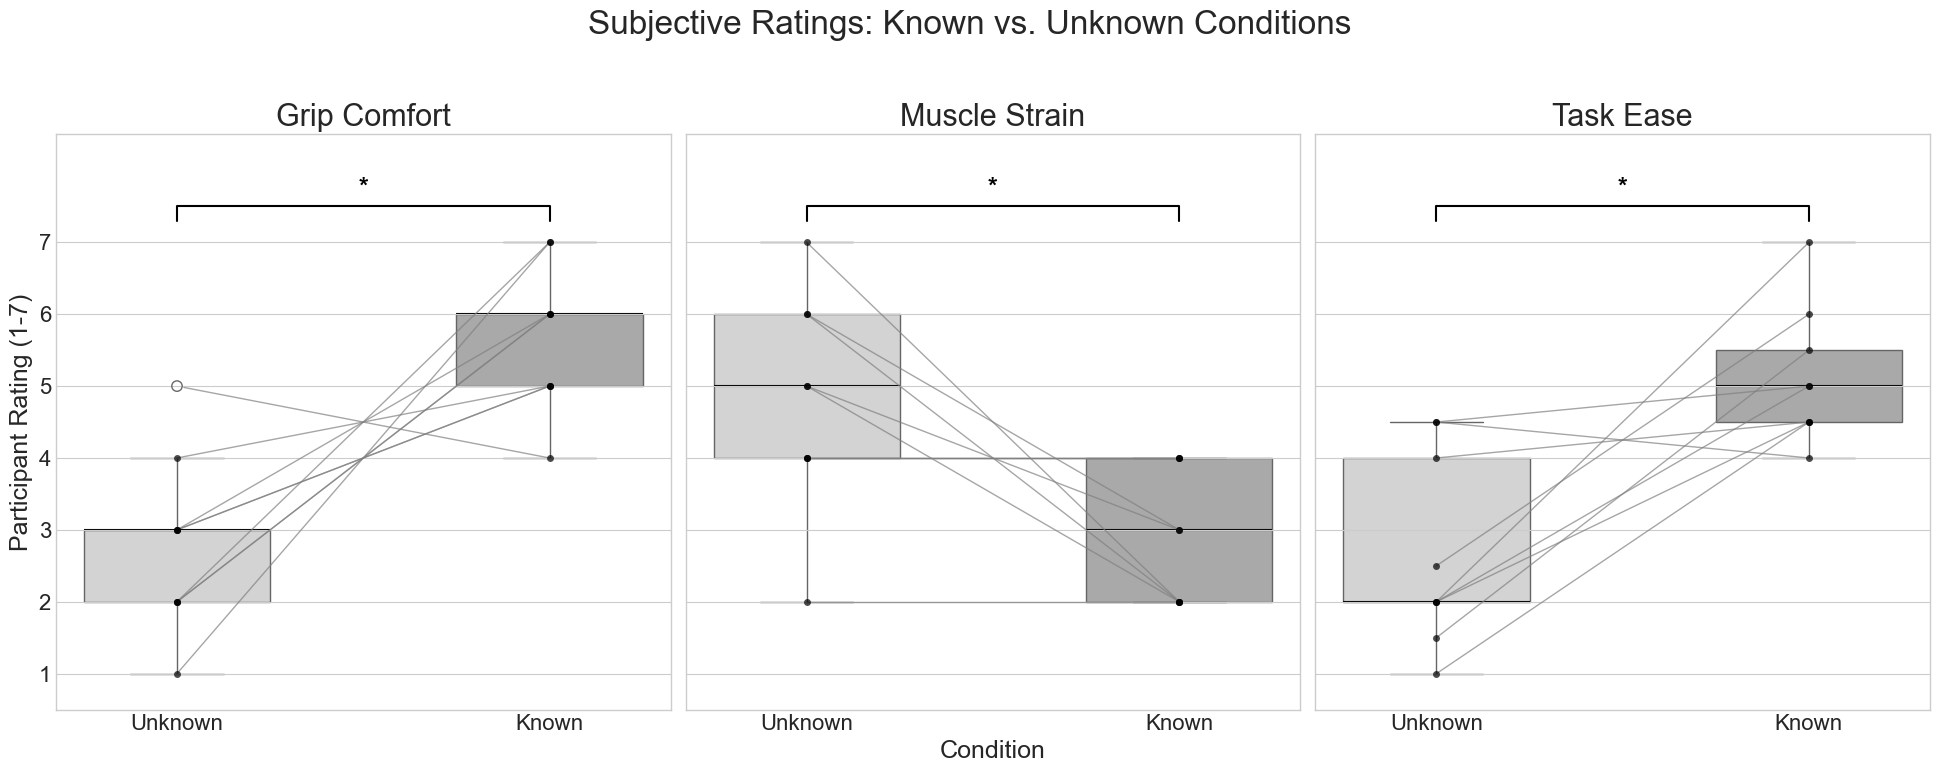


--- Generating Figure 2: Preference Rating Distributions ---


c:\Users\schmi\Documents\Studium\TUM\Masterthesis\Scripts\.venv\lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


Preference ratings distributions plot saved to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q4_Survey_Results\Preference_Ratings_Distributions_with_Significance.png


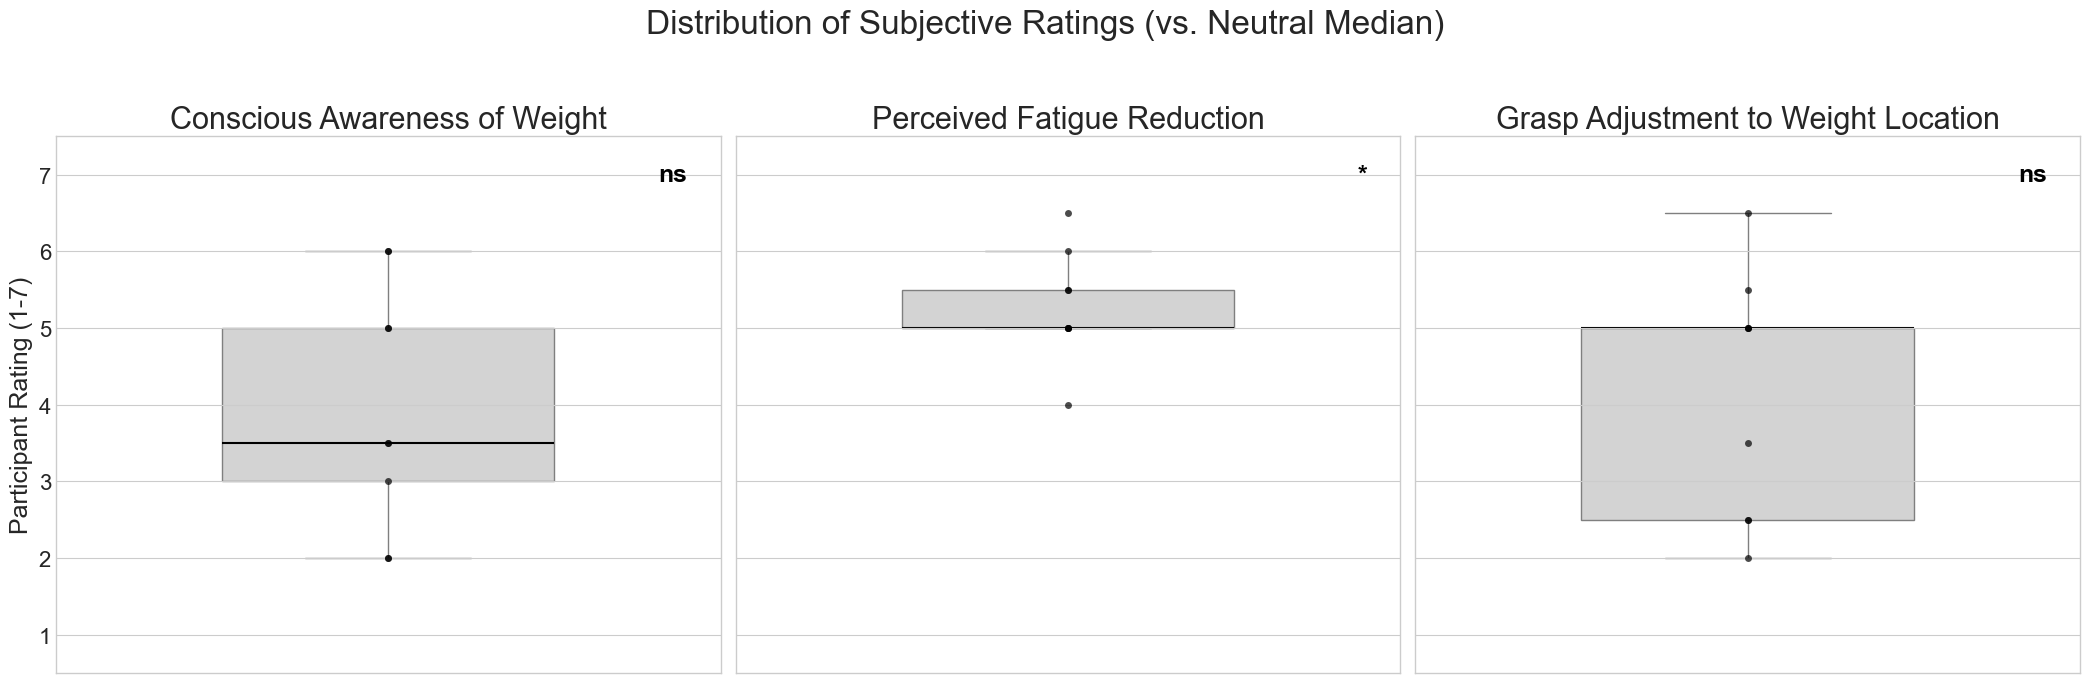


--- One-Sample Wilcoxon Tests (vs. Neutral=4) for Preference Ratings ---
One-sample test for Awareness: Statistic=22.00, p-value=1.000 (ns)
One-sample test for Fatigue: Statistic=0.00, p-value=0.011 (*)
One-sample test for Adjust Grasp: Statistic=21.00, p-value=0.910 (ns)


c:\Users\schmi\Documents\Studium\TUM\Masterthesis\Scripts\.venv\lib\site-packages\scipy\stats\_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


In [56]:
import os
import numpy as np
import pandas as pd
import warnings
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg # For Cronbach's Alpha
from matplotlib.table import Table

# --- Define new, larger font sizes ---
TITLE_FONTSIZE_LARGE = 22
LABEL_FONTSIZE_LARGE = 18
TICK_FONTSIZE_LARGE = 16
ANNOT_FONTSIZE_LARGE = 18
SUPTITLE_FONTSIZE_LARGE = 24
OUTLIER_SIZE = 6

def load_participant_data(base_path):
    """Load survey responses from all participant files."""
    data = []
    participant_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    for participant_dir in participant_dirs:
        participant_path = os.path.join(base_path, participant_dir)
        files = [f for f in os.listdir(participant_path) if f.endswith('_responses.npy')]
        for file in files:
            file_path = os.path.join(participant_path, file)
            try:
                participant_data = np.load(file_path, allow_pickle=True).item()
                details = participant_data['details']
                responses = participant_data['responses']
                data.append({
                    'participant_id': details['participant_id'],
                    'responses': responses
                })
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
    return data

def process_data(data):
    """Process the raw data into DataFrames for original and processed (reverse-coded) responses."""
    Statements = {
        1: "I consciously think about the location of the weight before grasping.",
        2: "I feel more muscle strain when I do not know the weight location.",
        3: "I feel more comfortable with my grip when I know the weight location.",
        4: "I do not adjust my grasp on the handle based on the weight location.",  # Reverse-coded
        5: "I find it easy to lift the object without tilting when I do not know the weight location.",
        6: "I feel less muscle strain when I know the weight location.",  # Reverse-coded
        7: "I find it difficult to lift the object without tilting when I know the weight location.",  # Reverse-coded
        8: "I feel uncomfortable with my grip on the object when I know the weight location.",  # Reverse-coded
        9: "I do not consciously think about the location of the weight before grasping.",  # Reverse-coded
        10: "My muscles feel more fatigued when I know the weight location.",  # Reverse-coded
        11: "My grip feels just as secure when I do not know the weight location.",
        12: "I find it easier to lift the object parallel to the table when I know the weight location.",
        13: "I adjust my grasp on the handle based on the weight location.",
        14: "My muscles feel less fatigued when I know the weight location.",
        15: "I find it difficult to lift the object without tilting when I do not know the weight location.",  # Reverse-coded
        16: "My grip feels safer when I know the weight location.",
        17: "I regularly engage in strength training exercises for my arm muscles."
    }
    data_rows = []
    for participant in data:
        participant_id = participant['participant_id']
        responses = participant['responses']
        if len(responses) != 17:
            print(f"Participant {participant_id} has {len(responses)} responses instead of 17.")
            continue
        row = {'participant_id': participant_id}
        for i, resp in enumerate(responses):
            row[f'Q{i+1}'] = resp
        data_rows.append(row)
    df_original = pd.DataFrame(data_rows)
    df_constructs = df_original.copy()
    df_consistency = df_original.copy() # Retained for potential consistency score calculation
    df_Statements = pd.DataFrame.from_dict(Statements, orient='index', columns=['Statement_Text'])
    df_Statements.index = [f'Q{i}' for i in df_Statements.index]
    reversed_items_constructs = [4, 6, 7, 8, 9, 10, 15]
    for item in reversed_items_constructs:
        df_constructs[f'Q{item}'] = 8 - df_constructs[f'Q{item}']
    
    # This was for consistency checks, keep if consistency score is calculated later
    reversed_items_consistency = [4, 6, 7, 8, 9, 10, 11, 15]
    for item in reversed_items_consistency:
        if f'Q{item}' in df_consistency.columns: # Check if column exists
             df_consistency[f'Q{item}'] = 8 - df_consistency[f'Q{item}']

    return df_constructs, df_consistency, df_original, df_Statements

def compute_constructs(df_constructs_input):
    """Compute constructs from survey Statements."""
    constructs_map = { # This is the map of construct names to question numbers
        'Awareness': [1, 9], 'Muscle Strain': [2, 6], 'Fatigue': [10, 14],
        'Grip Comfort': [3, 8, 11, 16], 'Adjust Grasp': [4, 13], 'Task Ease': [5, 7, 12, 15],
        'Strength Training': [17] # Single item construct
    }
    # Create a new DataFrame for aggregated scores to avoid modifying the input df_items_processed directly
    df_aggregated_scores = pd.DataFrame(index=df_constructs_input.index)
    df_aggregated_scores['participant_id'] = df_constructs_input['participant_id']


    for construct_name, item_q_numbers in constructs_map.items():
        q_cols = [f'Q{i}' for i in item_q_numbers]
        # Ensure all q_cols are actually in the df_constructs_input dataframe
        valid_q_cols = [col for col in q_cols if col in df_constructs_input.columns]
        if valid_q_cols:
             df_aggregated_scores[construct_name] = df_constructs_input[valid_q_cols].mean(axis=1)
        else:
            print(f"Warning: No valid question columns found for construct {construct_name}. It will be NaN in aggregated scores.")
            df_aggregated_scores[construct_name] = np.nan
            
    return df_aggregated_scores, constructs_map

def analyze_data(df_items_processed, df_constructs_aggregated, constructs_map_dict, output_dir):
    """
    Performs statistical analysis and generates two final figures:
    1. Paired tests for Known vs. Unknown conditions with advanced boxplot styling.
    2. Distribution plots for preference constructs with individual data points.
    """

    # --- Define Marker Sizes (in points) ---
    REGULAR_MARKER_DIAMETER = 5
    OUTLIER_MARKER_DIAMETER = 7.5

    # --- FIGURE 1: Paired Wilcoxon Tests & Boxplots (Known vs. Unknown) ---
    print("\n--- Generating Figure 1: Known vs. Unknown Conditions ---")
    plot_order_paired = ['Grip Comfort', 'Muscle Strain', 'Task Ease']
    paired_test_item_definitions = {
        'Grip Comfort': {'Known_Items': [f'Q{i}' for i in [16]], 'Unknown_Items': [f'Q{i}' for i in [11]]},
        'Muscle Strain': {'Known_Items': [f'Q{i}' for i in [6]], 'Unknown_Items': [f'Q{i}' for i in [2]]},
        'Task Ease': {'Known_Items': [f'Q{i}' for i in [7, 12]], 'Unknown_Items': [f'Q{i}' for i in [5, 15]]}
    }
    num_paired_constructs = len(plot_order_paired)

    fig_paired, axes_paired = plt.subplots(1, num_paired_constructs, figsize=(6.5 * num_paired_constructs, 8), sharey=True)
    if num_paired_constructs == 1: axes_paired = [axes_paired]

    plot_order_conditions = ['Unknown', 'Known']
    palette_colors = {'Unknown': 'lightgrey', 'Known': 'darkgrey'}

    for i, construct_name in enumerate(plot_order_paired):
        ax = axes_paired[i]
        items_dict = paired_test_item_definitions[construct_name]
        known_cols, unknown_cols = items_dict['Known_Items'], items_dict['Unknown_Items']

        if not (all(col in df_items_processed.columns for col in known_cols) and all(col in df_items_processed.columns for col in unknown_cols)):
            ax.text(0.5, 0.5, "Data N/A", ha='center', va='center'); ax.set_title(construct_name)
            continue

        current_known_scores = df_items_processed[known_cols].mean(axis=1)
        current_unknown_scores = df_items_processed[unknown_cols].mean(axis=1)
        common_indices = current_known_scores.dropna().index.intersection(current_unknown_scores.dropna().index)
        aligned_known_scores = current_known_scores.loc[common_indices]
        aligned_unknown_scores = current_unknown_scores.loc[common_indices]

        stat, p_value = (np.nan, np.nan)
        if len(aligned_known_scores) >= 2:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                stat, p_value = wilcoxon(aligned_known_scores, aligned_unknown_scores)
        
        print(f"\nWilcoxon Test: {construct_name} (Known vs. Unknown)")
        print(f"  Statistic: {stat:.2f}, p-value: {p_value:.3f}")

        plot_data_wide = pd.DataFrame({'Known': aligned_known_scores, 'Unknown': aligned_unknown_scores})
        
        q1_k, q3_k = plot_data_wide['Known'].quantile(0.25), plot_data_wide['Known'].quantile(0.75)
        iqr_k = q3_k - q1_k
        plot_data_wide['Known_is_outlier'] = ((plot_data_wide['Known'] < (q1_k - 1.5 * iqr_k)) | (plot_data_wide['Known'] > (q3_k + 1.5 * iqr_k)))

        q1_u, q3_u = plot_data_wide['Unknown'].quantile(0.25), plot_data_wide['Unknown'].quantile(0.75)
        iqr_u = q3_u - q1_u
        plot_data_wide['Unknown_is_outlier'] = ((plot_data_wide['Unknown'] < (q1_u - 1.5 * iqr_u)) | (plot_data_wide['Unknown'] > (q3_u + 1.5 * iqr_u)))
        
        plot_data_melted = plot_data_wide.drop(columns=['Known_is_outlier', 'Unknown_is_outlier']).reset_index().melt(id_vars='index', var_name='Condition', value_name='Score')
        is_outlier_melted = plot_data_wide[['Known_is_outlier', 'Unknown_is_outlier']].rename(columns={'Known_is_outlier': 'Known', 'Unknown_is_outlier': 'Unknown'}).reset_index().melt(id_vars='index', var_name='Condition', value_name='is_outlier')
        
        plot_data_melted = pd.merge(plot_data_melted, is_outlier_melted, on=['index', 'Condition'])
        non_outliers_melted = plot_data_melted[~plot_data_melted['is_outlier']]
        outliers_melted = plot_data_melted[plot_data_melted['is_outlier']]

        sns.boxplot(x='Condition', y='Score', data=plot_data_melted, ax=ax, order=plot_order_conditions, palette=palette_colors, width=0.5, showfliers=False, medianprops=dict(color='black', linewidth=1.5), zorder=0)

        lines_to_adjust = []
        for participant_index, row in plot_data_wide.iterrows():
            line, = ax.plot([0, 1], [row['Unknown'], row['Known']], color='gray', lw=1, alpha=0.7, zorder=1)
            lines_to_adjust.append({'line': line, 'row': row})

        if not non_outliers_melted.empty:
            sns.stripplot(x='Condition', y='Score', data=non_outliers_melted, ax=ax, order=plot_order_conditions, jitter=False, color='black', alpha=0.7, zorder=2, size=REGULAR_MARKER_DIAMETER)

        if not outliers_melted.empty:
            sns.stripplot(x='Condition', y='Score', data=outliers_melted, ax=ax, order=plot_order_conditions, jitter=False, marker='o', edgecolor='dimgray', facecolors='none', linewidth=1, zorder=3, size=OUTLIER_MARKER_DIAMETER)
            
        ax.set_title(construct_name, fontsize=TITLE_FONTSIZE_LARGE)
        
        # --- MODIFIED: Set xlabel only for the middle plot ---
        if i == (num_paired_constructs - 1) // 2:
            ax.set_xlabel('Condition', fontsize=LABEL_FONTSIZE_LARGE)
        else:
            ax.set_xlabel('')
            
        if i == 0:
            ax.set_ylabel('Participant Rating (1-7)', fontsize=LABEL_FONTSIZE_LARGE)
        else:
            ax.set_ylabel('')
        
        ax.tick_params(axis='both', labelsize=TICK_FONTSIZE_LARGE)
        ax.set_yticks(np.arange(1, 8, 1))
        ax.set_ylim(0.5, 8.5)

        asterisk_text = "n/a" if pd.isna(p_value) else ("***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else "ns")))
        if not pd.isna(p_value) and not plot_data_melted.empty:
            y_max_data = plot_data_melted['Score'].max()
            bracket_y_start = y_max_data + 0.3
            bracket_height = bracket_y_start + 0.2
            text_y = bracket_height + 0.1
            ax.plot([0, 0, 1, 1], [bracket_y_start, bracket_height, bracket_height, bracket_y_start], c='black', lw=1.5)
            ax.text(0.5, text_y, asterisk_text, ha='center', va='bottom', fontsize=ANNOT_FONTSIZE_LARGE, color='black', weight='bold')

        dpi = fig_paired.get_dpi()
        ax_bbox_pix = ax.get_window_extent()
        if ax_bbox_pix.width == 0 or ax_bbox_pix.height == 0: continue

        x_scale = (ax.get_xlim()[1] - ax.get_xlim()[0]) / ax_bbox_pix.width
        y_scale = (ax.get_ylim()[1] - ax.get_ylim()[0]) / ax_bbox_pix.height
        
        for item in lines_to_adjust:
            line, row_data = item['line'], item['row']
            
            d1_pts = OUTLIER_MARKER_DIAMETER if row_data['Unknown_is_outlier'] else 0
            d2_pts = OUTLIER_MARKER_DIAMETER if row_data['Known_is_outlier'] else 0

            if d1_pts == 0 and d2_pts == 0: continue

            r1_pix = (d1_pts / 2.0) * (dpi / 72.0)
            r2_pix = (d2_pts / 2.0) * (dpi / 72.0)
            
            x1, y1 = 0, row_data['Unknown']
            x2, y2 = 1, row_data['Known']
            
            vx_pix = (x2 - x1) / x_scale
            vy_pix = (y2 - y1) / y_scale
            len_v_pix = np.sqrt(vx_pix**2 + vy_pix**2)

            if len_v_pix == 0: continue
            
            shorten_frac1 = r1_pix / len_v_pix
            shorten_frac2 = r2_pix / len_v_pix

            if shorten_frac1 + shorten_frac2 >= 1.0:
                line.set_visible(False)
                continue
                
            new_x1 = x1 + (x2 - x1) * shorten_frac1
            new_y1 = y1 + (y2 - y1) * shorten_frac1
            new_x2 = x2 - (x2 - x1) * shorten_frac2
            new_y2 = y2 - (y2 - y1) * shorten_frac2
            
            line.set_data([new_x1, new_x2], [new_y1, new_y2])

    fig_paired.suptitle("Subjective Ratings: Known vs. Unknown Conditions", fontsize=SUPTITLE_FONTSIZE_LARGE, y=0.99)
    fig_paired.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_filename_paired = os.path.join(output_dir, "Constructs_Known_vs_Unknown_Boxplots.png")
    plt.savefig(plot_filename_paired, bbox_inches='tight', dpi=300)
    print(f"\nCombined 'Known vs. Unknown' plot saved to {plot_filename_paired}")
    plt.show()


    # --- FIGURE 2: Distribution Plots for Preference Ratings with Significance ---
    # This section remains the same.
    print("\n--- Generating Figure 2: Preference Rating Distributions ---")
    preference_constructs = ['Awareness', 'Fatigue', 'Adjust Grasp']
    preference_plot_titles = {
        'Awareness': 'Conscious Awareness of Weight',
        'Fatigue': 'Perceived Fatigue Reduction',
        'Adjust Grasp': 'Grasp Adjustment to Weight Location'
    }
    num_pref_constructs = len(preference_constructs)

    fig_pref, axes_pref = plt.subplots(1, num_pref_constructs, figsize=(7 * num_pref_constructs, 7), sharey=True)
    if num_pref_constructs == 1: axes_pref = [axes_pref]

    for i, construct_name in enumerate(preference_constructs):
        ax = axes_pref[i]
        
        if construct_name not in df_constructs_aggregated.columns or df_constructs_aggregated[construct_name].isnull().all():
            ax.text(0.5, 0.5, "Data N/A", ha='center', va='center'); ax.set_title(preference_plot_titles.get(construct_name, construct_name))
            continue

        data_series = df_constructs_aggregated[construct_name].dropna()
        
        sns.boxplot(y=data_series, ax=ax, color="lightgrey", width=0.5, 
                    showfliers=False,
                    medianprops=dict(color='black', linewidth=1.5),
                    zorder=0)
        
        sns.stripplot(y=data_series, ax=ax, 
                      jitter=False,
                      color='black', alpha=0.7, 
                      zorder=1,
                      size=REGULAR_MARKER_DIAMETER)

        stat, p_value = (np.nan, np.nan)
        if len(data_series) >= 2:
            stat, p_value = wilcoxon(data_series - 4)
        
        asterisk_text = "n/a" if pd.isna(p_value) else ("***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else "ns")))
        ax.text(0.95, 0.95, asterisk_text, transform=ax.transAxes, ha='right', va='top', fontsize=ANNOT_FONTSIZE_LARGE, color='black', weight='bold')

        ax.set_title(preference_plot_titles.get(construct_name, construct_name), fontsize=TITLE_FONTSIZE_LARGE)
        
        if i == 0:
            ax.set_ylabel('Participant Rating (1-7)', fontsize=LABEL_FONTSIZE_LARGE)
        else:
            ax.set_ylabel('')
            
        ax.set_xlabel('')
        ax.tick_params(axis='y', labelsize=TICK_FONTSIZE_LARGE)
        ax.set_xticks([])
        ax.set_yticks(np.arange(1, 8, 1))
        ax.set_ylim(0.5, 7.5)

    fig_pref.suptitle('Distribution of Subjective Ratings (vs. Neutral Median)', fontsize=SUPTITLE_FONTSIZE_LARGE, y=1.0)
    fig_pref.tight_layout(rect=[0, 0.03, 1, 0.95])
    plot_filename_pref = os.path.join(output_dir, "Preference_Ratings_Distributions_with_Significance.png")
    plt.savefig(plot_filename_pref, bbox_inches='tight', dpi=300)
    print(f"Preference ratings distributions plot saved to {plot_filename_pref}")
    plt.show()

    # Console output for the Wilcoxon tests
    print("\n--- One-Sample Wilcoxon Tests (vs. Neutral=4) for Preference Ratings ---")
    for construct_name in preference_constructs:
        if construct_name in df_constructs_aggregated.columns and not df_constructs_aggregated[construct_name].isnull().all():
            data_series = df_constructs_aggregated[construct_name].dropna()
            if len(data_series) >= 2:
                stat, p_value = wilcoxon(data_series - 4)
                asterisk_text = "n/a" if pd.isna(p_value) else ("***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else "ns")))
                print(f"One-sample test for {construct_name}: Statistic={stat:.2f}, p-value={p_value:.3f} ({asterisk_text})")

def main():
    """Main function to run the analysis workflow."""
    base_path = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
    output_dir = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q4_Survey_Results"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Plots and results will be saved to: {output_dir}")

    try:
        data = load_participant_data(base_path)
        if not data:
            raise ValueError("No participant data found.")

        df_items_processed, _, _, _ = process_data(data) # df_consistency, df_original, df_Statements also returned

        # df_constructs_aggregated contains mean scores for each construct per participant
        # constructs_map links construct names to lists of Q numbers (used for reliability)
        df_constructs_aggregated, constructs_map = compute_constructs(df_items_processed.copy())

        print("\n--- Reliability Measures (Cronbach's Alpha) ---")
        for construct_name_key, question_items_nums in constructs_map.items():
            if construct_name_key == 'Strength Training': # Skip single item constructs for reliability
                print(f"{construct_name_key}: Single item, reliability metrics not applicable.")
                continue
            if len(question_items_nums) > 1:
                item_q_cols = [f'Q{i}' for i in question_items_nums]
                valid_item_q_cols = [col for col in item_q_cols if col in df_items_processed.columns]

                if not valid_item_q_cols or len(valid_item_q_cols) < 2 :
                    print(f"{construct_name_key}: Not enough valid items ({len(valid_item_q_cols)}) for reliability.")
                    continue

                item_scores_df = df_items_processed[valid_item_q_cols].copy().dropna()
                
                if item_scores_df.shape[0] < 2 or item_scores_df.shape[1] < 2:
                    print(f"{construct_name_key}: Not enough data after NaN removal for reliability (rows: {item_scores_df.shape[0]}, items: {item_scores_df.shape[1]})")
                    continue
                
                try:
                    alpha_pg, _ = pg.cronbach_alpha(data=item_scores_df) # type: ignore
                    print(f"{construct_name_key}: Cronbach's Alpha (Pingouin) = {alpha_pg:.2f}")
                except Exception as e:
                    print(f"Could not compute Cronbach's Alpha for {construct_name_key}: {e}")
            # No else needed as single item case is handled by the 'Strength Training' check or len(q_items_nums) <=1 implicitly

        # Pass both item-level processed data and aggregated construct data to analyze_data
        analyze_data(df_items_processed.copy(), df_constructs_aggregated.copy(), constructs_map, output_dir)
        
        # Other analyses like correlation, response heatmaps, consistency scores
        # can be called here if their respective functions are defined and needed.
        # Example:
        # correlation_analysis(df_constructs_aggregated, constructs_map, output_dir)
        # visualize_responses(df_original, df_Statements_map, False, output_dir)
        # ... etc.

    except Exception as e:
        print(f"\nAn error occurred in main execution: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

### Question 5: Task Efficiency and overall Muscle Activation between Known and Unknown Conditions


--- Pass 1: Finding Peak Activation Values for Normalization ---
--- Peak values determined for all participants. ---

--- Pass 2: Calculating Raw and Normalized Activation ---
--- Processing P(1) ---
--- Processing P(2) ---
--- Processing P(3) ---
--- Processing P(4) ---
--- Processing P(5) ---
--- Processing P(6) ---
--- Processing P(7) ---
--- Processing P(8) ---

--- Paired T-Test Results for Average Activation (a.u.) ---
t-statistic: 4.309, p-value: 0.004


C:\Users\schmi\AppData\Local\Temp\ipykernel_29892\2668149703.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=y_column, data=aggregated_df, order=plot_order, palette=palette_colors,
C:\Users\schmi\AppData\Local\Temp\ipykernel_29892\2668149703.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_order)


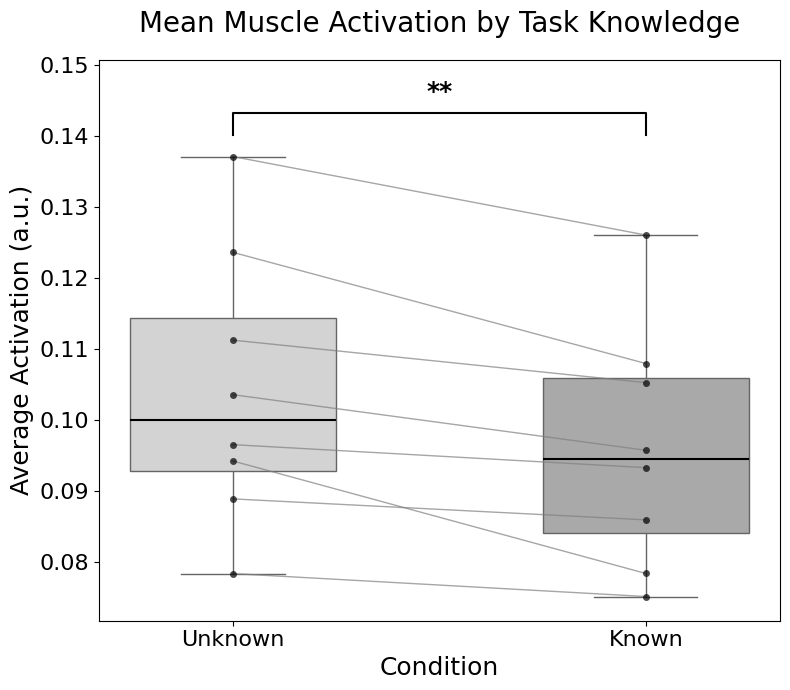

[INFO] Saved styled box plot to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q6_Muscle_Activity\activation_boxplot_raw.png

--- Paired T-Test Results for Normalized Activation (% Peak) ---
t-statistic: 4.529, p-value: 0.003


C:\Users\schmi\AppData\Local\Temp\ipykernel_29892\2668149703.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y=y_column, data=aggregated_df, order=plot_order, palette=palette_colors,
C:\Users\schmi\AppData\Local\Temp\ipykernel_29892\2668149703.py:166: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(plot_order)


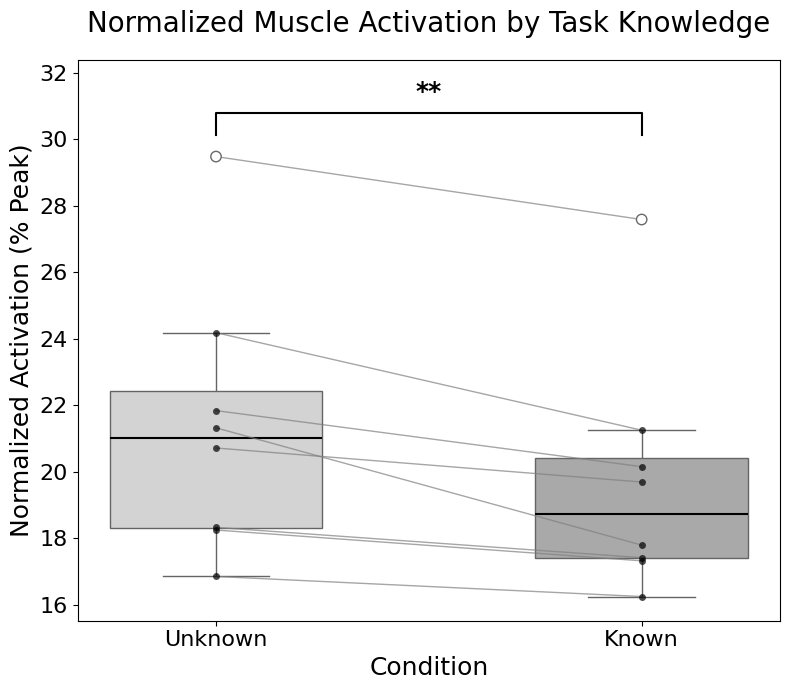

[INFO] Saved styled box plot to C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q6_Muscle_Activity\activation_boxplot_normalized.png


In [39]:
# -------------------------------------------------------------------
# Analysis of Phase 2 EMG and OTB Data: Comparing Muscle Activation Between
# "Known" and "Unknown" Task Knowledge Conditions
# -------------------------------------------------------------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import warnings

# -------------------------------------------------------------------
# 0) Global Configuration
# -------------------------------------------------------------------
BASE_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Experimental Data"
PARTICIPANTS = [1, 2, 3, 4, 5, 6, 7, 8]
TRIALS = range(1, 25)  # Trials 1 to 24
PHASE = "phase2"

# Updated Output directory
OUTPUT_DIR = r"C:\Users\schmi\Documents\Studium\TUM\Masterthesis\Adapted Results for Paper\Q6_Muscle_Activity"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Font size definitions for consistent, readable plots
TITLE_FONTSIZE_LARGE = 20
LABEL_FONTSIZE_LARGE = 18
TICK_FONTSIZE_LARGE = 16
ANNOT_FONTSIZE_LARGE = 18
OUTLIER_SIZE = 6

# -------------------------------------------------------------------
# 1) Helper Functions (Data Loading & Metadata)
# -------------------------------------------------------------------
def trial_info(trial_number):
    """Returns metadata about each trial."""
    protocol = {
        1: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Left Lever", "No"),
        2: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Left Lever", "Yes"),
        3: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Right Lever", "No"),
        4: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Right Lever", "Yes"),
        5: ("Ball Grasp", "Ball Handle", 0.50, "Left Lever", "No"),
        6: ("Ball Grasp", "Ball Handle", 0.50, "Left Lever", "Yes"),
        7: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Front Lever", "No"),
        8: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Front Lever", "Yes"),
        9: ("Disc Grip", "Disc Handle", 0.50, "Back Lever", "No"),
        10: ("Disc Grip", "Disc Handle", 0.50, "Back Lever", "Yes"),
        11: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Front Lever", "No"),
        12: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Front Lever", "Yes"),
        13: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Front Lever", "No"),
        14: ("Precision Grasp (Four Fingers and Thumb)", "Precision Handle", 0.25, "Front Lever", "Yes"),
        15: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Back Lever", "No"),
        16: ("Lateral Pinch Grasp", "Lateral Pinch Handle", 0.25, "Back Lever", "Yes"),
        17: ("Ball Grasp", "Ball Handle", 0.50, "Front Lever", "No"),
        18: ("Ball Grasp", "Ball Handle", 0.50, "Front Lever", "Yes"),
        19: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Back Lever", "No"),
        20: ("Precision Grasp (Thumb and Index)", "Precision Handle", 0.25, "Back Lever", "Yes"),
        21: ("Disc Grip", "Disc Handle", 0.50, "Left Lever", "No"),
        22: ("Disc Grip", "Disc Handle", 0.50, "Left Lever", "Yes"),
        23: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Right Lever", "No"),
        24: ("Power Bar Grasp", "Power Bar Handle", 0.50, "Right Lever", "Yes"),
    }
    if trial_number not in protocol: return None
    tup = protocol[trial_number]
    return {'grasp_type': tup[0], 'handle_type': tup[1], 'weight_kg': tup[2], 'lever_side': tup[3], 'knowledge': tup[4]}

def load_emg_data(participant_dir, trial_idx):
    """Loads the EMG data for a given participant and trial."""
    sync_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    emg_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_phase2_myo.npy")
    return np.load(emg_file) if os.path.exists(emg_file) else None

def load_otb_data(participant_dir, trial_idx):
    """Loads the OTB data for a given participant and trial."""
    sync_dir = os.path.join(participant_dir, "Synchronized Data split in Phases")
    otb_file = os.path.join(sync_dir, f"match_{trial_idx:02d}_phase2_otb.npy")
    return np.load(otb_file) if os.path.exists(otb_file) else None

# -------------------------------------------------------------------
# 2) Plotting Helper Function
# -------------------------------------------------------------------

def create_activation_boxplot(aggregated_df, y_column, y_label, title, output_filename):
    """
    Creates a boxplot where connection lines stop at the edge of outlier markers only.
    """
    # --- Define Marker Sizes (in points) ---
    REGULAR_MARKER_DIAMETER = 5
    OUTLIER_MARKER_DIAMETER = 7.5

    # --- Data Preparation ---
    pivot = aggregated_df.pivot(index='participant', columns='condition', values=y_column).dropna()
    if len(pivot) < 2:
        print(f"\n[ERROR] Not enough paired data for '{y_column}' to perform a t-test.")
        return

    # --- Upfront Outlier Detection (Corrected Logic) ---
    all_outlier_indices = []
    pivot['Unknown_is_outlier'] = False
    pivot['Known_is_outlier'] = False

    for condition in ['Unknown', 'Known']:
        # Isolate data for the condition
        condition_df = aggregated_df[aggregated_df['condition'] == condition]
        y_values = condition_df[y_column]

        # Calculate IQR bounds
        q1 = y_values.quantile(0.25)
        q3 = y_values.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Find outliers for this condition
        is_outlier_mask = (y_values < lower_bound) | (y_values > upper_bound)
        
        # Store the dataframe indices of the outliers for later plotting
        outlier_indices_for_condition = condition_df[is_outlier_mask].index
        all_outlier_indices.extend(outlier_indices_for_condition)
        
        # Update the pivot table for the line shortening logic
        outlier_participants = condition_df[is_outlier_mask]['participant'].unique()
        pivot.loc[pivot.index.isin(outlier_participants), f'{condition}_is_outlier'] = True

    # Create clean DataFrames for plotting outliers vs. non-outliers
    outliers_df = aggregated_df.loc[all_outlier_indices]
    non_outliers_df = aggregated_df.drop(all_outlier_indices)
    
    # --- Paired T-Test ---
    t_stat, p_val = ttest_rel(pivot['Unknown'], pivot['Known'])
    print(f"\n--- Paired T-Test Results for {y_label} ---")
    print(f"t-statistic: {t_stat:.3f}, p-value: {p_val:.3f}")

    # --- Plotting ---
    fig = plt.figure(figsize=(8, 7))
    ax = plt.gca()

    plot_order = ['Unknown', 'Known']
    palette_colors = {"Unknown": "lightgrey", "Known": "darkgrey"}

    # 1. Boxplot
    sns.boxplot(x='condition', y=y_column, data=aggregated_df, order=plot_order, palette=palette_colors, 
                width=0.5, ax=ax, showfliers=False, medianprops=dict(color='black', linewidth=1.5), zorder=0)

    # 2. Pairwise connection lines (initial full-length draw)
    lines_to_adjust = []
    for participant_index, row in pivot.iterrows():
        line, = ax.plot([0, 1], [row['Unknown'], row['Known']], color='gray', lw=1, alpha=0.7, zorder=1)
        lines_to_adjust.append({'line': line, 'row': row})

    # 3 & 4. Plot data points (non-outliers as solid dots, outliers as hollow circles)
    if not non_outliers_df.empty:
        sns.stripplot(x='condition', y=y_column, data=non_outliers_df, order=plot_order, jitter=False, ax=ax,
                      color='black', alpha=0.7, zorder=2, size=REGULAR_MARKER_DIAMETER)
    
    if not outliers_df.empty:
        sns.stripplot(x='condition', y=y_column, data=outliers_df, order=plot_order, jitter=False, ax=ax,
                      marker='o', edgecolor='dimgray', facecolors='none', linewidth=1, zorder=3, size=OUTLIER_MARKER_DIAMETER)

    # --- Formatting (run this before line adjustment to fix axis scales) ---
    ax.set_title(title, fontsize=TITLE_FONTSIZE_LARGE, pad=20)
    ax.set_xlabel('Condition', fontsize=LABEL_FONTSIZE_LARGE)
    ax.set_ylabel(y_label, fontsize=LABEL_FONTSIZE_LARGE)
    ax.tick_params(axis='both', labelsize=TICK_FONTSIZE_LARGE)
    ax.set_xticklabels(plot_order)
    # (Significance bracket code remains the same...)
    asterisk_text = "***" if p_val < 0.001 else ("**" if p_val < 0.01 else ("*" if p_val < 0.05 else "ns"))
    y_max = aggregated_df[y_column].max()
    y_range = aggregated_df[y_column].max() - aggregated_df[y_column].min()
    if y_range == 0: y_range = y_max if y_max > 0 else 1
    bracket_y_start = y_max + (y_range * 0.05)
    bracket_height = bracket_y_start + (y_range * 0.05)
    text_y = bracket_height + (y_range * 0.02)
    ax.plot([0, 0, 1, 1], [bracket_y_start, bracket_height, bracket_height, bracket_y_start], c='black', lw=1.5)
    ax.text(0.5, text_y, asterisk_text, ha='center', va='bottom', fontsize=ANNOT_FONTSIZE_LARGE, color='black', weight='bold')
    ax.set_ylim(top=text_y + (y_range * 0.1))

    # --- Final Line Adjustment (Corrected Logic) ---
    dpi = fig.get_dpi()
    ax_bbox_pix = ax.get_window_extent()
    x_scale = (ax.get_xlim()[1] - ax.get_xlim()[0]) / ax_bbox_pix.width
    y_scale = (ax.get_ylim()[1] - ax.get_ylim()[0]) / ax_bbox_pix.height

    for item in lines_to_adjust:
        line, row_data = item['line'], item['row']
        
        # --- MODIFIED: Set shortening radius to 0 for non-outliers ---
        d1_pts = OUTLIER_MARKER_DIAMETER if row_data['Unknown_is_outlier'] else 0
        d2_pts = OUTLIER_MARKER_DIAMETER if row_data['Known_is_outlier'] else 0
        
        # If both ends are regular points, the radii are 0 and we can skip to the next line
        if d1_pts == 0 and d2_pts == 0:
            continue

        r1_pix = (d1_pts / 2.0) * (dpi / 72.0)
        r2_pix = (d2_pts / 2.0) * (dpi / 72.0)
        
        # (The rest of the calculation logic remains the same)
        x1, y1 = 0, row_data['Unknown']
        x2, y2 = 1, row_data['Known']
        
        vx_pix = (x2 - x1) / x_scale
        vy_pix = (y2 - y1) / y_scale
        len_v_pix = np.sqrt(vx_pix**2 + vy_pix**2)

        if len_v_pix == 0: continue
        
        shorten_frac1 = r1_pix / len_v_pix
        shorten_frac2 = r2_pix / len_v_pix

        if shorten_frac1 + shorten_frac2 >= 1.0:
            line.set_visible(False)
            continue
            
        new_x1 = x1 + (x2 - x1) * shorten_frac1
        new_y1 = y1 + (y2 - y1) * shorten_frac1
        new_x2 = x2 - (x2 - x1) * shorten_frac2
        new_y2 = y2 - (y2 - y1) * shorten_frac2
        
        line.set_data([new_x1, new_x2], [new_y1, new_y2])

    # --- Save and Show ---
    plt.tight_layout()
    plot_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(plot_path, dpi=300)
    plt.show()
    print(f"[INFO] Saved styled box plot to {plot_path}")

# -------------------------------------------------------------------
# 3) Main Analysis Function
# -------------------------------------------------------------------
def main_analysis():
    """
    Performs the full analysis pipeline:
    1. Finds peak activation for each channel per participant for normalization.
    2. Calculates raw average and normalized average activation for each trial.
    3. Generates and saves plots for both metrics.
    """
    # --- Step 1: First pass to find peak values for normalization ---
    print("--- Pass 1: Finding Peak Activation Values for Normalization ---")
    participant_peaks = {}
    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir): continue

        # Initialize with zeros. Shape is 117 (5 EMG + 112 OTB).
        peak_vector = np.zeros(117)
        for trial_idx in TRIALS:
            if not trial_info(trial_idx): continue
            emg_data = load_emg_data(participant_dir, trial_idx)
            otb_data = load_otb_data(participant_dir, trial_idx)
            if emg_data is None or otb_data is None or emg_data.shape[0] != otb_data.shape[0]:
                continue
            
            combined_data = np.concatenate((emg_data, otb_data), axis=1)
            # Find the maximum value for each channel in the current trial
            trial_peaks = np.max(combined_data, axis=0)
            # Update the overall peak vector for the participant
            peak_vector = np.maximum(peak_vector, trial_peaks)

        # Replace zeros with 1 to avoid division-by-zero errors later
        peak_vector[peak_vector == 0] = 1
        participant_peaks[pid] = peak_vector
    print("--- Peak values determined for all participants. ---")


    # --- Step 2: Main pass to calculate metrics ---
    print("\n--- Pass 2: Calculating Raw and Normalized Activation ---")
    activation_rows = []
    for pid in PARTICIPANTS:
        participant_str = f"P({pid})"
        participant_dir = os.path.join(BASE_DIR, participant_str)
        if not os.path.isdir(participant_dir) or pid not in participant_peaks:
            continue

        print(f"--- Processing {participant_str} ---")
        peak_vector = participant_peaks[pid]

        for trial_idx in TRIALS:
            meta = trial_info(trial_idx)
            if not meta: continue

            emg_data = load_emg_data(participant_dir, trial_idx)
            otb_data = load_otb_data(participant_dir, trial_idx)
            if emg_data is None or otb_data is None or emg_data.shape[0] != otb_data.shape[0]:
                continue

            combined_data = np.concatenate((emg_data, otb_data), axis=1)

            # Metric 1: Raw Average Activation (original method)
            avg_activation_raw = combined_data.mean()

            # Metric 2: Normalized Average Activation (% Peak)
            normalized_data = (combined_data / peak_vector) * 100
            avg_activation_norm = normalized_data.mean()

            activation_rows.append({
                'participant': pid,
                'condition': "Known" if meta['knowledge'] == "Yes" else "Unknown",
                'avg_activation_raw': avg_activation_raw,
                'avg_activation_norm': avg_activation_norm
            })

    # --- Step 3: Aggregation and Plotting ---
    if not activation_rows:
        print("[ERROR] No data was processed. Exiting analysis.")
        return

    full_df = pd.DataFrame(activation_rows)

    # --- Analysis for RAW (non-normalized) data ---
    agg_raw = full_df.groupby(['participant', 'condition'])['avg_activation_raw'].mean().reset_index()
    create_activation_boxplot(
        aggregated_df=agg_raw,
        y_column='avg_activation_raw',
        y_label='Average Activation (a.u.)',
        title='Mean Muscle Activation by Task Knowledge',
        output_filename='activation_boxplot_raw.png'
    )

    # --- Analysis for NORMALIZED data ---
    agg_norm = full_df.groupby(['participant', 'condition'])['avg_activation_norm'].mean().reset_index()
    create_activation_boxplot(
        aggregated_df=agg_norm,
        y_column='avg_activation_norm',
        y_label='Normalized Activation (% Peak)',
        title='Normalized Muscle Activation by Task Knowledge',
        output_filename='activation_boxplot_normalized.png'
    )

# -------------------------------------------------------------------
# 4) Main Execution
# -------------------------------------------------------------------
if __name__ == "__main__":
    main_analysis()

### Question 6: Synergy Mapping
